</font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

In [1]:
filename_version='3dot9'

In [2]:
import sys
source_directory = "/Users/pauljacob/Library/Python/3.8/lib/python/site-packages"

sys.path.append(source_directory)

In [3]:
#file structure
!pip3 install cookiecutter

#general
!pip3 install --upgrade pip
!pip3 install ipython-autotime --quiet


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
%load_ext autotime

time: 267 µs (started: 2023-01-02 16:11:43 -08:00)


## Import Libraries

In [5]:
#get libraries
import pandas as pd
import os
import numpy as np


#get visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.patches as mpatches



#ML preprocessing
from sklearn.preprocessing import StandardScaler

#get ML functions
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


from sklearn import __version__ as sklearn_version
import datetime


#get ML metric functions
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import log_loss

#get icr module and associated common functions
import in_vehicle_coupon_recommendation as icr
from in_vehicle_coupon_recommendation import p, rcp, rpp, rcr, sr, pl, pdc, save_and_return_data_frame, initialize_custom_notebook_settings

#sound alert
from IPython.display import Audio

time: 1.31 s (started: 2023-01-02 16:11:43 -08:00)


In [6]:
#initialize notebook
initialize_custom_notebook_settings()

%load_ext autoreload
%autoreload 1
%aimport in_vehicle_coupon_recommendation 


time: 20.8 ms (started: 2023-01-02 16:11:44 -08:00)


## Get In-Vehicle Coupon Recommendation Dataset

In [7]:
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'in-vehicle-coupon-recommendation.csv'))
df = df.sample(frac=1, random_state=200)
#p(df)

time: 33.9 ms (started: 2023-01-02 16:11:44 -08:00)


<font size="5"><a id='[Data_Wrangling]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Wrangling]'>**Data Wrangling**</a> </font>

In [8]:
#rename 'passanger' and 'coupon' column
df = df.rename(columns={'passanger':'passenger', 'coupon':'coupon_venue_type'})


#decode string 'age' values to (explicit) string age ranges
column_name_age_value_list = list(df.loc[:, 'age'].unique())
column_name_age_value_list_cleaned_up = ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', '<21']
column_name_age_value_dict = dict(zip(column_name_age_value_list, column_name_age_value_list_cleaned_up))
df.loc[:, 'age'] = df.loc[:, 'age'].replace(column_name_age_value_dict)

del column_name_age_value_dict, column_name_age_value_list, column_name_age_value_list_cleaned_up


#drop column 'toCoupon_GEQ5min' because all 1's
column_name_list_not_toCoupon_GEQ5min = [column_name for column_name in df.columns if column_name != 'toCoupon_GEQ5min']
df = df.loc[:, column_name_list_not_toCoupon_GEQ5min]

del column_name_list_not_toCoupon_GEQ5min


#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language...
#get column name list for column values uniques that are the same as column name 'CarryAway' value uniques
column_name_list_same_unique_values = []
for column_name in df.columns:    
    value = icr.column_name_value_sets_equal(df, column_name1='CarryAway', column_name2=column_name)
    if value == 1:
        column_name_list_same_unique_values = column_name_list_same_unique_values + [column_name]
#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language
column_name_Bar_value_list = list(df.loc[:, 'Bar'].unique())
column_name_Bar_value_list_cleaned_up = ['never', '<1', '1-3', '>8', np.nan, '4-8']
column_name_Bar_value_dict = dict(zip(column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up))
df.loc[:, column_name_list_same_unique_values] = df.loc[:, column_name_list_same_unique_values].replace(column_name_Bar_value_dict)

del column_name_Bar_value_dict, column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up, column_name_list_same_unique_values


#clean up columns 'direction_same' and 'direction_opp' to 'direction_same_or_opposite'
#drop column 'direction_same'
column_name_list_not_direction_same = [column_name for column_name in df.columns if column_name != 'direction_same']
df = df.loc[:, column_name_list_not_direction_same]

del column_name_list_not_direction_same

#rename 'direction_opp' to 'direction_same_or_opposite'
df = df.rename(columns={'direction_opp':'direction_same_or_opposite'})


#solution1: fill in missing values with 'no response' or 'unknown'
column_name_list = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'car']
df.loc[:, column_name_list] = df.loc[:, column_name_list].fillna('no response')


#fix income values
income_list = df.loc[:, 'income'].drop_duplicates().to_list()
income_list_fixed = ['\$12500 - \$24999', '\$87500 - \$99999', '\$37500 - \$49999', '\$50000 - \$62499', '\$75000 - \$87499', '\$25000 - \$37499', '\$100000 or More', 'Less than \$12500', '\$62500 - \$74999']
income_dictionary = dict(zip(income_list, income_list_fixed))
df.loc[:, 'income'] = df.loc[:, 'income'].replace(income_dictionary)
p(df)



(12684, 24)


destination passenger weather  temperature  time  \
11199             Home     Alone   Sunny           80   6PM   
1474              Work     Alone   Sunny           55   7AM   
10836             Home     Alone   Sunny           30   6PM   
4567   No Urgent Place     Alone   Sunny           80  10AM   
5658   No Urgent Place     Alone   Sunny           80   2PM   
11343             Work     Alone   Sunny           80   7AM   
9036              Home     Alone   Snowy           30  10PM   
11050             Home     Alone   Sunny           80   6PM   
784               Work     Alone   Sunny           80   7AM   
1818   No Urgent Place    Kid(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
11199  Carry out & Take away         2h    Male  21-25             Single   
1474                     Bar         1d    Male  46-49    Married partner   
10836  Carry out & Take away         1d    Male  26-30             Single   
4567                     Bar         1d  Female  21-25  Unmarried partner   
5658         Restaurant(<20)         2h  Female  31-35             Single   
11343      Restaurant(20-50)         2h  Female  36-40             Single   
9036         Restaurant(<20)         2h    Male  26-30             Single   
11050      Restaurant(20-50)         1d    Male  46-49             Single   
784    Carry out & Take away         2h  Female  21-25             Single   
1818                     Bar         1d  Female  36-40    Married partner   

       has_children                               education  \
11199             0                        Bachelors degree   
1474              1  Graduate degree (Masters or Doctorate)   
10836             0                Some college - no degree   
4567              0  Graduate degree (Masters or Doctorate)   
5658              1                        Bachelors degree   
11343             1                        Bachelors degree   
9036              0                Some college - no degree   
11050             0                Some college - no degree   
784               0  Graduate degree (Masters or Doctorate)   
1818              1                        Bachelors degree   

                               occupation             income          car  \
11199                             Student  \$12500 - \$24999  no response   
1474                           Management  \$87500 - \$99999  no response   
10836                     Sales & Related  \$37500 - \$49999  no response   
4567           Education&Training&Library  \$37500 - \$49999  no response   
5658               Production Occupations  \$37500 - \$49999  no response   
11343  Food Preparation & Serving Related  \$12500 - \$24999  no response   
9036                              Student  \$12500 - \$24999  no response   
11050                     Sales & Related  Less than \$12500  no response   
784                                 Legal  \$25000 - \$37499  no response   
1818                              Retired  \$50000 - \$62499  no response   

         Bar  CoffeeHouse    CarryAway RestaurantLessThan20 Restaurant20To50  \
11199  never  no response  no response          no response            never   
1474   never           <1           <1                never               <1   
10836     <1  no response           >8                   <1            never   
4567     1-3           <1           <1                   <1            never   
5658   never        never           >8                  4-8            never   
11343    1-3           <1           >8                never            never   
9036      <1        never           >8                never              1-3   
11050     <1           <1           >8                   >8               >8   
784       <1           <1           <1          no response               <1   
1818     1-3        never           >8                   <1            never   

       toCoupon_GEQ15min  toCoupon_GEQ25min  d

time: 86.5 ms (started: 2023-01-02 16:11:44 -08:00)


### Store df_pre_feature_engineering from df

In [9]:
df_pre_feature_engineering = df.copy()
p(df_pre_feature_engineering)

(12684, 24)


destination passenger weather  temperature  time  \
11199             Home     Alone   Sunny           80   6PM   
1474              Work     Alone   Sunny           55   7AM   
10836             Home     Alone   Sunny           30   6PM   
4567   No Urgent Place     Alone   Sunny           80  10AM   
5658   No Urgent Place     Alone   Sunny           80   2PM   
11343             Work     Alone   Sunny           80   7AM   
9036              Home     Alone   Snowy           30  10PM   
11050             Home     Alone   Sunny           80   6PM   
784               Work     Alone   Sunny           80   7AM   
1818   No Urgent Place    Kid(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
11199  Carry out & Take away         2h    Male  21-25             Single   
1474                     Bar         1d    Male  46-49    Married partner   
10836  Carry out & Take away         1d    Male  26-30             Single   
4567                     Bar         1d  Female  21-25  Unmarried partner   
5658         Restaurant(<20)         2h  Female  31-35             Single   
11343      Restaurant(20-50)         2h  Female  36-40             Single   
9036         Restaurant(<20)         2h    Male  26-30             Single   
11050      Restaurant(20-50)         1d    Male  46-49             Single   
784    Carry out & Take away         2h  Female  21-25             Single   
1818                     Bar         1d  Female  36-40    Married partner   

       has_children                               education  \
11199             0                        Bachelors degree   
1474              1  Graduate degree (Masters or Doctorate)   
10836             0                Some college - no degree   
4567              0  Graduate degree (Masters or Doctorate)   
5658              1                        Bachelors degree   
11343             1                        Bachelors degree   
9036              0                Some college - no degree   
11050             0                Some college - no degree   
784               0  Graduate degree (Masters or Doctorate)   
1818              1                        Bachelors degree   

                               occupation             income          car  \
11199                             Student  \$12500 - \$24999  no response   
1474                           Management  \$87500 - \$99999  no response   
10836                     Sales & Related  \$37500 - \$49999  no response   
4567           Education&Training&Library  \$37500 - \$49999  no response   
5658               Production Occupations  \$37500 - \$49999  no response   
11343  Food Preparation & Serving Related  \$12500 - \$24999  no response   
9036                              Student  \$12500 - \$24999  no response   
11050                     Sales & Related  Less than \$12500  no response   
784                                 Legal  \$25000 - \$37499  no response   
1818                              Retired  \$50000 - \$62499  no response   

         Bar  CoffeeHouse    CarryAway RestaurantLessThan20 Restaurant20To50  \
11199  never  no response  no response          no response            never   
1474   never           <1           <1                never               <1   
10836     <1  no response           >8                   <1            never   
4567     1-3           <1           <1                   <1            never   
5658   never        never           >8                  4-8            never   
11343    1-3           <1           >8                never            never   
9036      <1        never           >8                never              1-3   
11050     <1           <1           >8                   >8               >8   
784       <1           <1           <1          no response               <1   
1818     1-3        never           >8                   <1            never   

       toCoupon_GEQ15min  toCoupon_GEQ25min  d

time: 11 ms (started: 2023-01-02 16:11:44 -08:00)


In [10]:
column_name_list_scenario = ['destination', 'passenger', 'weather', 'temperature', 'time', 'coupon_venue_type', 'expiration', 
                             'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same_or_opposite']
pl(column_name_list_scenario)


10


['destination',
 'passenger',
 'weather',
 'temperature',
 'time',
 'coupon_venue_type',
 'expiration',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same_or_opposite']

time: 2.04 ms (started: 2023-01-02 16:11:44 -08:00)


In [11]:
df.loc[:, column_name_list_scenario].drop_duplicates().shape

(201, 10)

time: 7.76 ms (started: 2023-01-02 16:11:44 -08:00)


In [12]:
df.loc[:, column_name_list_scenario].drop_duplicates() #there are plenty of combinations of sceanrios, what are the scenario counts??

#are some scenarios not represented and why???

destination  passenger weather  temperature  time  \
11199             Home      Alone   Sunny           80   6PM   
1474              Work      Alone   Sunny           55   7AM   
10836             Home      Alone   Sunny           30   6PM   
4567   No Urgent Place      Alone   Sunny           80  10AM   
5658   No Urgent Place      Alone   Sunny           80   2PM   
431    No Urgent Place  Friend(s)   Sunny           80  10AM   
11668  No Urgent Place    Partner   Rainy           55   6PM   
473    No Urgent Place      Alone   Sunny           55   2PM   
4732              Home      Alone   Sunny           80  10PM   
2323   No Urgent Place  Friend(s)   Sunny           80   6PM   
3256   No Urgent Place  Friend(s)   Sunny           55   2PM   
3122   No Urgent Place  Friend(s)   Sunny           80   6PM   
9648   No Urgent Place      Alone   Sunny           30  10AM   
7329   No Urgent Place     Kid(s)   Snowy           30   6PM   
3523   No Urgent Place    Partner   Sunny           80  10AM   
2611   No Urgent Place     Kid(s)   Sunny           80  10AM   
4376   No Urgent Place    Partner   Sunny           80   2PM   
3898   No Urgent Place  Friend(s)   Sunny           55   2PM   
637    No Urgent Place  Friend(s)   Sunny           80   2PM   
5743   No Urgent Place  Friend(s)   Sunny           80   2PM   
5041   No Urgent Place     Kid(s)   Sunny           80  10AM   
8375   No Urgent Place     Kid(s)   Sunny           80   2PM   
9309              Work      Alone   Rainy           55   7AM   
12317             Home      Alone   Rainy           55  10PM   
2958              Work      Alone   Sunny           55   7AM   
11295             Work      Alone   Rainy           55   7AM   
4211              Home      Alone   Sunny           80  10PM   
2197              Home      Alone   Sunny           55   6PM   
196    No Urgent Place  Friend(s)   Sunny           80  10AM   
727    No Urgent Place  Friend(s)   Sunny           80   2PM   
5395   No Urgent Place  Friend(s)   Sunny           55   2PM   
9850              Work      Alone   Sunny           30   7AM   
6698              Home      Alone   Sunny           55   6PM   
4767   No Urgent Place  Friend(s)   Sunny           80   6PM   
4543              Work      Alone   Sunny           80   7AM   
9058              Home      Alone   Rainy           55   6PM   
9738   No Urgent Place      Alone   Sunny           80  10PM   
10417             Home      Alone   Sunny           80  10PM   
3182              Work      Alone   Sunny           80   7AM   
1516              Home      Alone   Sunny           80   6PM   
12604             Home      Alone   Sunny           80   6PM   
11037  No Urgent Place  Friend(s)   Sunny           80  10PM   
2746   No Urgent Place      Alone   Sunny           55  10AM   
9947   No Urgent Place  Friend(s)   Sunny           55  10AM   
12621  No Urgent Place    Partner   Snowy           30  10AM   
7861   No Urgent Place  Friend(s)   Sunny           80  10AM   
7903              Work      Alone   Sunny           80   7AM   
11087  No Urgent Place      Alone   Sunny           80  10AM   
6616              Home     Kid(s)   Snowy           30  10PM   
923               Work      Alone   Sunny           55   7AM   
9118   No Urgent Place     Kid(s)   Sunny           80  10AM   
1354   No Urgent Place    Partner   Sunny           80  10AM   
7607   No Urgent Place  Friend(s)   Rainy           55  10PM   
2083   No Urgent Place     Kid(s)   Sunny           80   2PM   
10105  No Urgent Place     Kid(s)   Sunny           80   2PM   
9609              Home      Alone   Snowy           30  10PM   
9778   No Urgent Place  Friend(s)   Rainy           55  10PM   
8431   No Urgent Place     Kid(s)   Rainy           55  10PM   
8557              Work      Alone   Rainy           55   7AM   
7835              Work      Alone   Snowy           30   7AM   
4289   No Urgent Place    Partner   Sunny           80  10AM   
8990              Home      Alone   Sunny  

time: 30.6 ms (started: 2023-01-02 16:11:44 -08:00)


In [13]:
df.loc[:, column_name_list_scenario].value_counts() #yes, the most represented scenario is heading to Work, alon, sunny weather, 55 degrees, 7am, coffee house, 
#2hours till expiration.


destination      passenger  weather  temperature  time  coupon_venue_type      expiration  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same_or_opposite
Work             Alone      Sunny    55           7AM   Bar                    1d          1                  1                  1                             194
No Urgent Place  Friend(s)  Sunny    55           2PM   Carry out & Take away  1d          1                  0                  1                             181
                                     80           2PM   Coffee House           2h          1                  0                  1                             181
Work             Alone      Sunny    80           7AM   Carry out & Take away  2h          0                  0                  0                             181
No Urgent Place  Alone      Sunny    55           2PM   Restaurant(<20)        1d          0                  0                  1                             181
                 Friend(s)  S

time: 14.3 ms (started: 2023-01-02 16:11:45 -08:00)


In [14]:
#how many permutations is there?

#expiration is 2
#temperature is 3
#time is 5

#201


time: 390 µs (started: 2023-01-02 16:11:45 -08:00)


In [15]:
df.value_counts('expiration') #imbalance in the expiration date??? why???? how does this influence our analysis????

expiration
1d    7091
2h    5593
dtype: int64

time: 3.06 ms (started: 2023-01-02 16:11:45 -08:00)


In [16]:
7091 / (7091 + 5593)

0.5590507726269316

time: 1.17 ms (started: 2023-01-02 16:11:45 -08:00)


In [17]:
df.loc[:, column_name_list_scenario].drop_duplicates().value_counts('expiration')

expiration
1d    118
2h     83
dtype: int64

time: 8.49 ms (started: 2023-01-02 16:11:45 -08:00)


In [18]:
101 / (101 + 73)

0.5804597701149425

time: 1.27 ms (started: 2023-01-02 16:11:45 -08:00)


<font size="5"><a id='[Feature_Engineering]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Feature_Engineering]'>**Feature Engineering**</a> </font>

## Get Category Representative Numeric Encoding for Features: expiration, time, age, income

In [19]:
#category representative numeric encoding: expiration, time, age, income

expiration_category_representative_numeric_encoding={'expiration':{'2h':2, '1d':24}}
time_category_representative_numeric_encoding={'time':{'7AM':7,'10AM':10, '2PM':14, '6PM':18, '10PM':22}}
age_category_representative_numeric_encoding={'age':{'<21':18, '21-25':23, '26-30':28, '31-35':33, '36-40':38, '41-45':43, '46-49':48, '50+':56}}
income_category_representative_numeric_encoding={'income':{'Less than \$12500':6250, '\$12500 - \$24999':18749.5, '\$25000 - \$37499':31249.5, '\$37500 - \$49999':43749.5, '\$50000 - \$62499':56249.5, '\$62500 - \$74999':68749.5, '\$75000 - \$87499':81249.5, '\$87500 - \$99999':93749.5,'\$100000 or More':150000}}

#combine category representative numeric encoding dictionaries
category_representative_numeric_encoding_dictionary = expiration_category_representative_numeric_encoding|time_category_representative_numeric_encoding|age_category_representative_numeric_encoding|income_category_representative_numeric_encoding

del expiration_category_representative_numeric_encoding, time_category_representative_numeric_encoding, age_category_representative_numeric_encoding, income_category_representative_numeric_encoding

category_representative_numeric_encoding_key_list = list(category_representative_numeric_encoding_dictionary.keys())

df_category_representative_numeric_encoding = df.loc[:, category_representative_numeric_encoding_key_list].replace(category_representative_numeric_encoding_dictionary)

del category_representative_numeric_encoding_dictionary, 

#rename columns
category_representative_numeric_encoding_substring='_category_representative_numeric_encoding'

column_name_list_category_representative_numeric_encoding = [str(column_name) + category_representative_numeric_encoding_substring for column_name in category_representative_numeric_encoding_key_list]

column_name_dictionary_category_representative_numeric_encoding = dict(zip(category_representative_numeric_encoding_key_list, column_name_list_category_representative_numeric_encoding))

df_category_representative_numeric_encoding = df_category_representative_numeric_encoding.rename(columns=column_name_dictionary_category_representative_numeric_encoding)

del column_name_dictionary_category_representative_numeric_encoding, column_name_list_category_representative_numeric_encoding, category_representative_numeric_encoding_key_list, category_representative_numeric_encoding_substring

#p(df_category_representative_numeric_encoding)

time: 23.7 ms (started: 2023-01-02 16:11:45 -08:00)


## Get Binary Encoding for Features: gender, expiration

In [20]:
#binary encoding: gender, expiration
gender_binary_encoding={'gender':{'Female':0, 'Male':1}}
expiration_binary_encoding={'expiration':{'2h':0, '1d':1}}

binary_encoding_dictionary = gender_binary_encoding|expiration_binary_encoding

del gender_binary_encoding, expiration_binary_encoding

binary_encoding_key_list = list(binary_encoding_dictionary.keys())

df_binary_encoding = df.loc[:, binary_encoding_key_list].replace(binary_encoding_dictionary)

del binary_encoding_dictionary


#rename columns
binary_encoding_substring = '_binary_encoding'
column_name_list_binary_encoding = [str(column_name) + binary_encoding_substring for column_name in binary_encoding_key_list]
column_name_dictionary_binary_encoding = dict(zip(binary_encoding_key_list, column_name_list_binary_encoding))
df_binary_encoding = df_binary_encoding.rename(columns=column_name_dictionary_binary_encoding)

del column_name_dictionary_binary_encoding, column_name_list_binary_encoding, binary_encoding_key_list, binary_encoding_substring

#p(df_binary_encoding)

time: 10.7 ms (started: 2023-01-02 16:11:45 -08:00)


## Get Ordinal Integer Encoding for Features: coupon_venue_type, education, income, age, time, temperature

In [21]:
#ordinal integer encoding: coupon_venue_type, education, income, age, time, temperature

#category ordinal features to ordinal integer encoding
coupon_venue_type_ordinal_integer_encoding={'coupon_venue_type':{'Coffee House':1, 'Bar':2, 'Carry out & Take away':3, 'Restaurant(<20)':4, 'Restaurant(20-50)':5}}
education_ordinal_integer_encoding={'education':{'Some High School':1, 'High School Graduate':2, 'Some college - no degree':3, 'Associates degree':4, 'Bachelors degree':5,'Graduate degree (Masters or Doctorate)':6}}
income_ordinal_integer_encoding={'income':{'Less than \$12500':1, '\$12500 - \$24999':2, '\$25000 - \$37499':3, '\$37500 - \$49999':4, '\$50000 - \$62499':5, '\$62500 - \$74999':6, '\$75000 - \$87499':7, '\$87500 - \$99999':8, '\$100000 or More':9}}
age_ordinal_integer_encoding={'age':{'<21':1, '21-25':2, '26-30':3, '31-35':4, '36-40':5, '41-45':6, '46-49':7, '50+':8}}
time_ordinal_integer_encoding={'time':{'7AM':1, '10AM':2, '2PM':3, '6PM':4, '10PM':5}}

#numeric to ordinal integer encoding
temperature_ordinal_integer_encoding={'temperature':{30:1, 55:2, 80:3}}


ordinal_integer_encoding_dictionary = coupon_venue_type_ordinal_integer_encoding|education_ordinal_integer_encoding|income_ordinal_integer_encoding|age_ordinal_integer_encoding|time_ordinal_integer_encoding|temperature_ordinal_integer_encoding

del coupon_venue_type_ordinal_integer_encoding, education_ordinal_integer_encoding, income_ordinal_integer_encoding, age_ordinal_integer_encoding, time_ordinal_integer_encoding, temperature_ordinal_integer_encoding

ordinal_integer_encoding_key_list = list(ordinal_integer_encoding_dictionary.keys())

df_ordinal_integer_encoding = df.loc[:, ordinal_integer_encoding_key_list].replace(ordinal_integer_encoding_dictionary)

del ordinal_integer_encoding_dictionary

#rename columns
ordinal_integer_encoding_substring='_ordinal_integer_encoding'
column_name_list_ordinal_integer_encoding=[str(column_name) + ordinal_integer_encoding_substring for column_name in ordinal_integer_encoding_key_list]
column_name_dictionary_ordinal_integer_encoding=dict(zip(ordinal_integer_encoding_key_list,column_name_list_ordinal_integer_encoding))
df_ordinal_integer_encoding=df_ordinal_integer_encoding.rename(columns=column_name_dictionary_ordinal_integer_encoding)

del column_name_dictionary_ordinal_integer_encoding, column_name_list_ordinal_integer_encoding, ordinal_integer_encoding_key_list, ordinal_integer_encoding_substring

#p(df_ordinal_integer_encoding)

time: 31.7 ms (started: 2023-01-02 16:11:45 -08:00)


## Get Venue Type Visits Per Month Yes Response to Ordinal Integer Encoding for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [22]:
#venue type visits per month yes response to ordinal integer encoding: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Bar':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CoffeeHouse':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding={'CarryAway':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding={'RestaurantLessThan20':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding={'Restaurant20To50':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}


venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary=bar_venue_visit_frequency_yes_response_ordinal_integer_encoding|coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding|carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding|restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

del bar_venue_visit_frequency_yes_response_ordinal_integer_encoding, carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding
#del bar_venue_visit_frequency_yes_response_ordinal_integer_encoding, coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding, carryaway_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurantlessthan20_venue_visit_frequency_yes_response_ordinal_integer_encoding, restaurant20to50_venue_visit_frequency_yes_response_ordinal_integer_encoding

venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list=list(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary.keys())

df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df.loc[:, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list].replace(venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary)

del venue_visit_frequency_yes_response_ordinal_integer_encoding_dictionary

#rename columns
venue_visit_frequency_yes_response_ordinal_integer_encoding_substring='_venue_visit_frequency_yes_response_ordinal_integer_encoding'
column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding=[str(column_name) + venue_visit_frequency_yes_response_ordinal_integer_encoding_substring for column_name in venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list]
column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding=dict(zip(venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding))
df_venue_visit_frequency_yes_response_ordinal_integer_encoding = df_venue_visit_frequency_yes_response_ordinal_integer_encoding.rename(columns=column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding)

del column_name_dictionary_venue_visit_frequency_yes_response_ordinal_integer_encoding, venue_visit_frequency_yes_response_ordinal_integer_encoding_key_list, venue_visit_frequency_yes_response_ordinal_integer_encoding_substring, column_name_list_venue_visit_frequency_yes_response_ordinal_integer_encoding

#p(df_venue_visit_frequency_yes_response_ordinal_integer_encoding)

time: 29.1 ms (started: 2023-01-02 16:11:45 -08:00)


## Get Venue Type Visits Per Month No Response to Indicator Variable for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [23]:
#venue type visits per month no response to indicator variable: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_venue_visit_frequency_no_response_indicator_variable={'Bar':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
coffeehouse_venue_visit_frequency_no_response_indicator_variable={'CoffeeHouse':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
carryaway_venue_visit_frequency_no_response_indicator_variable={'CarryAway':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable={'RestaurantLessThan20':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurant20to50_venue_visit_frequency_no_response_indicator_variable={'Restaurant20To50':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}

venue_visit_frequency_no_response_indicator_variable_dictionary=bar_venue_visit_frequency_no_response_indicator_variable|coffeehouse_venue_visit_frequency_no_response_indicator_variable|carryaway_venue_visit_frequency_no_response_indicator_variable|restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable|restaurant20to50_venue_visit_frequency_no_response_indicator_variable

del bar_venue_visit_frequency_no_response_indicator_variable, coffeehouse_venue_visit_frequency_no_response_indicator_variable, carryaway_venue_visit_frequency_no_response_indicator_variable, restaurantlessthan20_venue_visit_frequency_no_response_indicator_variable, restaurant20to50_venue_visit_frequency_no_response_indicator_variable

venue_visit_frequency_no_response_indicator_variable_key_list=list(venue_visit_frequency_no_response_indicator_variable_dictionary.keys())

df_venue_visit_frequency_no_response_indicator_variable=df.loc[:, venue_visit_frequency_no_response_indicator_variable_key_list].replace(venue_visit_frequency_no_response_indicator_variable_dictionary)

del venue_visit_frequency_no_response_indicator_variable_dictionary

#rename columns
venue_visit_frequency_no_response_indicator_variable='_venue_visit_frequency_no_response_indicator'
column_name_list_venue_visit_frequency_no_response_indicator_variable=[str(column_name) + venue_visit_frequency_no_response_indicator_variable for column_name in venue_visit_frequency_no_response_indicator_variable_key_list]
column_name_dictionary_venue_visit_frequency_no_response_indicator_variable=dict(zip(venue_visit_frequency_no_response_indicator_variable_key_list, column_name_list_venue_visit_frequency_no_response_indicator_variable))
df_venue_visit_frequency_no_response_indicator_variable=df_venue_visit_frequency_no_response_indicator_variable.rename(columns=column_name_dictionary_venue_visit_frequency_no_response_indicator_variable)

del column_name_dictionary_venue_visit_frequency_no_response_indicator_variable, column_name_list_venue_visit_frequency_no_response_indicator_variable, venue_visit_frequency_no_response_indicator_variable_key_list, venue_visit_frequency_no_response_indicator_variable

#p(df_venue_visit_frequency_no_response_indicator_variable)

time: 29.7 ms (started: 2023-01-02 16:11:45 -08:00)


In [24]:
df_venue_visit_frequency_no_response_indicator_variable

Bar_venue_visit_frequency_no_response_indicator  \
11199                                                0   
1474                                                 0   
10836                                                0   
4567                                                 0   
5658                                                 0   
...                                                ...   
11343                                                0   
9036                                                 0   
11050                                                0   
784                                                  0   
1818                                                 0   

       CoffeeHouse_venue_visit_frequency_no_response_indicator  \
11199                                                        1   
1474                                                         0   
10836                                                        1   
4567                                                         0   
5658                                                         0   
...                                                        ...   
11343                                                        0   
9036                                                         0   
11050                                                        0   
784                                                          0   
1818                                                         0   

       CarryAway_venue_visit_frequency_no_response_indicator  \
11199                                                      1   
1474                                                       0   
10836                                                      0   
4567                                                       0   
5658                                                       0   
...                                                      ...   
11343                                                      0   
9036                                                       0   
11050                                                      0   
784                                                        0   
1818                                                       0   

       RestaurantLessThan20_venue_visit_frequency_no_response_indicator  \
11199                                                                 1   
1474                                                                  0   
10836                                                                 0   
4567                                                                  0   
5658                                                                  0   
...                                                                 ...   
11343                                                                 0   
9036                                                                  0   
11050                                                                 0   
784                                                                   1   
1818                                                                  0   

       Restaurant20To50_venue_visit_frequency_no_response_indicator  
11199                                                             0  
1474                                                              0  
10836                                                             0  
4567                                                              0  
5658                                                              0  
...                                                             ...  
11343                                                             0  
9036                                                              0  
11050                                                             0  
784                                                               0  
1818                                                              0  

[12684

time: 4.59 ms (started: 2023-01-02 16:11:45 -08:00)


## Concatenate the Data Frames

In [25]:
#concatenate the data frames

#get data frame list
data_frame_list=[df, df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable]
del df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_venue_visit_frequency_yes_response_ordinal_integer_encoding, df_venue_visit_frequency_no_response_indicator_variable

#concat data frames
df = pd.concat(data_frame_list, axis=1)
del data_frame_list

p(df)


(12684, 46)


destination passenger weather  temperature  time  \
11199             Home     Alone   Sunny           80   6PM   
1474              Work     Alone   Sunny           55   7AM   
10836             Home     Alone   Sunny           30   6PM   
4567   No Urgent Place     Alone   Sunny           80  10AM   
5658   No Urgent Place     Alone   Sunny           80   2PM   
11343             Work     Alone   Sunny           80   7AM   
9036              Home     Alone   Snowy           30  10PM   
11050             Home     Alone   Sunny           80   6PM   
784               Work     Alone   Sunny           80   7AM   
1818   No Urgent Place    Kid(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
11199  Carry out & Take away         2h    Male  21-25             Single   
1474                     Bar         1d    Male  46-49    Married partner   
10836  Carry out & Take away         1d    Male  26-30             Single   
4567                     Bar         1d  Female  21-25  Unmarried partner   
5658         Restaurant(<20)         2h  Female  31-35             Single   
11343      Restaurant(20-50)         2h  Female  36-40             Single   
9036         Restaurant(<20)         2h    Male  26-30             Single   
11050      Restaurant(20-50)         1d    Male  46-49             Single   
784    Carry out & Take away         2h  Female  21-25             Single   
1818                     Bar         1d  Female  36-40    Married partner   

       has_children                               education  \
11199             0                        Bachelors degree   
1474              1  Graduate degree (Masters or Doctorate)   
10836             0                Some college - no degree   
4567              0  Graduate degree (Masters or Doctorate)   
5658              1                        Bachelors degree   
11343             1                        Bachelors degree   
9036              0                Some college - no degree   
11050             0                Some college - no degree   
784               0  Graduate degree (Masters or Doctorate)   
1818              1                        Bachelors degree   

                               occupation             income          car  \
11199                             Student  \$12500 - \$24999  no response   
1474                           Management  \$87500 - \$99999  no response   
10836                     Sales & Related  \$37500 - \$49999  no response   
4567           Education&Training&Library  \$37500 - \$49999  no response   
5658               Production Occupations  \$37500 - \$49999  no response   
11343  Food Preparation & Serving Related  \$12500 - \$24999  no response   
9036                              Student  \$12500 - \$24999  no response   
11050                     Sales & Related  Less than \$12500  no response   
784                                 Legal  \$25000 - \$37499  no response   
1818                              Retired  \$50000 - \$62499  no response   

         Bar  CoffeeHouse    CarryAway RestaurantLessThan20 Restaurant20To50  \
11199  never  no response  no response          no response            never   
1474   never           <1           <1                never               <1   
10836     <1  no response           >8                   <1            never   
4567     1-3           <1           <1                   <1            never   
5658   never        never           >8                  4-8            never   
11343    1-3           <1           >8                never            never   
9036      <1        never           >8                never              1-3   
11050     <1           <1           >8                   >8               >8   
784       <1           <1           <1          no response               <1   
1818     1-3        never           >8                   <1            never   

       toCoupon_GEQ15min  toCoupon_GEQ25min  d

time: 19.7 ms (started: 2023-01-02 16:11:45 -08:00)


<font size="5"><a id='[Exploratory_Data_Analysis]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Exploratory_Data_Analysis]'>**Exploratory Data Analysis**</a> </font>

In [26]:
#Every feature is investigated using either histograms, bi-plots, or other visual and numeric means.

#Pearson correlation coefficients and other statistical methods were used to identify statistical relationship strengths.



time: 506 µs (started: 2023-01-02 16:11:45 -08:00)


In [27]:
column_name_list_all = \
['destination',
 'passenger',
 'weather',
 'temperature',
 'time',
 'coupon_venue_type',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'has_children',
 'education',
 'occupation',
 'income',
 'car',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50',
 'toCoupon_GEQ15min',
 'toCoupon_GEQ25min',
 'direction_same_or_opposite',
 'Y',
 'expiration_category_representative_numeric_encoding',
 'time_category_representative_numeric_encoding',
 'age_category_representative_numeric_encoding',
 'income_category_representative_numeric_encoding',
 'gender_binary_encoding',
 'expiration_binary_encoding',
 'coupon_venue_type_ordinal_integer_encoding',
 'education_ordinal_integer_encoding',
 'income_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'temperature_ordinal_integer_encoding',
 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',
 'Bar_venue_visit_frequency_no_response_indicator',
 'CoffeeHouse_venue_visit_frequency_no_response_indicator',
 'CarryAway_venue_visit_frequency_no_response_indicator',
 'RestaurantLessThan20_venue_visit_frequency_no_response_indicator',
 'Restaurant20To50_venue_visit_frequency_no_response_indicator']

column_name_list_graphed = ['Y','income', 'expiration', 'gender', 'has_children', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 
                            'destination', 'passenger', 'weather', 'time', 'coupon_venue_type', 'age', 'maritalStatus', 'education', 'occupation',
                            'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',
                            'temperature_ordinal_integer_encoding']

column_name_list_redundant_like = ['temperature', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 
                                   'expiration_category_representative_numeric_encoding', 'time_category_representative_numeric_encoding', 
                                   'expiration_category_representative_numeric_encoding', 'age_category_representative_numeric_encoding', 
                                   'income_category_representative_numeric_encoding', 'gender_binary_encoding', 'expiration_binary_encoding', 
                                   'coupon_venue_type_ordinal_integer_encoding', 'education_ordinal_integer_encoding', 'income_ordinal_integer_encoding', 
                                   'age_ordinal_integer_encoding', 'time_ordinal_integer_encoding', 'Bar_venue_visit_frequency_no_response_indicator',
                                   'CoffeeHouse_venue_visit_frequency_no_response_indicator', 'CarryAway_venue_visit_frequency_no_response_indicator',
                                   'RestaurantLessThan20_venue_visit_frequency_no_response_indicator', 
                                   'Restaurant20To50_venue_visit_frequency_no_response_indicator']

column_name_list_remaining = [column_name for column_name in column_name_list_all if not column_name in column_name_list_graphed+column_name_list_redundant_like]
pl(column_name_list_remaining)

2


['car', 'direction_same_or_opposite']

time: 3.71 ms (started: 2023-01-02 16:11:45 -08:00)


#### Initialize Variables

In [28]:
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']


time: 409 µs (started: 2023-01-02 16:11:45 -08:00)


#### Coupon Accepted Percentage and Frequency Distribution (Vertical Bar Plot)

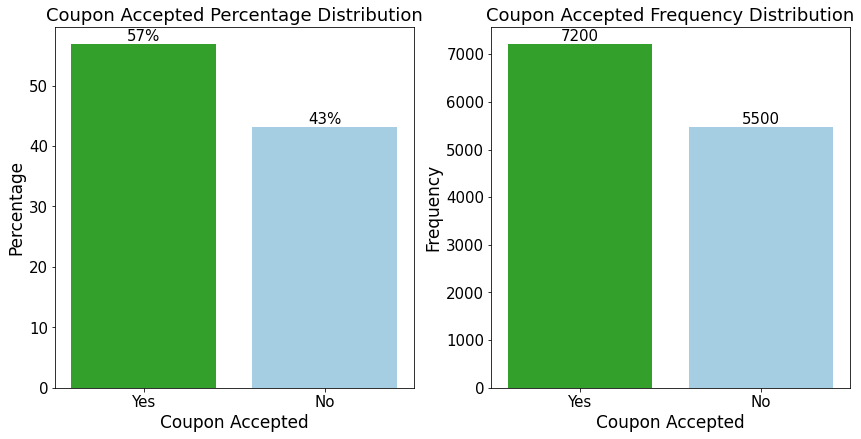

time: 244 ms (started: 2023-01-02 16:11:45 -08:00)


In [29]:
bar_orientation='vertical'
dpi=100
figure_filename = '../reports/figures/figure_coupon_accepted_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'
figure_filename_axes1 = '../reports/figures/figure_coupon_accepted_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_axes1_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'
figure_filename_axes2 = '../reports/figures/figure_coupon_accepted_percentage_and_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_axes2_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

plot_save_together_separate = 'together'

figsize=(12, 6.2)
bar_width=0.8

xlabel = 'Coupon Accepted'
ylabel = 'Percentage'
title = 'Coupon Accepted '+ str(ylabel) + ' Distribution'

target_value_dictionary = {1: 'Yes', 0:'No'}

df_Y_frequency = df.loc[:, ['Y']].value_counts().reset_index().rename(columns={0:'frequency'})
df_Y_frequency.loc[:, 'percentage'] = df_Y_frequency.loc[:, 'frequency'] / df_Y_frequency.loc[:, 'frequency'].sum(axis=0) * 100
df_Y_frequency_percentage = df_Y_frequency
del df_Y_frequency

x_label_list = df_Y_frequency_percentage.loc[:, 'Y'].replace(target_value_dictionary).to_list()


if plot_save_together_separate == 'together':
    figure, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
elif plot_save_together_separate == 'separate':
    figure1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    figure2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    

#make percentage subplot
annotation_round_by_number = 0

percentage_list = df_Y_frequency_percentage.loc[:, 'percentage'].to_list()

axes1.bar(x=x_label_list, height=percentage_list, width=bar_width, color=[color_list[3], color_list[0]])

axes1.set_title(label=title, fontsize=18)
axes1.set_xlabel(xlabel=xlabel, fontsize=17)
axes1.set_ylabel(ylabel=ylabel, fontsize=17)
axes1.tick_params(axis='both', which='major', labelsize=15)

for rectangle, annotation in zip(axes1.patches, percentage_list):
    axes1.text(rectangle.get_x() + rectangle.get_width() / 2, rectangle.get_height(), format(round(annotation, annotation_round_by_number), '.0f') + '%', ha="center", va="bottom", fontsize=15)

#make frequency subplot
ylabel = 'Frequency'
title = 'Coupon Accepted '+ str(ylabel) + ' Distribution'
annotation_round_by_number = -2

frequency_list = df_Y_frequency_percentage.loc[:, 'frequency'].to_list()

axes2.bar(x=x_label_list, height=frequency_list, width=bar_width, color=[color_list[3], color_list[0]])

axes2.set_title(label=title, fontsize=18)
axes2.set_xlabel(xlabel=xlabel, fontsize=17)
axes2.set_ylabel(ylabel=ylabel, fontsize=17)
axes2.tick_params(axis='both', which='major', labelsize=15)

for rectangle, annotation in zip(axes2.patches, frequency_list):
    axes2.text(rectangle.get_x() + rectangle.get_width() / 2, rectangle.get_height() + 5, round(annotation, annotation_round_by_number), ha="center", va="bottom", fontsize=15)

plt.tight_layout()

if plot_save_together_separate == 'together':
    figure.savefig(figure_filename, bbox_inches='tight', dpi=dpi)
elif plot_save_together_separate == 'separate':
    figure1.savefig(figure_filename_axes1, bbox_inches='tight', dpi=dpi)
    figure2.savefig(figure_filename_axes2, bbox_inches='tight', dpi=dpi)


plt.show()

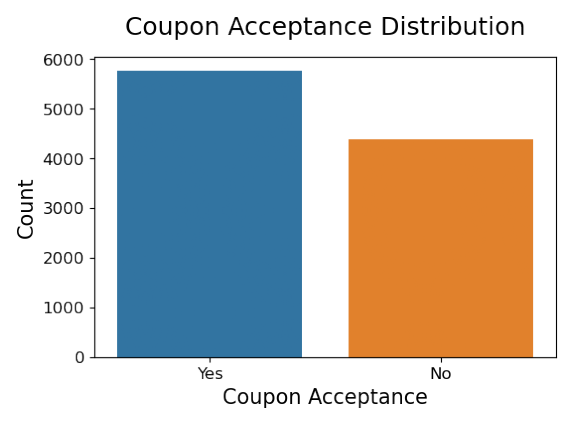

time: 66.4 ms (started: 2023-01-02 16:11:45 -08:00)


In [30]:
dpi=100
figure_filename = '../reports/figures/figure_target_variable_bar_plot_v3_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    #get Y_train data
    _, _, Y_train_plot, _ = train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=.2, random_state=200)

    #get Y_train coupon accepted and not accepted count
    df_target_plot = Y_train_plot.replace({0:'No', 1:'Yes'}).value_counts().to_frame().reset_index().rename(columns={'index':'accepted_not_accepted','Y':'count'})

    axes_object = sns.barplot(data=df_target_plot, x='accepted_not_accepted', y='count')
    axes_object.set_title('Coupon Acceptance Distribution', fontdict={'fontsize':18}, pad=16)
    #axes_object.set(xlabel='Coupon Acceptance', ylabel='Count')
    plt.xlabel('Coupon Acceptance', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.tick_params(labelsize=12)



    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)
    
plt.show()

In [31]:
#survey coupon acceptance rate
df_Y_proportion = (df.groupby(['Y'])['Y'].agg('count') / df.shape[0])
df_Y_proportion[1]

0.5684326710816777

time: 2.51 ms (started: 2023-01-02 16:11:45 -08:00)


In [32]:
#sample size, population size, margin of error, confidence interval

#intialize parameters
z_score = 1.96; confidence_interval = .95

p_value = 0.5684326710816777
margin_of_error = .0381
N_population_size = 2.4 * 10**8

#known 652 surveys accepted, https://jmlr.org/papers/volume18/16-003/16-003.pdf

#calculate sample size
sample_size = (z_score**2*p_value*(1-p_value)/margin_of_error**2)/(1+(z_score**2*p_value*(1-p_value)/margin_of_error**2/N_population_size))
print('Sample size ' + str(round(sample_size)) + ' for a '+ str(round(confidence_interval*100, None)) +'% confidence interval, margin or error ' \
      + str(margin_of_error) + ', population size ' + str(round(N_population_size)) + ', p-value ' + str(round(p_value, 5))
      + ' is less than known 652 surveys.\n')

round_by_number = None
print('Therefore, '+ str(round(confidence_interval*100, None)) +'% of the time, we expect a coupon acceptance rate between ' \
      + str(round((p_value-margin_of_error/2)*100, round_by_number)) + '% and ' \
      + str(round((p_value+margin_of_error/2)*100, round_by_number)) + '%')

Sample size 649 for a 95% confidence interval, margin or error 0.0381, population size 240000000, p-value 0.56843 is less than known 652 surveys.

Therefore, 95% of the time, we expect a coupon acceptance rate between 55% and 59%
time: 1.36 ms (started: 2023-01-02 16:11:45 -08:00)


In [33]:
#sample size, population size, margin of error, confidence interval

#intialize parameters
z_score = 1.645; confidence_interval = .90

p_value = 0.5684326710816777
margin_of_error = .032
N_population_size = 2.4 * 10**8

#known 652 surveys accepted, https://jmlr.org/papers/volume18/16-003/16-003.pdf

#calculate sample size
sample_size = (z_score**2*p_value*(1-p_value)/margin_of_error**2)/(1+(z_score**2*p_value*(1-p_value)/margin_of_error**2/N_population_size))
print('Sample size ' + str(round(sample_size)) + ' for a '+ str(round(confidence_interval*100, None)) +'% confidence interval, margin or error ' \
      + str(margin_of_error) + ', population size ' + str(round(N_population_size)) + ', p-value ' + str(round(p_value, 5))
      + ' is less than known 652 surveys.\n')

round_by_number = None
print('Therefore, '+ str(round(confidence_interval*100, None)) + '% of the time, we expect a coupon acceptance rate between ' \
      + str(round((p_value-margin_of_error/2)*100, round_by_number)) + '% and ' \
      + str(round((p_value+margin_of_error/2)*100, round_by_number)) + '%')


Sample size 648 for a 90% confidence interval, margin or error 0.032, population size 240000000, p-value 0.56843 is less than known 652 surveys.

Therefore, 90% of the time, we expect a coupon acceptance rate between 55% and 58%
time: 1.32 ms (started: 2023-01-02 16:11:45 -08:00)


In [34]:
#age, income, coffee house visit frequency --> coupon acceptace rate
df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin([2, 5]) &
       df.loc[:, 'age'].isin(['21-25', '26-30', '50+']) &
       df.loc[:, 'income'].isin(['\\$50000 - \\$62499']), :]

destination  passenger weather  temperature  time  \
431    No Urgent Place  Friend(s)   Sunny           80  10AM   
5743   No Urgent Place  Friend(s)   Sunny           80   2PM   
5395   No Urgent Place  Friend(s)   Sunny           55   2PM   
1354   No Urgent Place    Partner   Sunny           80  10AM   
1362              Home      Alone   Sunny           80   6PM   
8582              Work      Alone   Sunny           80   7AM   
1352   No Urgent Place  Friend(s)   Sunny           80   6PM   
2810   No Urgent Place  Friend(s)   Sunny           55   2PM   
2812   No Urgent Place      Alone   Sunny           55  10AM   
11371  No Urgent Place  Friend(s)   Sunny           30  10AM   
10331             Home      Alone   Snowy           30  10PM   
6779   No Urgent Place     Kid(s)   Rainy           55   6PM   
3305   No Urgent Place  Friend(s)   Sunny           55   2PM   
870    No Urgent Place    Partner   Sunny           80   6PM   
8857              Home     Kid(s)   Sunny           30   6PM   
8425              Home      Alone   Sunny           80   6PM   
8017   No Urgent Place  Friend(s)   Sunny           80   2PM   
8415   No Urgent Place  Friend(s)   Snowy           30  10PM   
2802   No Urgent Place  Friend(s)   Sunny           80  10AM   
8424              Home    Partner   Sunny           80   6PM   
8859              Home      Alone   Sunny           80   6PM   
5393   No Urgent Place  Friend(s)   Sunny           80   2PM   
5394   No Urgent Place  Friend(s)   Sunny           80   6PM   
1363              Work      Alone   Sunny           55   7AM   
2800   No Urgent Place      Alone   Sunny           55   2PM   
444               Home      Alone   Sunny           55   6PM   
3294   No Urgent Place      Alone   Sunny           55   2PM   
866    No Urgent Place    Partner   Sunny           80  10AM   
3301   No Urgent Place  Friend(s)   Sunny           80   2PM   
6351   No Urgent Place    Partner   Sunny           80  10AM   
1348   No Urgent Place  Friend(s)   Sunny           80  10AM   
8419   No Urgent Place    Partner   Rainy           55   2PM   
869    No Urgent Place    Partner   Sunny           80   6PM   
2815              Home      Alone   Sunny           80   6PM   
5675   No Urgent Place      Alone   Sunny           80  10AM   
6783   No Urgent Place      Alone   Sunny           55  10PM   
11386             Work      Alone   Snowy           30   7AM   
879               Work      Alone   Sunny           55   7AM   
8865              Work      Alone   Sunny           80   7AM   
438    No Urgent Place  Friend(s)   Sunny           80   6PM   
8028              Home      Alone   Snowy           30   6PM   
447               Work      Alone   Sunny           55   7AM   
2808   No Urgent Place  Friend(s)   Sunny           80   6PM   
10327             Home     Kid(s)   Sunny           30   6PM   
5397   No Urgent Place    Partner   Sunny           80  10AM   
8018   No Urgent Place  Friend(s)   Sunny           80   6PM   
2813              Home      Alone   Sunny           55   6PM   
5692              Work      Alone   Sunny           80   7AM   
8578              Home    Partner   Sunny           30  10PM   
8855              Home     Kid(s)   Sunny           80   6PM   
11369  No Urgent Place  Friend(s)   Sunny           80  10PM   
8561   No Urgent Place     Kid(s)   Rainy           55   6PM   
5741   No Urgent Place      Alone   Sunny           80  10AM   
5680   No Urgent Place      Alone   Sunny           80   2PM   
2818              Work      Alone   Sunny           80   7AM   
8565   No Urgent Place      Alone   Sunny           55   6PM   
5742   No Urgent Place  Friend(s)   Sunny           80  10AM   
864    No Urgent Place  Friend(s)   Sunny           55   2PM   
6795              Work      Alone   Sunny           55   7AM   
3578              Work      Alone   Sunny           55   7AM   
8426              Work      Alone   Rainy           55   7AM   
5399   No Urgent Place    Partner   Sunny  

time: 184 ms (started: 2023-01-02 16:11:45 -08:00)


In [35]:
age_list = ['21-25', '26-30', '50+']
coffee_house_monthly_visit_frequency_encoding_list = [2]
income_list = ['\\$50000 - \\$62499']

df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       df.loc[:, 'age'].isin(age_list) &
       df.loc[:, 'income'].isin(income_list), :].value_counts('Y')[1] / \
df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       df.loc[:, 'age'].isin(age_list) &
       df.loc[:, 'income'].isin(income_list), :].shape[0]



0.6753246753246753

time: 5.99 ms (started: 2023-01-02 16:11:45 -08:00)


In [36]:
age_list = ['21-25', '26-30', '50+']
coffee_house_monthly_visit_frequency_encoding_list = [2,5]
income_list = ['\\$50000 - \\$62499']


df_filtered = \
df.loc[df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       df.loc[:, 'age'].isin(age_list) &
       df.loc[:, 'income'].isin(income_list), :]

number_of_coupons_accepted = df_filtered.value_counts('Y')[1]
print(number_of_coupons_accepted)
number_of_coupons_offered = df_filtered.shape[0]
print(number_of_coupons_offered)

coupon_acceptance_rate = number_of_coupons_accepted/number_of_coupons_offered
print(coupon_acceptance_rate)

print(number_of_coupons_offered)

255
374
0.6818181818181818
374
time: 4.21 ms (started: 2023-01-02 16:11:45 -08:00)


In [37]:
#^--- our model does something similar but it actually models better for coupon acceptance rate. likely because it's a better model, 
#     but also because it uses more features


#it's less about narrowing down by demogrpahics and more about coupon acceptance rate (i.e. conversion rate) then???

#run a final model with the least number of features??





time: 477 µs (started: 2023-01-02 16:11:45 -08:00)


In [38]:
income_list = ['\\$62500 - \\$74999', '\\$75000 - \\$87499', '\\$87500 - \\$99999']
age_list = ['<21', '31-35', '36-40', '41-45', '46-49'] #
coffee_house_monthly_visit_frequency_encoding_list = [3, 4, 1, 0] #0

df_filtered = \
df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :]

number_of_coupons_accepted = df_filtered.value_counts('Y')[1]
print(number_of_coupons_accepted)
number_of_coupons_offered = df_filtered.shape[0]
print(number_of_coupons_offered)

coupon_acceptance_rate = number_of_coupons_accepted/number_of_coupons_offered
print(coupon_acceptance_rate)

print(number_of_coupons_offered)

1400
2064
0.6782945736434108
2064
time: 4.45 ms (started: 2023-01-02 16:11:45 -08:00)


In [39]:
df.loc[:, 'income'].drop_duplicates().to_list()

['\\$12500 - \\$24999',
 '\\$87500 - \\$99999',
 '\\$37500 - \\$49999',
 '\\$50000 - \\$62499',
 '\\$75000 - \\$87499',
 '\\$25000 - \\$37499',
 '\\$100000 or More',
 'Less than \\$12500',
 '\\$62500 - \\$74999']

time: 1.7 ms (started: 2023-01-02 16:11:45 -08:00)


In [40]:
{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}

{'never': 1, '<1': 2, '1-3': 3, '4-8': 4, '>8': 5, 'no response': 0}

time: 1.3 ms (started: 2023-01-02 16:11:45 -08:00)


In [41]:
df.loc[:, 'age'].drop_duplicates().to_list()

['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', '<21']

time: 1.76 ms (started: 2023-01-02 16:11:45 -08:00)


In [42]:
income_list = ['\\$62500 - \\$74999', '\\$75000 - \\$87499', '\\$87500 - \\$99999']
age_list = ['<21', '31-35', '36-40', '41-45', '46-49'] #
coffee_house_monthly_visit_frequency_encoding_list = [3, 4, 1, 0] #0

number_of_coupon_accepted = \
df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :].value_counts('Y')[1]
number_of_rows = \
df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :].shape[0]

print(str(number_of_coupon_accepted/number_of_rows))

print(df.loc[~df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].isin(coffee_house_monthly_visit_frequency_encoding_list) &
       ~df.loc[:, 'age'].isin(age_list) &
       ~df.loc[:, 'income'].isin(income_list), :].shape[0])

0.6782945736434108
2064
time: 9.01 ms (started: 2023-01-02 16:11:45 -08:00)


#### Income Frequency Distribution (Vertical Bar Plot)

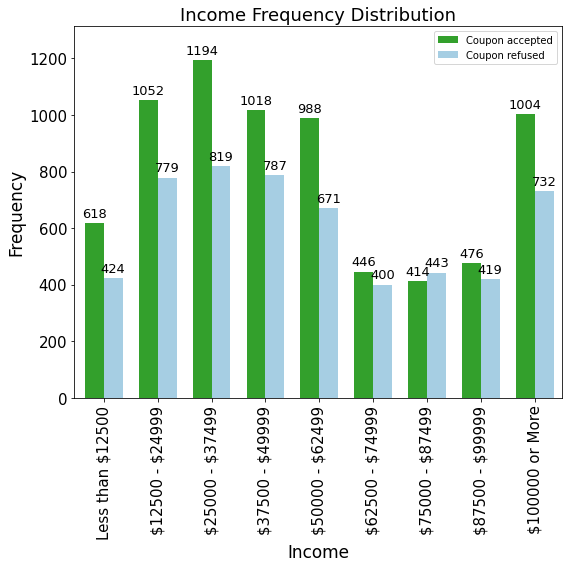

time: 319 ms (started: 2023-01-02 16:11:45 -08:00)


In [43]:
feature_column_name = 'income'
feature_column_name_label='Income'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=90

x_upper_limit=None

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, x_upper_limit=x_upper_limit)



#### Income Frequency Distribution (Horizontal Bar Plot)

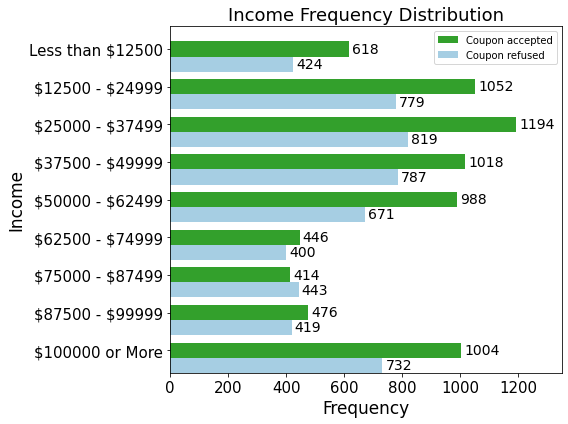

time: 310 ms (started: 2023-01-02 16:11:46 -08:00)


In [44]:
feature_column_name = 'income'
feature_column_name_label='Income'
bar_orientation = 'horizontal'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]

x_upper_limit=1350

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, x_upper_limit=x_upper_limit)



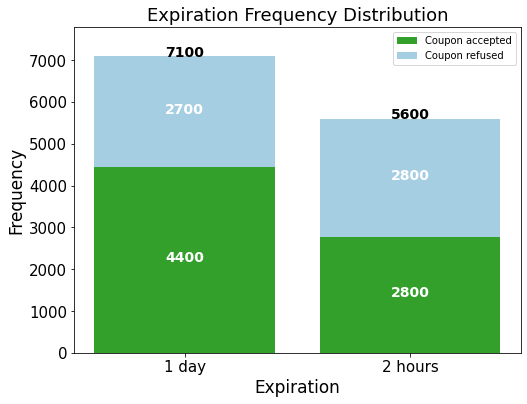

time: 170 ms (started: 2023-01-02 16:11:46 -08:00)


In [45]:
feature_column_name = 'expiration'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'frequency'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['1d', '2h']
xtick_dictionary = {'1d':'1 day', '2h':'2 hours'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]


figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number)



In [46]:
df.loc[:, 'direction_same_or_opposite']

11199    0
1474     1
10836    1
4567     1
5658     1
        ..
11343    0
9036     1
11050    0
784      0
1818     1
Name: direction_same_or_opposite, Length: 12684, dtype: int64

time: 2.63 ms (started: 2023-01-02 16:11:46 -08:00)


#### Coupon Venue Drive Direction Frequency Distribution (Stacked Bar Plot Percentage Annotation)

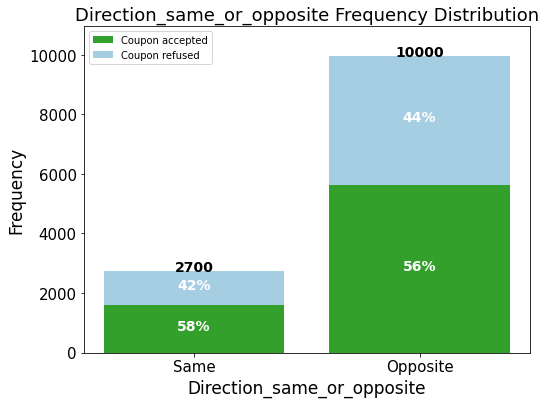

time: 156 ms (started: 2023-01-02 16:11:46 -08:00)


In [47]:
feature_column_name = 'direction_same_or_opposite'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0,1]
xtick_dictionary = {0:'Same', 1:'Opposite'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)



#### Expiration Frequency Distribution (Stacked Bar Plot Percentage Annotation)

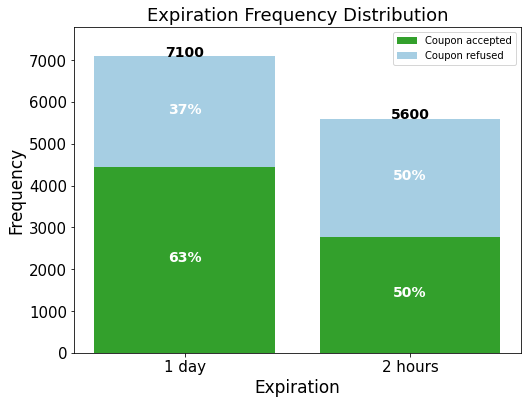

time: 162 ms (started: 2023-01-02 16:11:46 -08:00)


In [48]:
feature_column_name = 'expiration'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['1d', '2h']
xtick_dictionary = {'1d':'1 day', '2h':'2 hours'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)



#### Gender Frequency Distribution (Stacked Bar Plot Percentage Annotation)

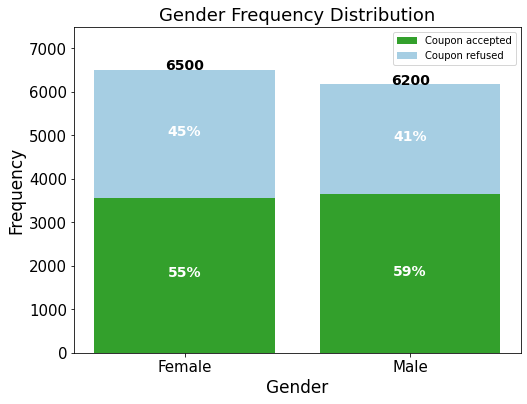

time: 154 ms (started: 2023-01-02 16:11:46 -08:00)


In [49]:
feature_column_name = 'gender'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Female','Male', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=7500

figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit)



#### Has Children Frequency Distribution (Vertical Bar Plot)

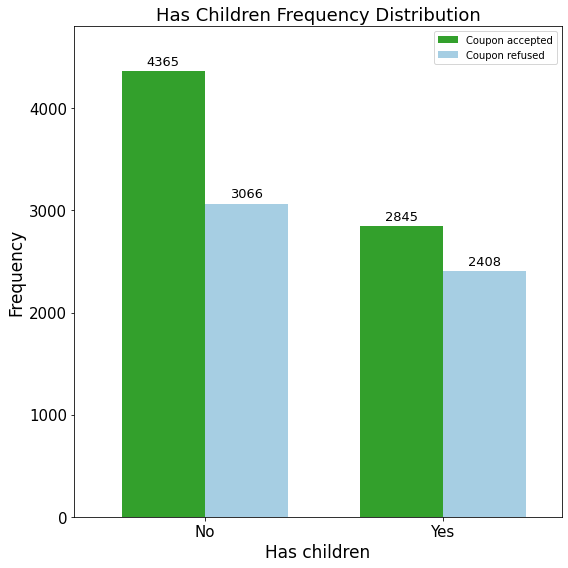

time: 160 ms (started: 2023-01-02 16:11:47 -08:00)


In [50]:
feature_column_name = 'has_children'
feature_column_name_label='Has children'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= ' '.join([word.capitalize() for word in feature_column_name_label.split(' ')]) + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



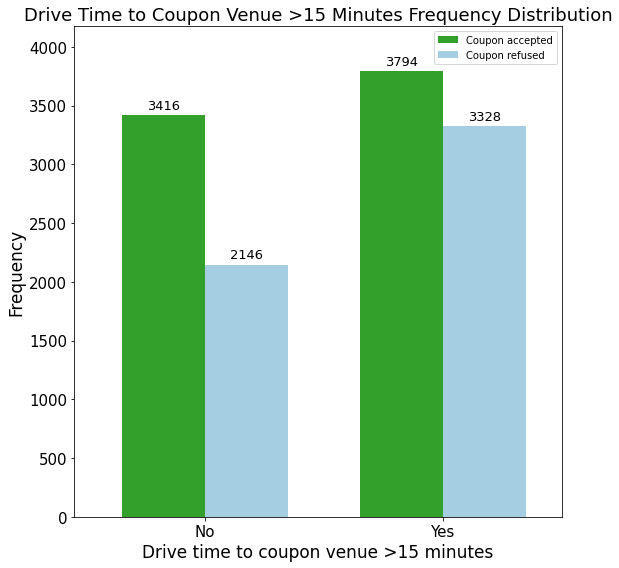

time: 194 ms (started: 2023-01-02 16:11:47 -08:00)


In [51]:
feature_column_name = 'toCoupon_GEQ15min'
feature_column_name_label='Drive time to coupon venue >15 minutes'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= 'Drive Time to Coupon Venue >15 Minutes' + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



#### Drive Time to Coupon Venue >25 Minutes Frequency Distribution (Vertical Bar Plot)

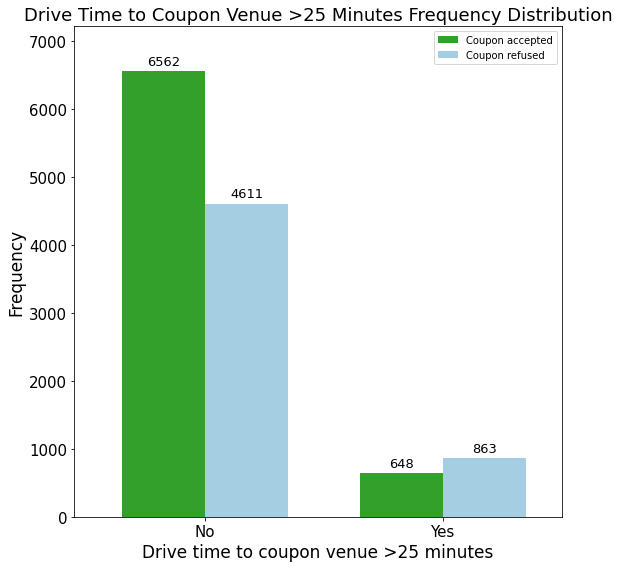

time: 177 ms (started: 2023-01-02 16:11:47 -08:00)


In [52]:
feature_column_name = 'toCoupon_GEQ25min'
feature_column_name_label='Drive time to coupon venue >25 minutes' 
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= 'Drive Time to Coupon Venue >25 Minutes' + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



#### Gender Frequency Distribution (Vertical Bar Plot)

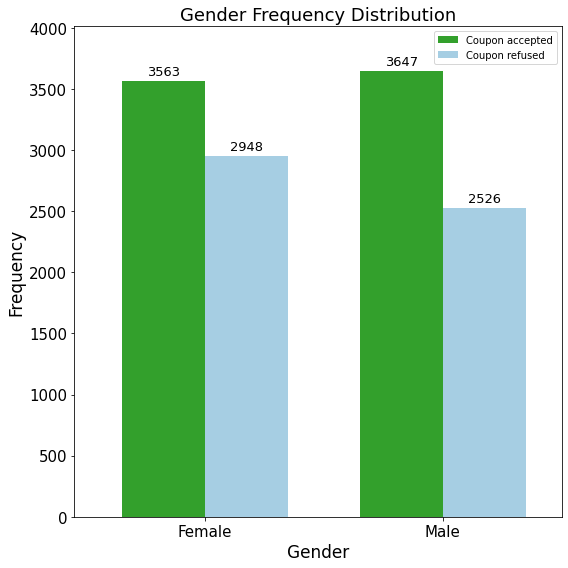

time: 173 ms (started: 2023-01-02 16:11:47 -08:00)


In [53]:
feature_column_name = 'gender'
feature_column_name_label='Gender'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = [0, 1]
feature_value_dictionary = {0:'No', 1:'Yes'}

title= 'Gender' + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=0

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, feature_value_dictionary=feature_value_dictionary)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, feature_value_dictionary=feature_value_dictionary)



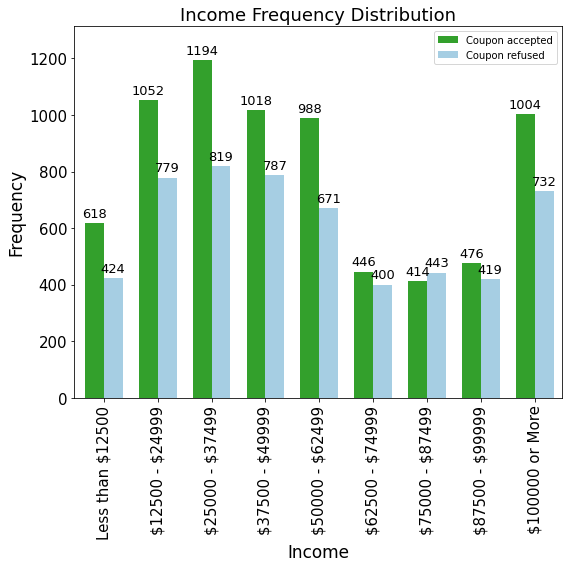

time: 292 ms (started: 2023-01-02 16:11:47 -08:00)


In [54]:
feature_column_name = 'income'
feature_column_name_label='Income'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_multiple_bar_coupon_accepted_coupon_refused_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['coupon accepted', 'coupon refused']

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]

xtick_rotation=90

if bar_orientation == 'vertical':
    figsize=(8,8)
    xlabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])
    
    icr.plot_vertical_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation)

elif bar_orientation == 'horizontal':
    figsize=(8,6)
    ylabel=feature_column_name_label

    #get column name, coupon accepted (frequency), coupon refused (frequency)
    df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name)

    #sort by value order list
    df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=False).drop(columns=[str(feature_column_name)+'_rank'])

    icr.plot_horizontal_bar_graph(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, multibar_column_name_list=multibar_column_name_list, title=title, ylabel=ylabel, figsize=figsize, color_list=color_list, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi)



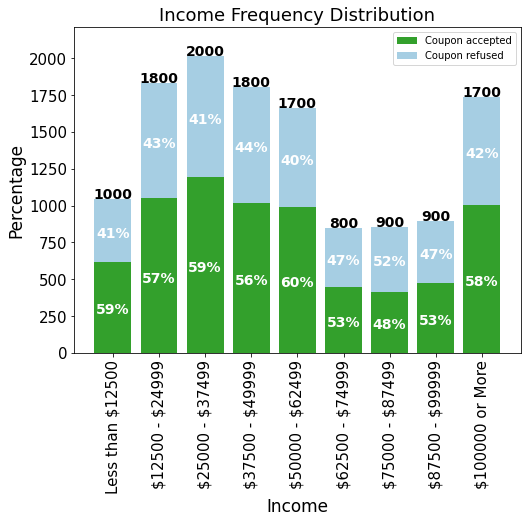

time: 300 ms (started: 2023-01-02 16:11:48 -08:00)


In [55]:
feature_column_name = 'income'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Percentage'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2
rectangle_annotation_y_offset = -45

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]


figsize=(8,8)


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



#### Income Distribution (Vertical Bar Plot and Coupon Accepted Percentage Line Plot)

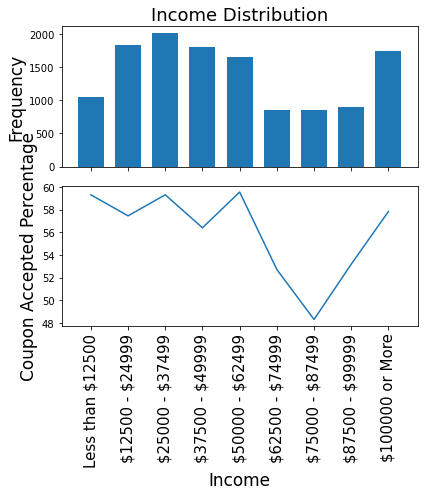

time: 249 ms (started: 2023-01-02 16:11:48 -08:00)


In [56]:
feature_column_name='income'
feature_value_order_list = ['Less than \$12500', '\$12500 - \$24999', '\$25000 - \$37499', '\$37500 - \$49999', '\$50000 - \$62499', '\$62500 - \$74999',  '\$75000 - \$87499', '\$87500 - \$99999', '\$100000 or More',]


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])


title = 'Income Distribution'
frequency_ylabel = 'Frequency'
percentage_ylabel = 'Coupon Accepted Percentage'
xlabel = feature_column_name.capitalize()
bar_orientation = 'vertical'

bar_width=.7
figsize=(6,7)
frequency_ylim=None
percentage_ylim=None

dpi=100
figure_filename = '../reports/figures/figure_income_frequency_distribution_'+ str(bar_orientation) + '_bar_plot_and_percentage_line_chart_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure, (axes1, axes2) = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', figsize=figsize)
axes1.bar(feature_value_order_list, df_income_coupon_accepted_coupon_refused.loc[:, 'total'].to_list(), width=bar_width, color=color_list[1])
axes2.plot(feature_value_order_list, df_income_coupon_accepted_coupon_refused.loc[:, 'percentage accepted'].to_list())

index_array = np.arange(len(feature_value_order_list))

axes1.set_title(title, fontsize=18)
axes1.set_ylabel(frequency_ylabel, fontsize=17)
axes2.set_ylabel(percentage_ylabel, fontsize=17)
axes2.set_xlabel(xlabel, fontsize=17)
axes2.set_xticks(ticks=index_array, labels=feature_value_order_list, rotation=90, fontsize=15)

axes1.set_ylim(frequency_ylim) if frequency_ylim != None else None
axes2.set_ylim(percentage_ylim) if percentage_ylim != None else None

plt.tight_layout()

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()


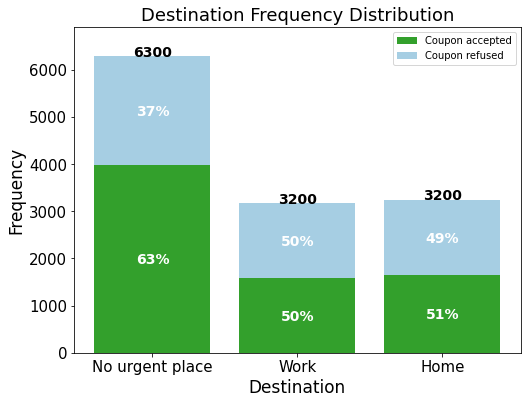

time: 172 ms (started: 2023-01-02 16:11:48 -08:00)


In [57]:
feature_column_name = 'destination'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['No Urgent Place', 'Work', 'Home']
xtick_dictionary = {'No Urgent Place':'No urgent place', 'Work':'Work', 'Home':'Home'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)
rectangle_annotation_y_offset = -100


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



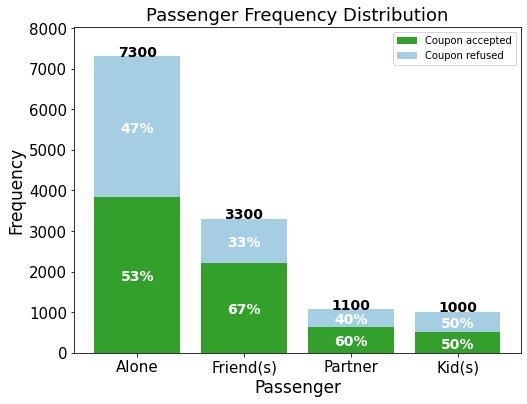

time: 186 ms (started: 2023-01-02 16:11:48 -08:00)


In [58]:
feature_column_name = 'passenger'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Alone', 'Friend(s)', 'Partner', 'Kid(s)', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-140

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



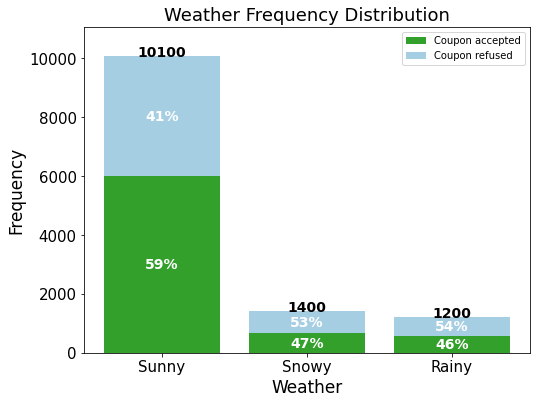

time: 159 ms (started: 2023-01-02 16:11:49 -08:00)


In [59]:
feature_column_name = 'weather'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Sunny', 'Snowy', 'Rainy', ]
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-140

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



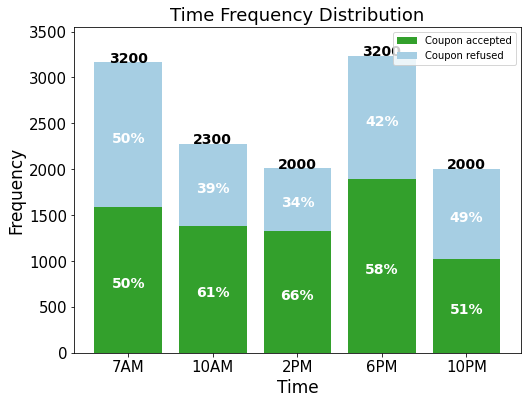

time: 202 ms (started: 2023-01-02 16:11:49 -08:00)


In [60]:
feature_column_name = 'time'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['7AM', '10AM', '2PM', '6PM', '10PM']
xtick_dictionary = None

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-80

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset)



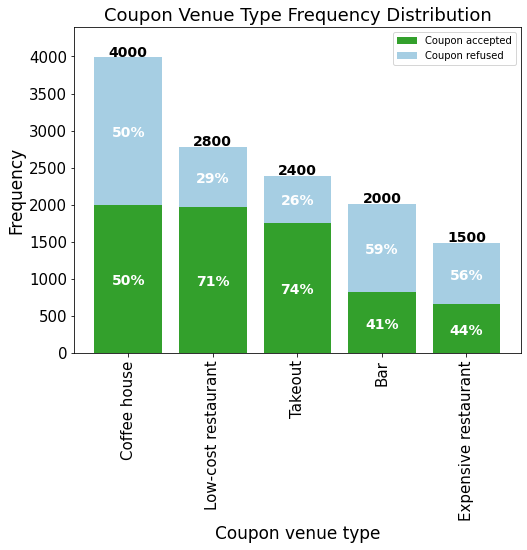

time: 218 ms (started: 2023-01-02 16:11:49 -08:00)


In [61]:
feature_column_name = 'coupon_venue_type'
feature_column_name_label='Coupon Venue Type'#feature_column_name.capitalize()
xlabel='Coupon venue type'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Coffee House', 'Restaurant(<20)', 'Carry out & Take away', 'Bar', 'Restaurant(20-50)']
xtick_dictionary = {'Coffee House':'Coffee house', 'Restaurant(<20)':'Low-cost restaurant', 'Carry out & Take away':'Takeout', 'Bar':'Bar', 'Restaurant(20-50)':'Expensive restaurant'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-80

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



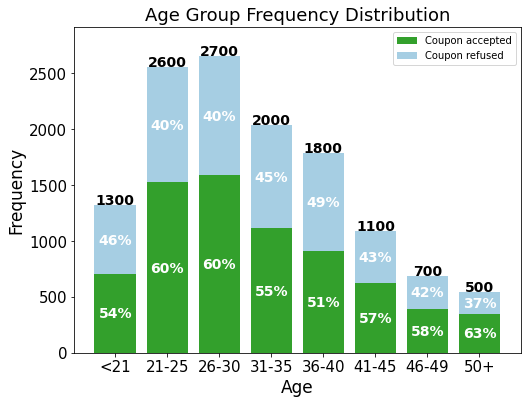

time: 233 ms (started: 2023-01-02 16:11:49 -08:00)


In [62]:
feature_column_name = 'age'
feature_column_name_label='Age Group'#feature_column_name.capitalize()
xlabel='Age'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['<21', '21-25', '26-30', '31-35', '36-40', '41-45', '46-49', '50+']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-40

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



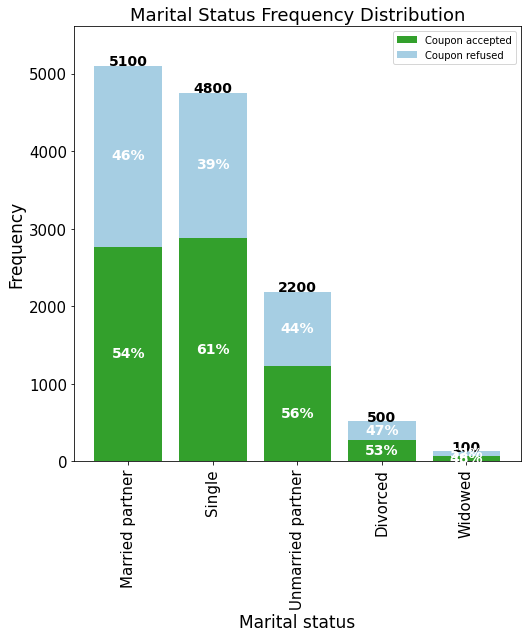

time: 210 ms (started: 2023-01-02 16:11:49 -08:00)


In [63]:
feature_column_name = 'maritalStatus'
feature_column_name_label='Marital Status'#feature_column_name.capitalize()
xlabel='Marital status'#feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Married partner', 'Single', 'Unmarried partner', 'Divorced', 'Widowed']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-40

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



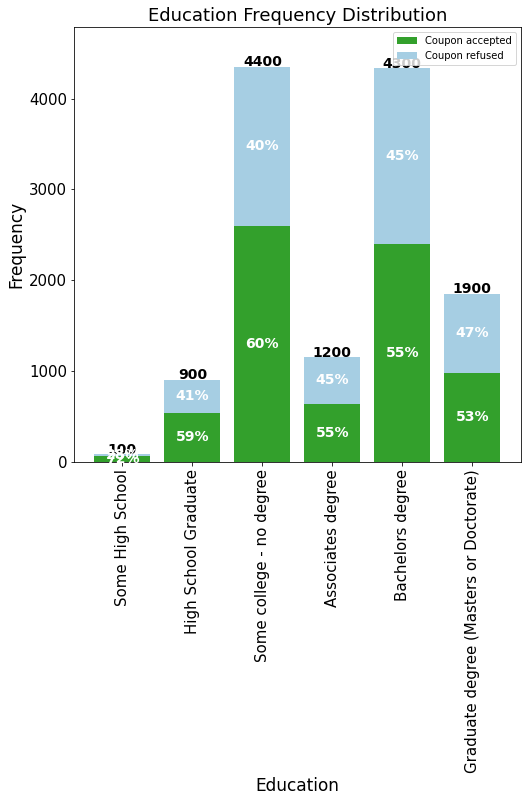

time: 239 ms (started: 2023-01-02 16:11:50 -08:00)


In [64]:
feature_column_name = 'education'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)',]
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,8)

rectangle_annotation_y_offset=-40

#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=14, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize)



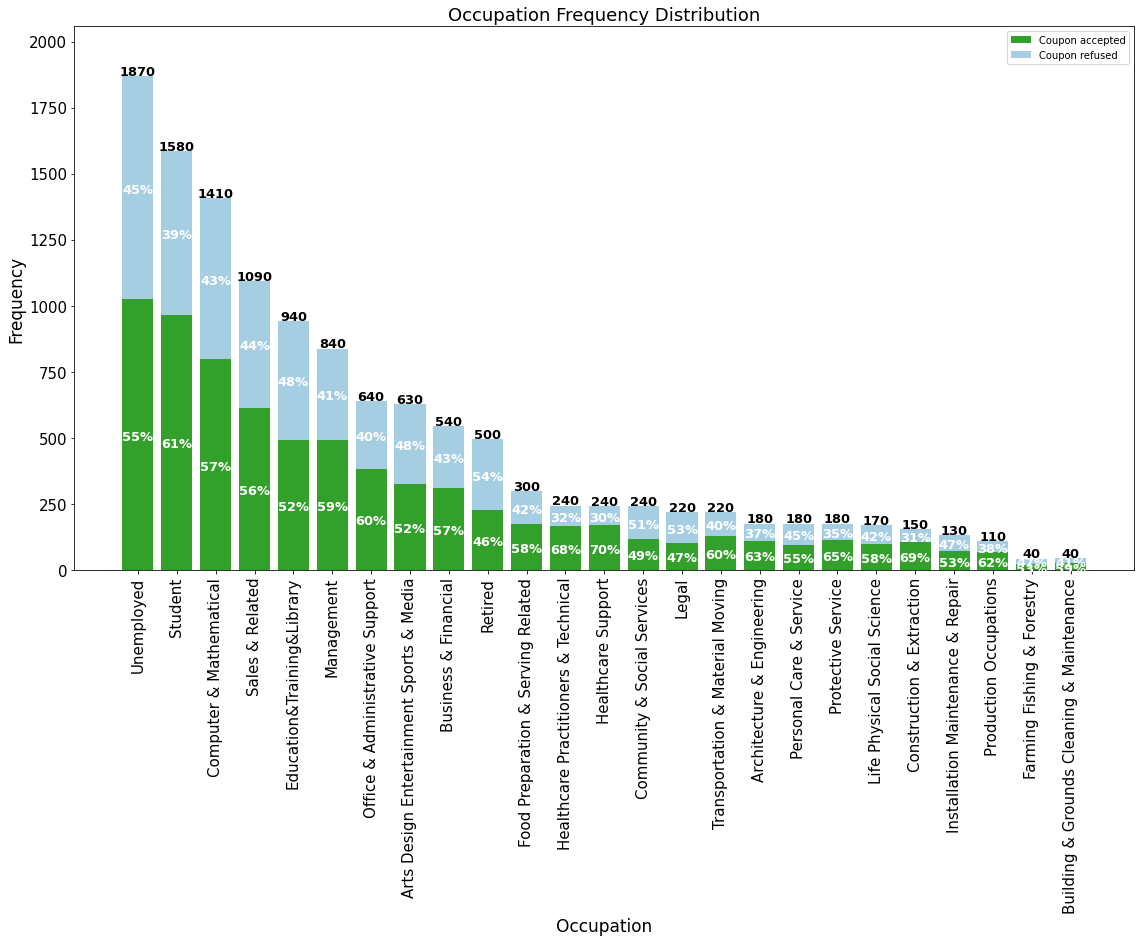

time: 784 ms (started: 2023-01-02 16:11:50 -08:00)


In [65]:
feature_column_name = 'occupation'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-1

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = \
['Unemployed', 'Student', 'Computer & Mathematical', 'Sales & Related', 'Education&Training&Library', 'Management', 
 'Office & Administrative Support', 'Arts Design Entertainment Sports & Media',
 'Business & Financial', 'Retired', 'Food Preparation & Serving Related', 'Healthcare Practitioners & Technical',
 'Healthcare Support', 'Community & Social Services', 'Legal', 'Transportation & Material Moving',
 'Architecture & Engineering', 'Personal Care & Service', 'Protective Service', 'Life Physical Social Science',
 'Construction & Extraction', 'Installation Maintenance & Repair', 'Production Occupations', 'Farming Fishing & Forestry',
 'Building & Grounds Cleaning & Maintenance']

xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(19,10)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



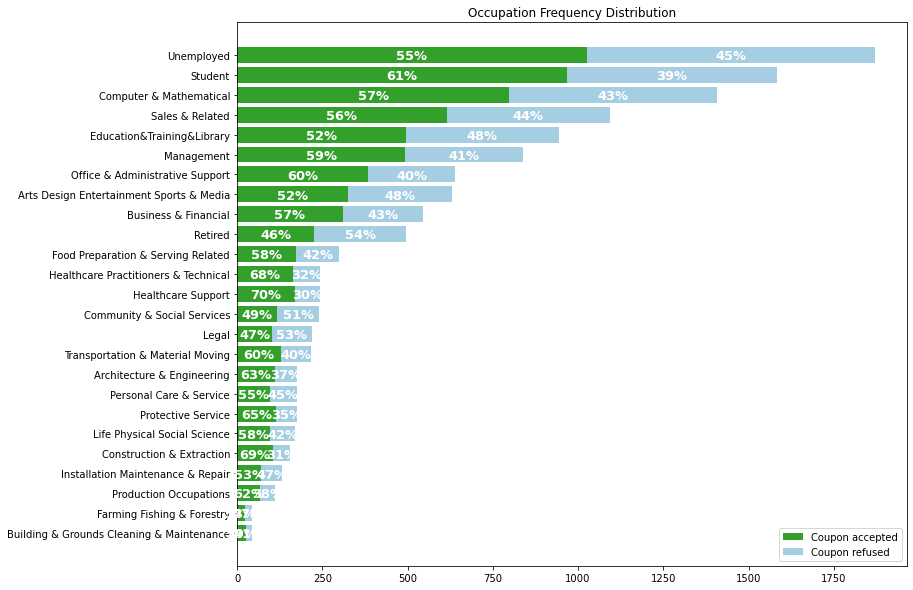

time: 275 ms (started: 2023-01-02 16:11:51 -08:00)


In [66]:
feature_column_name = 'occupation'
feature_column_name_label=feature_column_name.capitalize()
xlabel=feature_column_name_label
ylabel='Frequency'

xtick_rotation=90
bar_orientation = 'vertical'
annotation_type = 'percentage'
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = ['Building & Grounds Cleaning & Maintenance', 'Farming Fishing & Forestry', 'Production Occupations', 'Installation Maintenance & Repair', 'Construction & Extraction', 'Life Physical Social Science', 'Protective Service', 'Personal Care & Service', 'Architecture & Engineering', 'Transportation & Material Moving', 'Legal', 'Community & Social Services', 'Healthcare Support', 'Healthcare Practitioners & Technical', 'Food Preparation & Serving Related', 'Retired', 'Business & Financial', 'Arts Design Entertainment Sports & Media', 'Office & Administrative Support', 'Management', 'Education&Training&Library', 'Sales & Related', 'Computer & Mathematical', 'Student', 'Unemployed']
xtick_dictionary = None #{}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

x_upper_limit=None

figsize=(12,10)

rectangle_annotation_y_offset=-0.21
annotation_text_size=13


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)


icr.plot_horizontal_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, figsize=figsize, rectangle_annotation_y_offset=rectangle_annotation_y_offset, annotation_text_size=annotation_text_size, x_upper_limit=x_upper_limit, color_list=color_list, title=title)




#### Bar Monthly Visit Frequency Frequency Distribution

In [67]:
icr.reverse_key_value_of_dictionary({'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0})


{1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

time: 1.68 ms (started: 2023-01-02 16:11:51 -08:00)


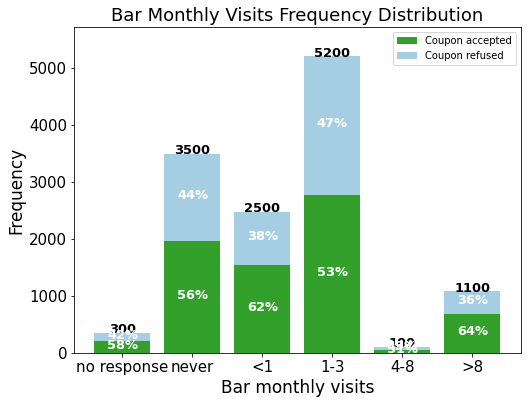

time: 195 ms (started: 2023-01-02 16:11:51 -08:00)


In [68]:
feature_column_name = 'Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Bar Monthly Visits'
xlabel='Bar monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



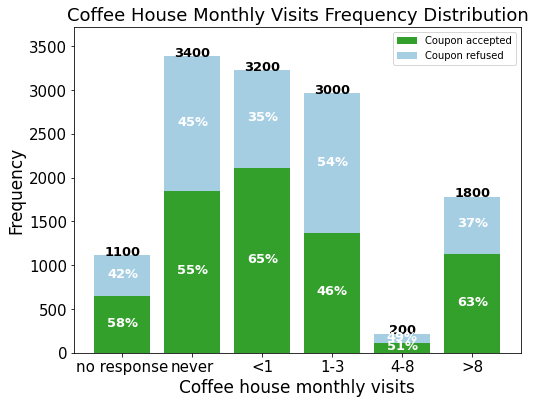

time: 204 ms (started: 2023-01-02 16:11:51 -08:00)


In [69]:
feature_column_name = 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Coffee House Monthly Visits'
xlabel='Coffee house monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



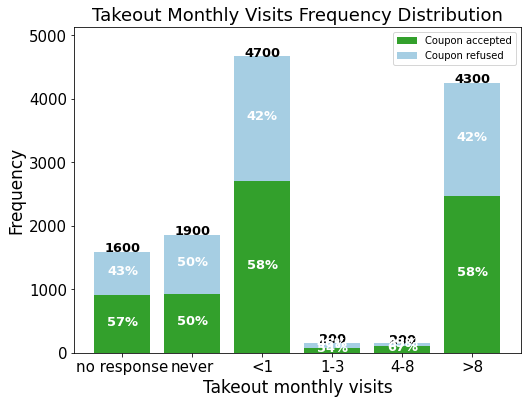

time: 192 ms (started: 2023-01-02 16:11:51 -08:00)


In [70]:
feature_column_name = 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Takeout Monthly Visits'
xlabel='Takeout monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



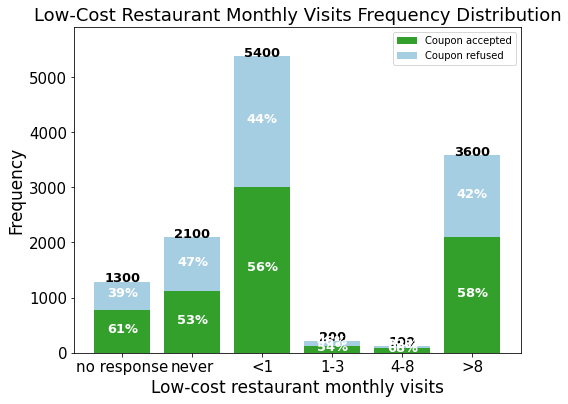

time: 205 ms (started: 2023-01-02 16:11:52 -08:00)


In [71]:
feature_column_name = 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Low-Cost Restaurant Monthly Visits'
xlabel='Low-cost restaurant monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



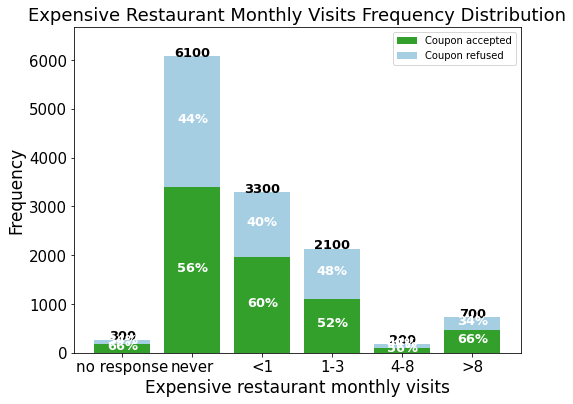

time: 213 ms (started: 2023-01-02 16:11:52 -08:00)


In [72]:
feature_column_name = 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding'
feature_column_name_label='Expensive Restaurant Monthly Visits'
xlabel='Expensive restaurant monthly visits'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [0, 1, 2, 3, 4, 5]
xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



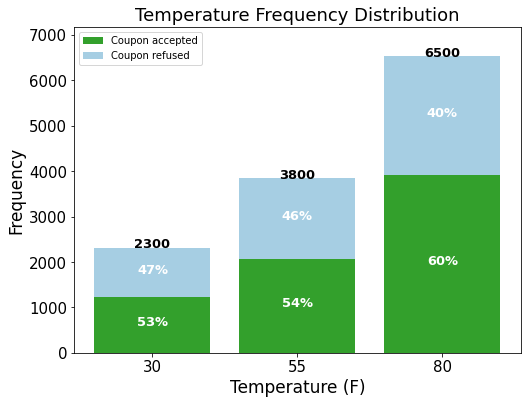

time: 158 ms (started: 2023-01-02 16:11:52 -08:00)


In [73]:
feature_column_name = 'temperature_ordinal_integer_encoding'
feature_column_name_label='Temperature'
xlabel='Temperature (F)'
ylabel='Frequency'

xtick_rotation=0
bar_orientation = 'vertical'
annotation_type = 'percentage'
annotation_text_size = 13
frequency_annotation_round_by_number=-2

dpi=100
figure_filename = '../reports/figures/figure_'+ str(feature_column_name) +'_frequency_distribution_'+ str(bar_orientation) + '_stacked_bar_coupon_accepted_coupon_refused_'+ str(annotation_type) + '_annotation_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

feature_value_order_list = [1, 2, 3,]
xtick_dictionary = {1: 30, 2: 55, 3: 80,}


title= str(feature_column_name_label) + ' Frequency Distribution'

color_index_list=[3,0]
colors = [color_list[color_index_list[0]], color_list[color_index_list[1]]]

y_upper_limit=None

figsize=(8,6)

rectangle_annotation_y_offset=-20


#get column name, coupon accepted (frequency), coupon refused (frequency)
df_income_coupon_accepted_coupon_refused = icr.get_feature_target_frequency_data_frame(df, feature_column_name=feature_column_name, append_percentage_true_false=True)

#sort by value order list
df_income_coupon_accepted_coupon_refused = icr.sort_data_frame(df=df_income_coupon_accepted_coupon_refused, feature_column_name=feature_column_name, feature_value_order_list=feature_value_order_list, ascending_true_false=True).drop(columns=[str(feature_column_name)+'_rank'])

#index feature column
df_index_income_coupon_refused_coupon_accepted = df_income_coupon_accepted_coupon_refused.set_index(feature_column_name)

icr.plot_vertical_stacked_bar_graph(df=df_index_income_coupon_refused_coupon_accepted, feature_column_name=feature_column_name, feature_column_name_label=feature_column_name_label, ylabel=ylabel, xlabel=xlabel, figure_filename=figure_filename, annotation_text_size=annotation_text_size, dpi=dpi, xtick_dictionary=xtick_dictionary, colors=colors, annotation_type=annotation_type, frequency_annotation_round_by_number=frequency_annotation_round_by_number, y_upper_limit=y_upper_limit, rectangle_annotation_y_offset=rectangle_annotation_y_offset, figsize=figsize, xtick_rotation=xtick_rotation)



#### Venue Monthly Visits Frequency Distribution

In [74]:
column_name_list = ['Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding',]

df_bar_coffee_house_takeout_low_cost_restaurant_expensive_restaurant_monthly_visits_frequency = df.loc[:, column_name_list].apply(pd.Series.value_counts).reset_index().rename(columns={'index':'feature_value'})
df_bar_coffee_house_takeout_low_cost_restaurant_expensive_restaurant_monthly_visits_frequency


feature_value  \
0              0   
1              1   
2              2   
3              3   
4              4   
5              5   

   Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding  \
0                                                              349   
1                                                             3482   
2                                                             2473   
3                                                             5197   
4                                                              107   
5                                                             1076   

   CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding  \
0                                                                     1111   
1                                                                     3385   
2                                                                     3225   
3                                                                     2962   
4                                                                      217   
5                                                                     1784   

   CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding  \
0                                                                   1594   
1                                                                   1856   
2                                                                   4672   
3                                                                    153   
4                                                                    151   
5                                                                   4258   

   RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding  \
0                                                                              1285   
1                                                                              2093   
2                                                                              5376   
3                                                                               220   
4                                                                               130   
5                                                                              3580   

   Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding  
0                                                                           264  
1                                                                          6077  
2                                                                          3290  
3                                                                          2136  
4                                                                           189  
5                                                                           728

time: 8.13 ms (started: 2023-01-02 16:11:52 -08:00)


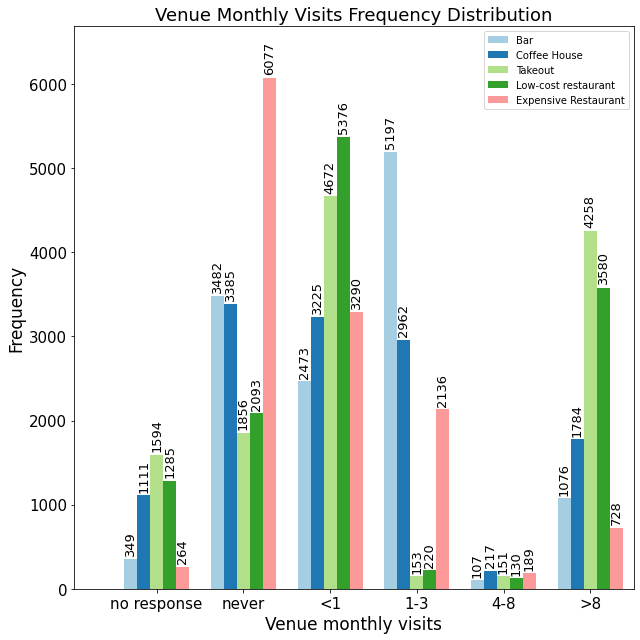

time: 413 ms (started: 2023-01-02 16:11:52 -08:00)


In [75]:
name1='venue_monthly_visits'
bar_orientation = 'vertical'

dpi=100
figure_filename = '../reports/figures/figure_'+ str(name1) +'_frequency_distribution_'+ str(bar_orientation) + 'multibar_plot_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

multibar_column_name_list=['Bar_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'CarryAway_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'RestaurantLessThan20_venue_visit_frequency_yes_response_ordinal_integer_encoding', 'Restaurant20To50_venue_visit_frequency_yes_response_ordinal_integer_encoding']

bar_label_list = ['Bar', 'Coffee House', 'Takeout', 'Low-cost restaurant', 'Expensive Restaurant']


xlabel_column_name='feature_value'
feature_value_order_list = [0, 1, 2, 3, 4, 5]

xlabel='Venue monthly visits'


title= ''.join([word.capitalize() + ' ' for word in xlabel.split(' ')]) + 'Frequency Distribution'

xtick_dictionary = {1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

color_index_list=[0, 1, 2, 3, 4, 5]

xtick_rotation=0

x_upper_limit=None

figsize=(9,9)


if bar_orientation == 'vertical':
    
    icr.plot_vertical_multibar_bar_graph(df=df_bar_coffee_house_takeout_low_cost_restaurant_expensive_restaurant_monthly_visits_frequency, xlabel_column_name=xlabel_column_name, multibar_column_name_list=multibar_column_name_list, title=title, xlabel=xlabel,color_list=color_list, figsize=figsize, color_index_list=color_index_list, figure_filename=figure_filename, dpi=dpi, xtick_rotation=xtick_rotation, xtick_dictionary=xtick_dictionary, bar_label_list=bar_label_list)



In [76]:
color_list[0:6]

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']

time: 1.37 ms (started: 2023-01-02 16:11:53 -08:00)


In [77]:

# category_names = ['Strongly disagree', 'Disagree', 'Neither agree nor disagree', 'Agree', 'Strongly agree']
# results = {'Question 1': [10, 15, 17, 32, 26], 'Question 2': [26, 22, 29, 10, 13], 'Question 3': [35, 37, 7, 2, 19], 'Question 4': [32, 11, 9, 15, 33], 'Question 5': [21, 29, 5, 5, 40], 'Question 6': [8, 19, 5, 30, 38]}

# height=1
# figsize=(9.2, 5)

# color = color_list[0:6]

# def survey(results, category_names, figsize=None, height=None, color_list=None, color=None):

#     labels = list(results.keys())
#     data = np.array(list(results.values()))
#     data_cum = data.cumsum(axis=1)
#     print(data_cum)

#     fig, ax = plt.subplots(figsize=(9.2, 5))
#     ax.invert_yaxis()
#     ax.xaxis.set_visible(False)
#     ax.set_xlim(0, np.sum(data, axis=1).max())

#     for i, (colname, color) in enumerate(zip(category_names, color_list[0:6])):
#         widths = data[:, i]
#         starts = data_cum[:, i] - widths
#         rects = ax.barh(labels, widths, left=starts, height=height, label=colname, color=color)

#         r, g, b, _ = color
#         text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
#         ax.bar_label(rects, label_type='center', color=text_color)
#     ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
#               loc='lower left', fontsize='small')

#     return fig, ax

# survey(results=results, category_names=category_names, height=height, figsize=figsize, color_list=color_list)
# plt.show()

time: 741 µs (started: 2023-01-02 16:11:53 -08:00)


[[0.89888504 0.30549789 0.20676663 1.        ]
 [0.99315648 0.73233372 0.42237601 1.        ]
 [0.99707805 0.9987697  0.74502115 1.        ]
 [0.70196078 0.87297193 0.44867359 1.        ]
 [0.24805844 0.66720492 0.3502499  1.        ]]


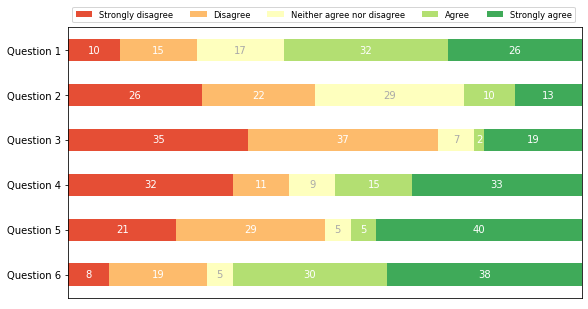

time: 131 ms (started: 2023-01-02 16:11:53 -08:00)


In [78]:

category_names = ['Strongly disagree', 'Disagree', 'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {'Question 1': [10, 15, 17, 32, 26], 'Question 2': [26, 22, 29, 10, 13], 'Question 3': [35, 37, 7, 2, 19], 'Question 4': [32, 11, 9, 15, 33], 'Question 5': [21, 29, 5, 5, 40], 'Question 6': [8, 19, 5, 30, 38]}

height=0.5
figsize=(9.2, 5)

def survey(results, category_names, figsize=None, height=None, color_list=None, color=None):

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))
    print(category_colors)

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=height, label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

survey(results=results, category_names=category_names, height=height, figsize=figsize)
plt.show()

In [79]:
#horizontal stacked bar plot
#https://stackoverflow.com/questions/63135395/how-to-plot-a-horizontal-stacked-bar-with-annotations


time: 479 µs (started: 2023-01-02 16:11:53 -08:00)


In [80]:
#what are we predicting and what are the most important ways for segmenting what we are predicting?? 
#for example, we are predicting "coupon acceptance" and want to segment by coupon type. do we know acceptance type, i.e. use it immediately or use it later??? (no).

#what are the most important features for segmenting our predictions as categories???

#in the results we could segment predictions by 

time: 881 µs (started: 2023-01-02 16:11:53 -08:00)


In [81]:
#get plots for all the features


time: 342 µs (started: 2023-01-02 16:11:53 -08:00)


In [82]:
#take top features and check for statistical significant between them by response, i.e. did accept or did not accept coupon.

top_feature = 'expiration_category_representative_numeric_encoding'

df_expiration_category_representative_numeric_encoding_Y_coupon_not_accepted = df.loc[df.loc[:, 'Y'] == 0, [top_feature] + ['Y']]
df_expiration_category_representative_numeric_encoding_Y_coupon_accepted = df.loc[df.loc[:, 'Y'] == 1, [top_feature] + ['Y']]

time: 5.03 ms (started: 2023-01-02 16:11:53 -08:00)


In [83]:
#Proportion Hypothesis Tests for Binary Data

#https://statisticsbyjim.com/hypothesis-testing/comparing-hypothesis-tests-data-types/

#2 Proportions test to compare two samples

#1 Proportion test example: comparison to a target

time: 469 µs (started: 2023-01-02 16:11:53 -08:00)


In [84]:
df_expiration_category_representative_numeric_encoding_Y_coupon_not_accepted.value_counts()

expiration_category_representative_numeric_encoding  Y
2                                                    0    2819
24                                                   0    2655
dtype: int64

time: 3.27 ms (started: 2023-01-02 16:11:53 -08:00)


In [85]:
df_expiration_category_representative_numeric_encoding_Y_coupon_accepted.value_counts()

expiration_category_representative_numeric_encoding  Y
24                                                   1    4436
2                                                    1    2774
dtype: int64

time: 3.38 ms (started: 2023-01-02 16:11:53 -08:00)


In [86]:
4436 / (4436 + 2774)

0.615256588072122

time: 1.71 ms (started: 2023-01-02 16:11:53 -08:00)


In [87]:
#of scenarios where the the coupon is accepted, 61.5% of the time, it's a 24hours til expiration 

time: 424 µs (started: 2023-01-02 16:11:53 -08:00)


<BarContainer object of 5 artists>

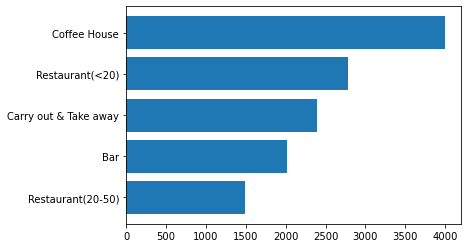

time: 62.6 ms (started: 2023-01-02 16:11:53 -08:00)


In [88]:
df_coupon_venue_type_count = df.loc[:, 'coupon_venue_type'].value_counts(ascending=True)

plt.barh(y=df_coupon_venue_type_count.index, width=df_coupon_venue_type_count.values)


In [89]:
df_Y_coupon_venue_type_count = df.groupby(['Y', 'coupon_venue_type']).count().iloc[:, 0].reset_index().rename(columns={'destination':'coupon_venue_type_count'})
df_Y_coupon_venue_type_count


Y      coupon_venue_type  coupon_venue_type_count
0  0                    Bar                     1190
1  0  Carry out & Take away                      633
2  0           Coffee House                     2001
3  0      Restaurant(20-50)                      834
4  0        Restaurant(<20)                      816
5  1                    Bar                      827
6  1  Carry out & Take away                     1760
7  1           Coffee House                     1995
8  1      Restaurant(20-50)                      658
9  1        Restaurant(<20)                     1970

time: 28.9 ms (started: 2023-01-02 16:11:53 -08:00)


In [90]:
df_coupon_venue_type_refused_accepted_coupon_count = \
df_Y_coupon_venue_type_count.pivot(index='coupon_venue_type', columns='Y', values='coupon_venue_type_count').rename(columns={0:'Refused Coupon', 1:'Accepted Coupon'}).reset_index()

df_coupon_venue_type_refused_accepted_coupon_count = df_coupon_venue_type_refused_accepted_coupon_count.loc[:, ['coupon_venue_type', 'Accepted Coupon', 'Refused Coupon']]

df_coupon_venue_type_refused_accepted_coupon_count


Y      coupon_venue_type  Accepted Coupon  Refused Coupon
0                    Bar              827            1190
1  Carry out & Take away             1760             633
2           Coffee House             1995            2001
3      Restaurant(20-50)              658             834
4        Restaurant(<20)             1970             816

time: 6.35 ms (started: 2023-01-02 16:11:53 -08:00)


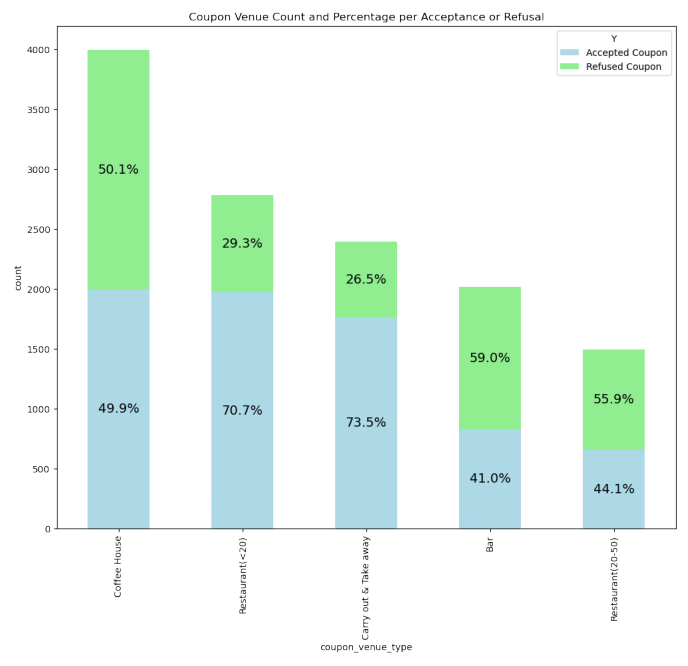

time: 139 ms (started: 2023-01-02 16:11:53 -08:00)


In [91]:
#order the coupon venue type by total count
coupon_venue_type_list = ['Coffee House', 'Restaurant(<20)','Carry out & Take away', 'Bar', 'Restaurant(20-50)', ]
coupon_venue_type_index_dictionary = dict(zip(coupon_venue_type_list, range(len(coupon_venue_type_list))))
df_coupon_venue_type_refused_accepted_coupon_count.loc[:, 'coupon_venue_type_rank'] = df_coupon_venue_type_refused_accepted_coupon_count.loc[:, 'coupon_venue_type'].map(coupon_venue_type_index_dictionary)
df_coupon_venue_type_refused_accepted_coupon_count = df_coupon_venue_type_refused_accepted_coupon_count.sort_values(['coupon_venue_type_rank', ], ascending=[True]).drop(columns='coupon_venue_type_rank')




#get stacked bar plot of coupon venue type acceptance and refusal
dpi=100
figure_filename = '../reports/figures/figure_bar_count_percentage_stacked_coupon_venue_accepted_refused_ordered_by_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

color_list=['lightblue', 'lightgreen']
#color_list=['#8c6bb1', '#41ab5d']

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(15, 12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    icr.plot_bar_graph(df=df_coupon_venue_type_refused_accepted_coupon_count, 
                   x='coupon_venue_type', 
                   bar_category_list=['Refused Coupon', 'Accepted Coupon'], 
                   title='Coupon Venue Count and Percentage per Acceptance or Refusal', 
                   color=color_list, 
                   figsize=(12, 10),
                   figure_filename=figure_filename,
                   dpi=dpi)

plt.show()

In [92]:
#get accepted coupon rate
df_coupon_venue_type_accepted_coupon_rate = df_coupon_venue_type_refused_accepted_coupon_count.loc[:, 'Accepted Coupon'] / (df_coupon_venue_type_refused_accepted_coupon_count.loc[:, 'Accepted Coupon'] + df_coupon_venue_type_refused_accepted_coupon_count.loc[:, 'Refused Coupon']) * 100
df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate = pd.concat([df_coupon_venue_type_refused_accepted_coupon_count, df_coupon_venue_type_accepted_coupon_rate.to_frame().rename(columns={0:'Accepted Coupon Rate'})], axis=1)
del df_coupon_venue_type_accepted_coupon_rate

df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate

coupon_venue_type  Accepted Coupon  Refused Coupon  \
2           Coffee House             1995            2001   
4        Restaurant(<20)             1970             816   
1  Carry out & Take away             1760             633   
0                    Bar              827            1190   
3      Restaurant(20-50)              658             834   

   Accepted Coupon Rate  
2             49.924925  
4             70.710696  
1             73.547848  
0             41.001487  
3             44.101877

time: 5.42 ms (started: 2023-01-02 16:11:53 -08:00)


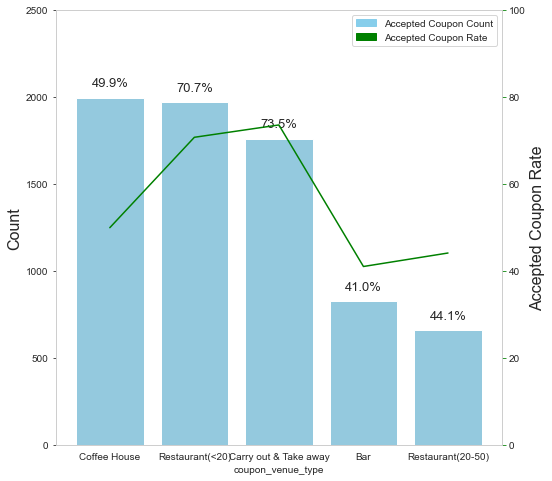

time: 155 ms (started: 2023-01-02 16:11:53 -08:00)


In [93]:
#^--- show just acceptance rate???

sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(8, 8))

color='skyblue'
bar2 = sns.barplot(x='coupon_venue_type', y='Accepted Coupon', data=df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate, estimator=sum, color=color)

ylabel_fontsize=16
ylabel_name='Count'
bar2.set_ylabel(ylabel_name, fontsize=ylabel_fontsize)

#add legend
patch_color=color#'r'
patch_label='Accepted Coupon Count'
bottom_bar = mpatches.Patch(color=patch_color, label=patch_label)
line_bar = mpatches.Patch(color='green', label='Accepted Coupon Rate')
plt.legend(handles=[bottom_bar, line_bar])

for patch, accepted_coupon_rate in zip(bar2.patches, df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate.loc[:, 'Accepted Coupon Rate']):
    bar2.annotate(format(accepted_coupon_rate, '.1f') + '%', (patch.get_x() + patch.get_width() / 2., patch.get_height() + 150), ha='center', va='center', size=13, xytext=(0, -12), textcoords='offset points')

bar2.set_ylim([0, 2500]) 

ax2 = bar2.twinx()
color = 'green'

ax2.set_ylabel('Accepted Coupon Rate', fontsize=16)
ax2 = sns.lineplot(x='coupon_venue_type', y='Accepted Coupon Rate', data=df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate, sort=False, color=color, legend='full')
ax2.tick_params(axis='y', color=color)
ax2.set_ylim([0, 100])


#https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950

plt.show()

In [94]:
#^---side by side accepted count refusal count bar graph???


#why is the a large count for some coup venue types and not others?

#if we do not know why, then what can we conclude??

#what do we know about the existing coupon market????



time: 690 µs (started: 2023-01-02 16:11:53 -08:00)


### Bar Plot Coupon Accepted Rate

### Initialize Variables

In [95]:
index_name_list = [1, 4, 2, 3, 0]
index_name_list.reverse()
index_name_list_reversed = index_name_list.copy()
index_name_list.reverse()

index_name_list_reversed

[0, 3, 2, 4, 1]

time: 1.65 ms (started: 2023-01-02 16:11:53 -08:00)


In [96]:
df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_ordered = df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate.loc[index_name_list,:]
df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_ordered


coupon_venue_type  Accepted Coupon  Refused Coupon  \
1  Carry out & Take away             1760             633   
4        Restaurant(<20)             1970             816   
2           Coffee House             1995            2001   
3      Restaurant(20-50)              658             834   
0                    Bar              827            1190   

   Accepted Coupon Rate  
1             73.547848  
4             70.710696  
2             49.924925  
3             44.101877  
0             41.001487

time: 3.77 ms (started: 2023-01-02 16:11:53 -08:00)


In [97]:
df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_reverse_ordered = df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_ordered.loc[index_name_list_reversed,:]
df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_reverse_ordered


coupon_venue_type  Accepted Coupon  Refused Coupon  \
0                    Bar              827            1190   
3      Restaurant(20-50)              658             834   
2           Coffee House             1995            2001   
4        Restaurant(<20)             1970             816   
1  Carry out & Take away             1760             633   

   Accepted Coupon Rate  
0             41.001487  
3             44.101877  
2             49.924925  
4             70.710696  
1             73.547848

time: 4.07 ms (started: 2023-01-02 16:11:53 -08:00)


### Coupon Acceptance Rate Per Coupon Venue

Text(0, 0.5, 'Coupon Venue Type')

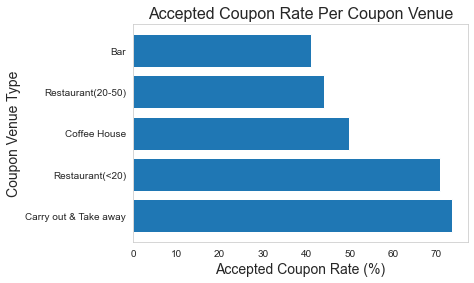

time: 92.1 ms (started: 2023-01-02 16:11:53 -08:00)


In [98]:
#law of large numbers for converting on true percentage???

plt.barh(y=df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_ordered.loc[:, 'coupon_venue_type'], width=df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_ordered.loc[:, 'Accepted Coupon Rate'])
plt.title('Accepted Coupon Rate Per Coupon Venue', fontsize=16)
plt.xlabel('Accepted Coupon Rate (%)', fontsize=14)
plt.ylabel('Coupon Venue Type', fontsize=14)


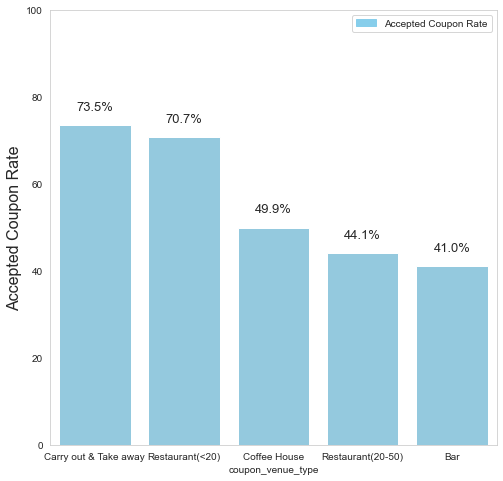

time: 93.6 ms (started: 2023-01-02 16:11:53 -08:00)


In [99]:
#^--- show just acceptance rate???

sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(8, 8))

color='skyblue'
bar2 = sns.barplot(x='coupon_venue_type', y='Accepted Coupon Rate', data=df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_ordered, estimator=sum, color=color)

ylabel_fontsize=16
ylabel_name='Accepted Coupon Rate'
bar2.set_ylabel(ylabel_name, fontsize=ylabel_fontsize)

#add legend
patch_color=color#'r'
patch_label='Accepted Coupon Rate'
bottom_bar = mpatches.Patch(color=patch_color, label=patch_label)
plt.legend(handles=[bottom_bar])


for patch, accepted_coupon_rate in zip(bar2.patches, df_coupon_venue_type_refused_accepted_coupon_count_accepted_coupon_rate_ordered.loc[:, 'Accepted Coupon Rate']):
    bar2.annotate(format(accepted_coupon_rate, '.1f') + '%', (patch.get_x() + patch.get_width() / 2., patch.get_height() + 6.9), ha='center', va='center', size=13, xytext=(0, -12), textcoords='offset points')

bar2.set_ylim([0, 100])


#https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950

plt.show()

### Initialize Plot Variables

In [100]:
title_fontsize=16
dpi=100
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
#color_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
#color_list =  ['red', 'green', 'blue', 'skyblue', 'yellow', 'purple', 'orange', 'pink', 'yellowgreen']
circle_color='white'


time: 757 µs (started: 2023-01-02 16:11:53 -08:00)


### Income Donut Plot

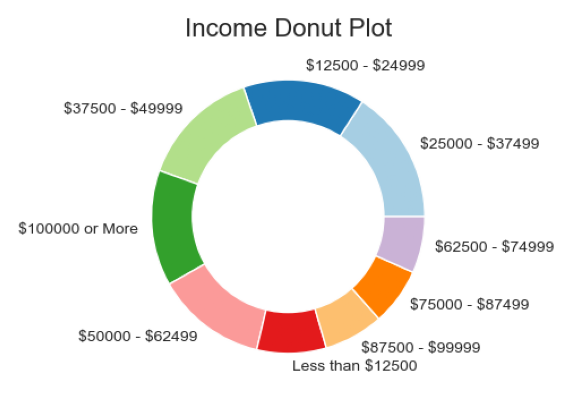

time: 75.8 ms (started: 2023-01-02 16:11:53 -08:00)


In [101]:
column_name='income'
title = 'Income Donut Plot'
figure_filename = '../reports/figures/figure_donut_plot_' + column_name + '_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['\$25000 - \$37499', '\$12500 - \$24999', '\$37500 - \$49999', '\$100000 or More', '\$50000 - \$62499', 'Less than \$12500', '\$87500 - \$99999', '\$75000 - \$87499', '\$62500 - \$74999']
size_list = [2013, 1831, 1805, 1736, 1659, 1042,  895,  857,  846]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



### Age Donut Plot

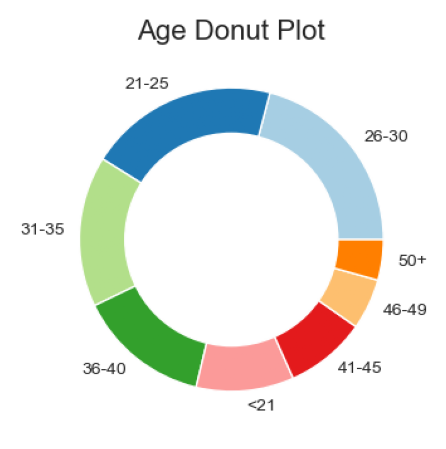

time: 73.1 ms (started: 2023-01-02 16:11:54 -08:00)


In [102]:
column_name = 'age'
title = 'Age Donut Plot'

figure_filename = '../reports/figures/figure_' + column_name +'_plot_income_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['26-30', '21-25', '31-35', '36-40', '<21', '41-45', '46-49', '50+']
size_list = [2653, 2559, 2039, 1788, 1319, 1093,  686,  547]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



### Monthly Coffee House Visit Frequency

In [103]:
df.loc[:, 'CoffeeHouse_venue_visit_frequency_yes_response_ordinal_integer_encoding'].value_counts().values

array([3385, 3225, 2962, 1784, 1111,  217])

time: 2.01 ms (started: 2023-01-02 16:11:54 -08:00)


In [104]:
coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_dencoding = {value : key for key, value in coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_encoding['CoffeeHouse'].items()}
pdc(coffeehouse_venue_visit_frequency_yes_response_ordinal_integer_dencoding)

6


{1: 'never', 2: '<1', 3: '1-3', 4: '4-8', 5: '>8', 0: 'no response'}

time: 2.56 ms (started: 2023-01-02 16:11:54 -08:00)


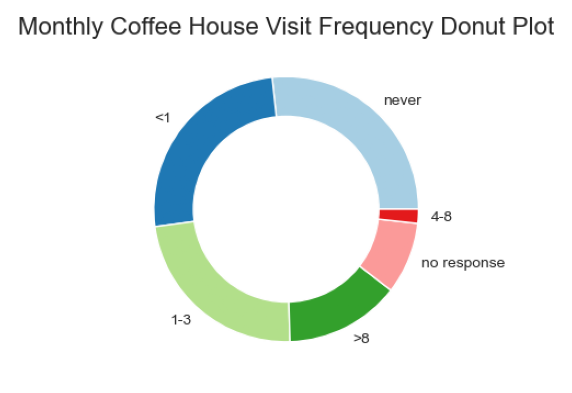

time: 76.2 ms (started: 2023-01-02 16:11:54 -08:00)


In [105]:
column_name='monthly_coffee_house_visit_frequency'
title = 'Monthly Coffee House Visit Frequency Donut Plot'
#title = 'Yes Response: Monthly Coffee House Visit Frequency Donut Plot'

figure_filename = '../reports/figures/figure_donut_plot_' + column_name + '_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['never', '<1', '1-3', '>8', 'no response', '4-8']
size_list = [3385, 3225, 2962, 1784, 1111,  217]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



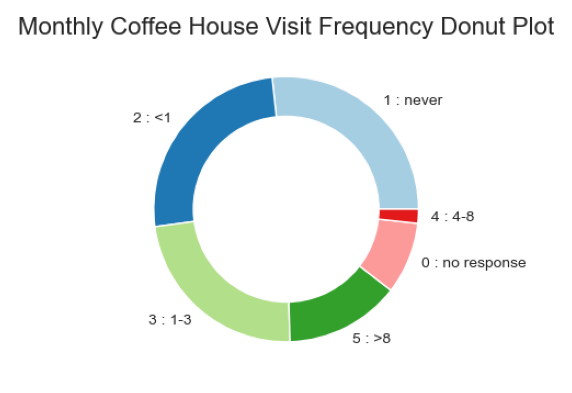

time: 77.5 ms (started: 2023-01-02 16:11:54 -08:00)


In [106]:
column_name='monthly_coffee_house_visit_frequency_encoding'
title = 'Monthly Coffee House Visit Frequency Donut Plot'
#title = 'Yes Response: Monthly Coffee House Visit Frequency Donut Plot'

figure_filename = '../reports/figures/figure_donut_plot_' + column_name + '_value_count_all_data_dpi_' + str(dpi) + '_v' + filename_version + '.png'

name_list = ['1 : never', '2 : <1', '3 : 1-3', '5 : >8', '0 : no response', '4 : 4-8']
size_list = [3385, 3225, 2962, 1784, 1111,  217]

icr.donut_plot(name_list, size_list, title=title, title_fontsize=title_fontsize, figure_filename=figure_filename, dpi=dpi, color_list=color_list, circle_color=circle_color)



In [107]:
df_Y_coupon_venue_type_proportion = df.groupby(['Y', 'coupon_venue_type']).agg({'coupon_venue_type': 'count'}).groupby(level=1).apply(lambda x: x / float(x.sum()))
df_Y_coupon_venue_type_proportion = df_Y_coupon_venue_type_proportion.rename(columns={'coupon_venue_type':'coupon_venue_type_proportion'}).reset_index()
df_Y_coupon_venue_type_proportion.sort_values(['Y', 'coupon_venue_type_proportion', 'coupon_venue_type'], ascending=False)


Y      coupon_venue_type  coupon_venue_type_proportion
6  1  Carry out & Take away                      0.735478
9  1        Restaurant(<20)                      0.707107
7  1           Coffee House                      0.499249
8  1      Restaurant(20-50)                      0.441019
5  1                    Bar                      0.410015
0  0                    Bar                      0.589985
3  0      Restaurant(20-50)                      0.558981
2  0           Coffee House                      0.500751
4  0        Restaurant(<20)                      0.292893
1  0  Carry out & Take away                      0.264522

time: 12 ms (started: 2023-01-02 16:11:54 -08:00)


In [108]:
for thing in df_Y_coupon_venue_type_proportion.columns:
    print(thing)

Y
coupon_venue_type
coupon_venue_type_proportion
time: 739 µs (started: 2023-01-02 16:11:54 -08:00)


In [109]:
for thing in df_Y_coupon_venue_type_proportion:
    print(thing)

Y
coupon_venue_type
coupon_venue_type_proportion
time: 724 µs (started: 2023-01-02 16:11:54 -08:00)


In [110]:
df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y'] == 0, :]

Y      coupon_venue_type  coupon_venue_type_proportion
0  0                    Bar                      0.589985
1  0  Carry out & Take away                      0.264522
2  0           Coffee House                      0.500751
3  0      Restaurant(20-50)                      0.558981
4  0        Restaurant(<20)                      0.292893

time: 3.56 ms (started: 2023-01-02 16:11:54 -08:00)


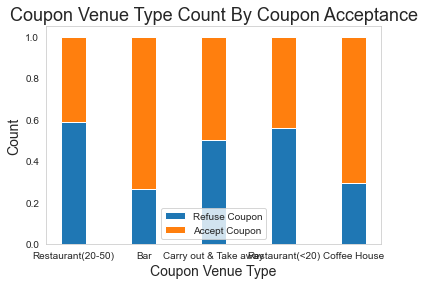

time: 90.6 ms (started: 2023-01-02 16:11:54 -08:00)


In [111]:
#stacked bar with coupon acceptance rate
import matplotlib.pyplot as plt


labels = df_coupon_venue_type_count.index.to_list()
refuse_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==0, 'coupon_venue_type_proportion'].to_list()
accept_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==1, 'coupon_venue_type_proportion'].to_list()
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, refuse_coupon, width, label='Refuse Coupon')
ax.bar(labels, accept_coupon, width, bottom=refuse_coupon, label='Accept Coupon')

ax.set_ylabel(ylabel='Count', fontsize=14)
ax.set_xlabel(xlabel='Coupon Venue Type', fontsize=14)
ax.set_title('Coupon Venue Type Count By Coupon Acceptance', fontsize=18)
ax.legend()

plt.show()

In [112]:
df_Y_coupon_venue_type_proportion

Y      coupon_venue_type  coupon_venue_type_proportion
0  0                    Bar                      0.589985
1  0  Carry out & Take away                      0.264522
2  0           Coffee House                      0.500751
3  0      Restaurant(20-50)                      0.558981
4  0        Restaurant(<20)                      0.292893
5  1                    Bar                      0.410015
6  1  Carry out & Take away                      0.735478
7  1           Coffee House                      0.499249
8  1      Restaurant(20-50)                      0.441019
9  1        Restaurant(<20)                      0.707107

time: 3.9 ms (started: 2023-01-02 16:11:54 -08:00)


In [113]:
df_Y_coupon_venue_type_proportion

Y      coupon_venue_type  coupon_venue_type_proportion
0  0                    Bar                      0.589985
1  0  Carry out & Take away                      0.264522
2  0           Coffee House                      0.500751
3  0      Restaurant(20-50)                      0.558981
4  0        Restaurant(<20)                      0.292893
5  1                    Bar                      0.410015
6  1  Carry out & Take away                      0.735478
7  1           Coffee House                      0.499249
8  1      Restaurant(20-50)                      0.441019
9  1        Restaurant(<20)                      0.707107

time: 3.54 ms (started: 2023-01-02 16:11:54 -08:00)


In [114]:
# Define the sorter
sorter = ['Carry out & Take away',
          'Restaurant(<20)',
          'Coffee House',
          'Restaurant(20-50)',
          'Bar']

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter, range(len(sorter))))


df_Y_coupon_venue_type_proportion.loc[:, 'coupon_venue_type_rank'] = \
df_Y_coupon_venue_type_proportion.loc[:, 'coupon_venue_type'].map(sorterIndex)


df_Y_coupon_venue_type_proportion = df_Y_coupon_venue_type_proportion.sort_values(['Y', 'coupon_venue_type_rank', ], ascending=[True , True])

#df_Y_coupon_venue_type_proportion = df_Y_coupon_venue_type_proportion.drop('coupon_venue_type_rank', 1)

df_Y_coupon_venue_type_proportion

Y      coupon_venue_type  coupon_venue_type_proportion  \
1  0  Carry out & Take away                      0.264522   
4  0        Restaurant(<20)                      0.292893   
2  0           Coffee House                      0.500751   
3  0      Restaurant(20-50)                      0.558981   
0  0                    Bar                      0.589985   
6  1  Carry out & Take away                      0.735478   
9  1        Restaurant(<20)                      0.707107   
7  1           Coffee House                      0.499249   
8  1      Restaurant(20-50)                      0.441019   
5  1                    Bar                      0.410015   

   coupon_venue_type_rank  
1                       0  
4                       1  
2                       2  
3                       3  
0                       4  
6                       0  
9                       1  
7                       2  
8                       3  
5                       4

time: 5.97 ms (started: 2023-01-02 16:11:54 -08:00)


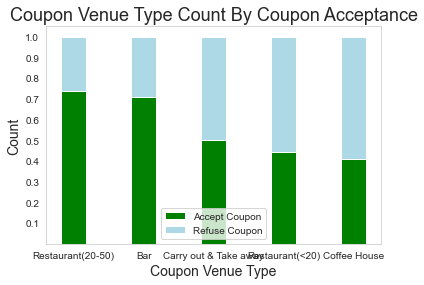

time: 90.7 ms (started: 2023-01-02 16:11:54 -08:00)


In [115]:
#stacked bar with coupon acceptance rate

labels = df_coupon_venue_type_count.index.to_list()
refuse_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==0, 'coupon_venue_type_proportion'].to_list()
accept_coupon = df_Y_coupon_venue_type_proportion.loc[df_Y_coupon_venue_type_proportion.loc[:, 'Y']==1, 'coupon_venue_type_proportion'].to_list()
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, accept_coupon, width, label='Accept Coupon', color='green')
ax.bar(labels, refuse_coupon, width, bottom=accept_coupon, label='Refuse Coupon', color='lightblue')

ax.set_ylabel(ylabel='Count', fontsize=14)
ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1,])
ax.set_xlabel(xlabel='Coupon Venue Type', fontsize=14)
ax.set_title('Coupon Venue Type Count By Coupon Acceptance', fontsize=18)
ax.legend()

plt.show()

In [116]:
#^--- add percentages

time: 597 µs (started: 2023-01-02 16:11:54 -08:00)


In [117]:
#analytics shows proportion of scenarios when a survey participant accepts vs denies a coupon


time: 478 µs (started: 2023-01-02 16:11:54 -08:00)


In [118]:
df_Y_coupon_accepted_coupon_venue_type = df.loc[df.loc[:, 'Y'] == 1, ['Y', 'coupon_venue_type']]
#p(df_Y_coupon_accepted_coupon_venue_type)

df_Y_coupon_denied_coupon_venue_type = df.loc[df.loc[:, 'Y'] == 0, ['Y', 'coupon_venue_type']]
p(df_Y_coupon_denied_coupon_venue_type)


(5474, 2)


Y  coupon_venue_type
1474   0                Bar
4567   0                Bar
4732   0    Restaurant(<20)
3122   0       Coffee House
7329   0                Bar
7769   0    Restaurant(<20)
11343  0  Restaurant(20-50)
9036   0    Restaurant(<20)
11050  0  Restaurant(20-50)
1818   0                Bar

time: 8.08 ms (started: 2023-01-02 16:11:54 -08:00)


In [119]:
df.groupby(['Y', 'coupon_venue_type']).count().iloc[:, 0].reset_index().rename(columns={'destination':'count'})


Y      coupon_venue_type  count
0  0                    Bar   1190
1  0  Carry out & Take away    633
2  0           Coffee House   2001
3  0      Restaurant(20-50)    834
4  0        Restaurant(<20)    816
5  1                    Bar    827
6  1  Carry out & Take away   1760
7  1           Coffee House   1995
8  1      Restaurant(20-50)    658
9  1        Restaurant(<20)   1970

time: 29 ms (started: 2023-01-02 16:11:54 -08:00)


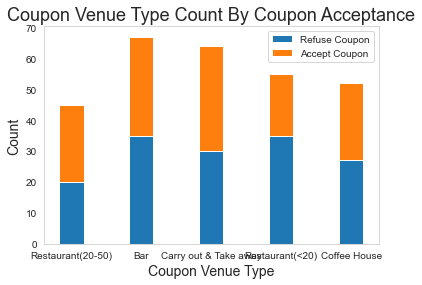

time: 85.8 ms (started: 2023-01-02 16:11:54 -08:00)


In [120]:
#stacked bar with coupon acceptance rate
import matplotlib.pyplot as plt


labels = df_coupon_venue_type_count.index.to_list()
refuse_coupon = [20, 35, 30, 35, 27]
accept_coupon = [25, 32, 34, 20, 25]
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, refuse_coupon, width, label='Refuse Coupon')
ax.bar(labels, accept_coupon, width, bottom=refuse_coupon, label='Accept Coupon')

ax.set_ylabel(ylabel='Count', fontsize=14)
ax.set_xlabel(xlabel='Coupon Venue Type', fontsize=14)
ax.set_title('Coupon Venue Type Count By Coupon Acceptance', fontsize=18)
ax.legend()

plt.show()

In [121]:
#five types of coupons:
#bars
#takeaway food restaurants
#coffee houses
#cheap restaurants (average expense below $20 per person)
#expensive restaurants (average expense between $20 to $50 per person)

df.loc[:, 'coupon_venue_type'].value_counts()


Coffee House             3996
Restaurant(<20)          2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: coupon_venue_type, dtype: int64

time: 15.7 ms (started: 2023-01-02 16:11:54 -08:00)


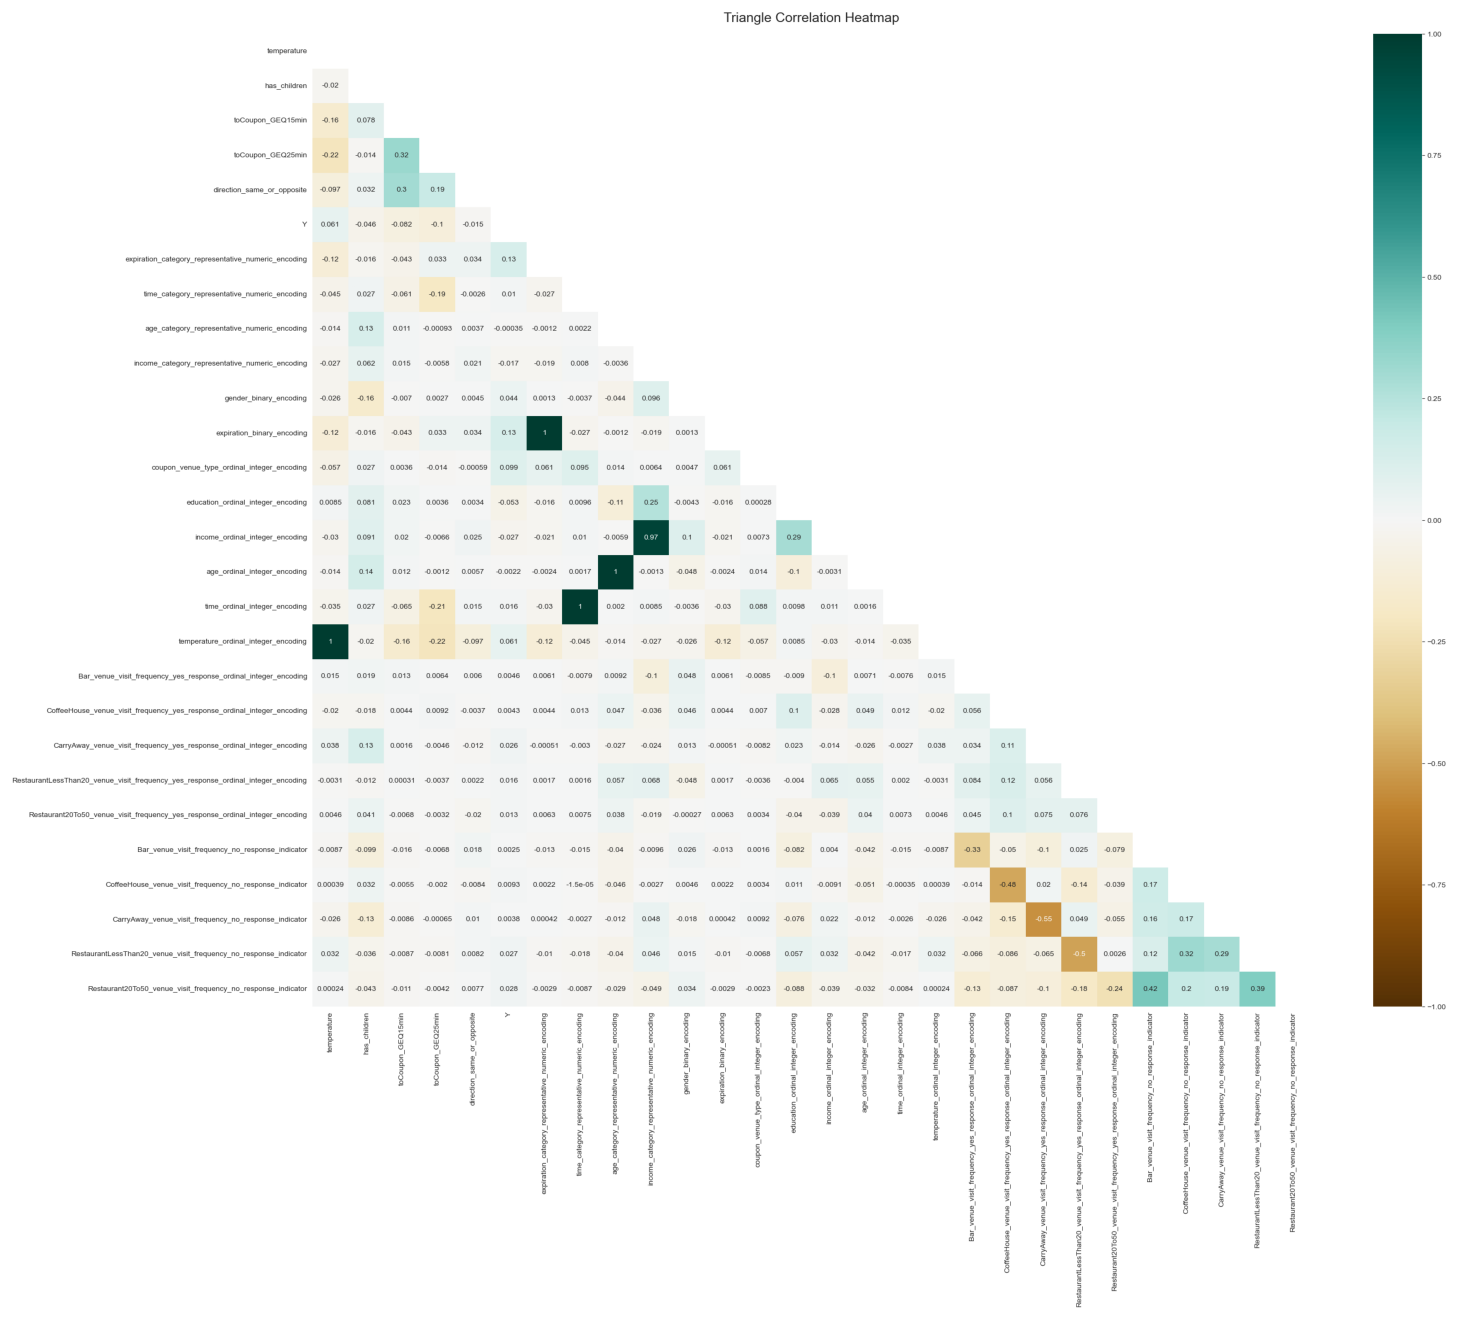

time: 685 ms (started: 2023-01-02 16:11:54 -08:00)


In [122]:
#correlation heatmap
dpi=100
figure_filename = '../reports/figures/figure_triangle_correlation_heatmap_random_forest_classifier_numerics_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)

if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(30, 24))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    plt.figure(figsize=(30, 24))
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [123]:
#.11 correlation between coupon acceptance and reported CoffeeHouse venue visit frequency

#.099 correlation between venue coupon type and coupon accpetance

#.13 correlation between coupon expiraton and coupon acceptance

#.07 correaltio between reported expensive restaurant visit frequency and coupon acceptance

#.07 correlation between coupon acceptance and reported bar visit frequency 

#.061 correlation between temperature and coupon acceptance

#-.1 correlation between coupon acceptance and driver travel time to venue is greater than 25 minute

#-.082 correlation between coupon acceptance and driver travel time to venue is greater than 15 minute

#-.046 correlation between having children and accpeting coupon

time: 649 µs (started: 2023-01-02 16:11:55 -08:00)


In [124]:
dir()

['Audio',
 'ConfusionMatrixDisplay',
 'GradientBoostingClassifier',
 'GridSearchCV',
 'In',
 'LogisticRegression',
 'N_population_size',
 'Out',
 'RandomForestClassifier',
 'StandardScaler',
 'StratifiedKFold',
 '_',
 '_10',
 '_103',
 '_104',
 '_107',
 '_11',
 '_110',
 '_112',
 '_113',
 '_114',
 '_118',
 '_119',
 '_12',
 '_121',
 '_13',
 '_15',
 '_16',
 '_17',
 '_18',
 '_24',
 '_25',
 '_27',
 '_31',
 '_34',
 '_35',
 '_39',
 '_40',
 '_41',
 '_46',
 '_67',
 '_74',
 '_76',
 '_8',
 '_84',
 '_85',
 '_86',
 '_88',
 '_89',
 '_9',
 '_90',
 '_92',
 '_95',
 '_96',
 '_97',
 '_98',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i100',
 '_i101',
 '_i102',
 '_i103',
 '_i104',
 '_i105',
 '_i106',
 '_i107',
 '_i108',
 '_i109',
 '_i11',
 '_i110',
 '_i111',
 '_i112',
 '_i113',
 '_i114',
 '_i115',
 '_i116',
 '_i117',
 '_i118',
 '_i119',
 '_i12',
 '_i120',
 '_i121',
 '_i122',
 '_i123',
 

time: 4.14 ms (started: 2023-01-02 16:11:55 -08:00)


In [125]:
#save preprocessed data frame
df_collection_filename='df_collection_train_test_v' + filename_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=df_collection_filename)
if df_readback != None:
    df_collection = df_readback
else:
    df_collection = {}
    
    #split the data into train and test
    df_collection['X_train'], df_collection['X_test'], df_collection['Y_train'], df_collection['Y_test'] = \
    train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=.2, random_state=200)
    
    #save preprocessed data frame collection
    df_collection = icr.save_and_return_collection(data_frame_collection=df_collection, filename=df_collection_filename)

p(df_collection['X_train'])

This file already exists
(10147, 45)


destination  passenger weather  temperature  time  \
8630   No Urgent Place  Friend(s)   Sunny           80   6PM   
2418   No Urgent Place  Friend(s)   Sunny           55   2PM   
10804  No Urgent Place      Alone   Rainy           55   2PM   
747    No Urgent Place  Friend(s)   Sunny           80   2PM   
7333   No Urgent Place  Friend(s)   Sunny           80   6PM   
10949  No Urgent Place     Kid(s)   Snowy           30   6PM   
11937  No Urgent Place      Alone   Rainy           55  10AM   
735               Home      Alone   Sunny           55   6PM   
67     No Urgent Place  Friend(s)   Sunny           80  10AM   
3251   No Urgent Place  Friend(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
8630            Coffee House         1d  Female  21-25    Married partner   
2418            Coffee House         2h  Female  26-30             Single   
10804  Carry out & Take away         2h  Female  31-35             Single   
747             Coffee House         1d  Female  36-40    Married partner   
7333            Coffee House         1d    Male    <21  Unmarried partner   
10949                    Bar         1d  Female  31-35    Married partner   
11937                    Bar         1d  Female  31-35    Married partner   
735        Restaurant(20-50)         1d    Male  41-45             Single   
67              Coffee House         2h    Male  46-49    Married partner   
3251            Coffee House         2h  Female  26-30    Married partner   

       has_children                               education  \
8630              0                        Bachelors degree   
2418              0                        Bachelors degree   
10804             0  Graduate degree (Masters or Doctorate)   
747               0                Some college - no degree   
7333              1                Some college - no degree   
10949             1                        Bachelors degree   
11937             0                Some college - no degree   
735               0                Some college - no degree   
67                1                        Bachelors degree   
3251              1                Some college - no degree   

                                      occupation             income  \
8630                                  Unemployed  \$87500 - \$99999   
2418    Arts Design Entertainment Sports & Media  \$12500 - \$24999   
10804                                      Legal  \$75000 - \$87499   
747                           Healthcare Support  \$25000 - \$37499   
7333   Building & Grounds Cleaning & Maintenance  \$25000 - \$37499   
10949                                    Student  \$37500 - \$49999   
11937                    Computer & Mathematical   \$100000 or More   
735                              Sales & Related  \$37500 - \$49999   
67                    Education&Training&Library  \$75000 - \$87499   
3251                                  Unemployed  \$25000 - \$37499   

               car          Bar CoffeeHouse    CarryAway RestaurantLessThan20  \
8630   no response           <1       never          4-8                never   
2418   no response           >8          >8           >8                   >8   
10804  no response  no response          >8           >8                   >8   
747    no response           <1          <1           >8                   >8   
7333   no response           <1       never           <1                   <1   
10949  no response          1-3       never  no response                   >8   
11937  no response        never       never  no response                   >8   
735    no response          1-3         1-3           >8                   <1   
67     no response        never          <1           <1                   <1   
3251   no response          1-3       never           <1                never   

      Restaurant20To50  toCoupon_GEQ15min  toCoupon_GEQ25min  \
8630             never    

time: 22.7 ms (started: 2023-01-02 16:11:55 -08:00)


## Get Stratified Train Data Frame Collection Before Data Preprocesssing

In [126]:
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(X=df_collection['X_train'], y=df_collection['Y_train'].to_frame())):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold ' + str(index)] = \
    {'X_train' : df_collection['X_train'].iloc[train_index, :], \
     'X_test' : df_collection['X_train'].iloc[test_index, :], \
     'Y_train' : df_collection['Y_train'].iloc[train_index], \
     'Y_test' : df_collection['Y_train'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold 0']['X_test'])



fold 0 TRAIN: [ 2028  2030  2031 ... 10144 10145 10146] TEST: [   0    1    2 ... 2027 2029 2032]
fold 1 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [2028 2030 2031 ... 4095 4101 4102]
fold 2 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [4009 4010 4012 ... 6131 6133 6135]
fold 3 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [6036 6037 6043 ... 8126 8127 8128]
fold 4 TRAIN: [   0    1    2 ... 8126 8127 8128] TEST: [ 8099  8105  8109 ... 10144 10145 10146]

(2030, 45)


destination  passenger weather  temperature  time  \
8630   No Urgent Place  Friend(s)   Sunny           80   6PM   
2418   No Urgent Place  Friend(s)   Sunny           55   2PM   
10804  No Urgent Place      Alone   Rainy           55   2PM   
747    No Urgent Place  Friend(s)   Sunny           80   2PM   
7333   No Urgent Place  Friend(s)   Sunny           80   6PM   
1460   No Urgent Place  Friend(s)   Sunny           80   2PM   
8449              Work      Alone   Snowy           30   7AM   
11224             Home      Alone   Rainy           55  10PM   
5085   No Urgent Place  Friend(s)   Sunny           80   2PM   
7156   No Urgent Place  Friend(s)   Sunny           80   2PM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
8630            Coffee House         1d  Female  21-25    Married partner   
2418            Coffee House         2h  Female  26-30             Single   
10804  Carry out & Take away         2h  Female  31-35             Single   
747             Coffee House         1d  Female  36-40    Married partner   
7333            Coffee House         1d    Male    <21  Unmarried partner   
1460            Coffee House         2h    Male  46-49    Married partner   
8449       Restaurant(20-50)         1d    Male  41-45    Married partner   
11224           Coffee House         2h    Male    50+  Unmarried partner   
5085         Restaurant(<20)         2h    Male  26-30             Single   
7156       Restaurant(20-50)         2h    Male  31-35    Married partner   

       has_children                               education  \
8630              0                        Bachelors degree   
2418              0                        Bachelors degree   
10804             0  Graduate degree (Masters or Doctorate)   
747               0                Some college - no degree   
7333              1                Some college - no degree   
1460              1  Graduate degree (Masters or Doctorate)   
8449              1                       Associates degree   
11224             0                Some college - no degree   
5085              0                    High School Graduate   
7156              1                Some college - no degree   

                                      occupation             income  \
8630                                  Unemployed  \$87500 - \$99999   
2418    Arts Design Entertainment Sports & Media  \$12500 - \$24999   
10804                                      Legal  \$75000 - \$87499   
747                           Healthcare Support  \$25000 - \$37499   
7333   Building & Grounds Cleaning & Maintenance  \$25000 - \$37499   
1460                                  Management  \$87500 - \$99999   
8449                  Farming Fishing & Forestry  \$25000 - \$37499   
11224                                    Student  \$25000 - \$37499   
5085                                  Unemployed  \$25000 - \$37499   
7156                   Construction & Extraction  \$37500 - \$49999   

               car          Bar CoffeeHouse CarryAway RestaurantLessThan20  \
8630   no response           <1       never       4-8                never   
2418   no response           >8          >8        >8                   >8   
10804  no response  no response          >8        >8                   >8   
747    no response           <1          <1        >8                   >8   
7333   no response           <1       never        <1                   <1   
1460   no response        never          <1        <1                never   
8449   no response          1-3         1-3       1-3                   <1   
11224  no response          1-3         1-3        <1                never   
5085   no response        never          <1        >8                   <1   
7156   no response          1-3         1-3        >8                   >8   

      Restaurant20To50  toCoupon_GEQ15min  toCoupon_GEQ25min  \
8630             never                  0                  

time: 29.7 ms (started: 2023-01-02 16:11:55 -08:00)


In [127]:
data_frame_list = [stratified_fold_number_X_train_X_test_Y_train_Y_test_df_collection['fold ' + str(index)]['X_test'] for index in range(5)]

df_stratified_fold_number_X_test = pd.concat(data_frame_list)

p(df_stratified_fold_number_X_test)

(10147, 45)


destination  passenger weather  temperature  time  \
8630   No Urgent Place  Friend(s)   Sunny           80   6PM   
2418   No Urgent Place  Friend(s)   Sunny           55   2PM   
10804  No Urgent Place      Alone   Rainy           55   2PM   
747    No Urgent Place  Friend(s)   Sunny           80   2PM   
7333   No Urgent Place  Friend(s)   Sunny           80   6PM   
10949  No Urgent Place     Kid(s)   Snowy           30   6PM   
11937  No Urgent Place      Alone   Rainy           55  10AM   
735               Home      Alone   Sunny           55   6PM   
67     No Urgent Place  Friend(s)   Sunny           80  10AM   
3251   No Urgent Place  Friend(s)   Sunny           80  10AM   

           coupon_venue_type expiration  gender    age      maritalStatus  \
8630            Coffee House         1d  Female  21-25    Married partner   
2418            Coffee House         2h  Female  26-30             Single   
10804  Carry out & Take away         2h  Female  31-35             Single   
747             Coffee House         1d  Female  36-40    Married partner   
7333            Coffee House         1d    Male    <21  Unmarried partner   
10949                    Bar         1d  Female  31-35    Married partner   
11937                    Bar         1d  Female  31-35    Married partner   
735        Restaurant(20-50)         1d    Male  41-45             Single   
67              Coffee House         2h    Male  46-49    Married partner   
3251            Coffee House         2h  Female  26-30    Married partner   

       has_children                               education  \
8630              0                        Bachelors degree   
2418              0                        Bachelors degree   
10804             0  Graduate degree (Masters or Doctorate)   
747               0                Some college - no degree   
7333              1                Some college - no degree   
10949             1                        Bachelors degree   
11937             0                Some college - no degree   
735               0                Some college - no degree   
67                1                        Bachelors degree   
3251              1                Some college - no degree   

                                      occupation             income  \
8630                                  Unemployed  \$87500 - \$99999   
2418    Arts Design Entertainment Sports & Media  \$12500 - \$24999   
10804                                      Legal  \$75000 - \$87499   
747                           Healthcare Support  \$25000 - \$37499   
7333   Building & Grounds Cleaning & Maintenance  \$25000 - \$37499   
10949                                    Student  \$37500 - \$49999   
11937                    Computer & Mathematical   \$100000 or More   
735                              Sales & Related  \$37500 - \$49999   
67                    Education&Training&Library  \$75000 - \$87499   
3251                                  Unemployed  \$25000 - \$37499   

               car          Bar CoffeeHouse    CarryAway RestaurantLessThan20  \
8630   no response           <1       never          4-8                never   
2418   no response           >8          >8           >8                   >8   
10804  no response  no response          >8           >8                   >8   
747    no response           <1          <1           >8                   >8   
7333   no response           <1       never           <1                   <1   
10949  no response          1-3       never  no response                   >8   
11937  no response        never       never  no response                   >8   
735    no response          1-3         1-3           >8                   <1   
67     no response        never          <1           <1                   <1   
3251   no response          1-3       never           <1                never   

      Restaurant20To50  toCoupon_GEQ15min  toCoupon_GEQ25min  \
8630             never    

time: 18.7 ms (started: 2023-01-02 16:11:55 -08:00)


<font size="5"><a id='[Data_Preprocessing]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Data_Preprocessing]'>**Data Preprocessing**</a> </font>

## Convert Indicator Variables from Categorical Variables and Add Back to Numeric Variables

In [128]:
#get column name lists
column_name_list_numeric = list(df.select_dtypes('number').columns)
column_name_list_not_numeric = [column_name for column_name in df.columns if not column_name in column_name_list_numeric]

#get categorical features, numeric features, and target data frame
df_categorical_features = df.loc[:, column_name_list_not_numeric]
df_numeric_features = df.loc[:, column_name_list_numeric].drop(columns='Y')
df_target = df.loc[:, ['Y']]

#get category indicators data frame from df_categorical_features
df_category_indicator_features = pd.get_dummies(df_categorical_features)

del df_categorical_features

#combine category indicator features and numeric features
df_indicator_numeric_features = pd.concat([df_category_indicator_features, df_numeric_features], axis=1)

del df_numeric_features, 

p(df_indicator_numeric_features)


(12684, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
11199                 1                            0                 0   
1474                  0                            0                 1   
10836                 1                            0                 0   
4567                  0                            1                 0   
5658                  0                            1                 0   
11343                 0                            0                 1   
9036                  1                            0                 0   
11050                 1                            0                 0   
784                   0                            0                 1   
1818                  0                            1                 0   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
11199                1                    0                 0   
1474                 1                    0                 0   
10836                1                    0                 0   
4567                 1                    0                 0   
5658                 1                    0                 0   
11343                1                    0                 0   
9036                 1                    0                 0   
11050                1                    0                 0   
784                  1                    0                 0   
1818                 0                    0                 1   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
11199                  0              0              0              1   
1474                   0              0              0              1   
10836                  0              0              0              1   
4567                   0              0              0              1   
5658                   0              0              0              1   
11343                  0              0              0              1   
9036                   0              0              1              0   
11050                  0              0              0              1   
784                    0              0              0              1   
1818                   0              0              0              1   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
11199          0          0         0         1         0   
1474           0          0         0         0         1   
10836          0          0         0         1         0   
4567           1          0         0         0         0   
5658           0          0         1         0         0   
11343          0          0         0         0         1   
9036           0          1         0         0         0   
11050          0          0         0         1         0   
784            0          0         0         0         1   
1818           1          0         0         0         0   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
11199                      0                                        1   
1474                       1                                        0   
10836                      0                                        1   
4567                       1                                        0   
5658                       0                                        0   
11343                      0                                        0   
9036                       0                                        0   
11050                      0                                        0   
784                        0                                        1   
1818                       1                                        0   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
11199                               0                                    0   
1474                                0   

time: 58.9 ms (started: 2023-01-02 16:11:55 -08:00)


## Get Data Frame Collection With Train and Test Features

In [129]:
data_frame_collection_filename='data_frame_collection_train_test_v' + filename_version + '.pkl'

df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    data_frame_collection = {}

    #split the data into train and test
    data_frame_collection['X_train'], data_frame_collection['X_test'], data_frame_collection['Y_train'], data_frame_collection['Y_test'] = \
    train_test_split(df_indicator_numeric_features, df_target, test_size=.2, random_state=200)

    del df_indicator_numeric_features

    #save preprocessed data frame collection
    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

p(data_frame_collection['X_train'])

This file already exists
(10147, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
8630                  0                            1                 0   
2418                  0                            1                 0   
10804                 0                            1                 0   
747                   0                            1                 0   
7333                  0                            1                 0   
10949                 0                            1                 0   
11937                 0                            1                 0   
735                   1                            0                 0   
67                    0                            1                 0   
3251                  0                            1                 0   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
8630                 0                    1                 0   
2418                 0                    1                 0   
10804                1                    0                 0   
747                  0                    1                 0   
7333                 0                    1                 0   
10949                0                    0                 1   
11937                1                    0                 0   
735                  1                    0                 0   
67                   0                    1                 0   
3251                 0                    1                 0   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
8630                   0              0              0              1   
2418                   0              0              0              1   
10804                  0              1              0              0   
747                    0              0              0              1   
7333                   0              0              0              1   
10949                  0              0              1              0   
11937                  0              1              0              0   
735                    0              0              0              1   
67                     0              0              0              1   
3251                   0              0              0              1   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
8630           0          0         0         1         0   
2418           0          0         1         0         0   
10804          0          0         1         0         0   
747            0          0         1         0         0   
7333           0          0         0         1         0   
10949          0          0         0         1         0   
11937          1          0         0         0         0   
735            0          0         0         1         0   
67             1          0         0         0         0   
3251           1          0         0         0         0   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
8630                       0                                        0   
2418                       0                                        0   
10804                      0                                        1   
747                        0                                        0   
7333                       0                                        0   
10949                      1                                        0   
11937                      1                                        0   
735                        0                                        0   
67                         0                                        0   
3251                       0                                        0   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
8630                                1                                    0   
2418                                1   

time: 35.9 ms (started: 2023-01-02 16:11:55 -08:00)


In [130]:
p(data_frame_collection['Y_train'])

(10147, 1)


Y
8630   1
2418   1
10804  0
747    1
7333   1
10949  0
11937  0
735    1
67     1
3251   1

time: 4.21 ms (started: 2023-01-02 16:11:55 -08:00)


## Standardize And Scale Features of Data Frame Collection

In [131]:
data_frame_collection_filename='data_frame_collection_train_test_standardize_scale_v' + filename_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    #standardize and scale feature data frame
    standard_scaler = StandardScaler()
    standardized_scaled_data_frame_collection_X_train_ndarray = standard_scaler.fit_transform(data_frame_collection['X_train'])
    data_frame_collection['X_train'] = pd.DataFrame(standardized_scaled_data_frame_collection_X_train_ndarray, columns=data_frame_collection['X_train'].columns, index=data_frame_collection['X_train'].index)

    standard_scaler = StandardScaler()
    standard_scaler.fit(pd.concat([data_frame_collection['X_train'], data_frame_collection['X_test']], axis=0))
    standardized_scaled_df_collection_X_test_ndarray = standard_scaler.transform(data_frame_collection['X_test'])
    data_frame_collection['X_test'] = pd.DataFrame(standardized_scaled_df_collection_X_test_ndarray, columns=data_frame_collection['X_test'].columns, index=data_frame_collection['X_test'].index)

    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

    del standardized_scaled_data_frame_collection_X_train_ndarray, standardized_scaled_df_collection_X_test_ndarray, standard_scaler

p(data_frame_collection['X_train'])

This file already exists
(10147, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
8630          -0.587858                     1.003257         -0.569346   
2418          -0.587858                     1.003257         -0.569346   
10804         -0.587858                     1.003257         -0.569346   
747           -0.587858                     1.003257         -0.569346   
7333          -0.587858                     1.003257         -0.569346   
10949         -0.587858                     1.003257         -0.569346   
11937         -0.587858                     1.003257         -0.569346   
735            1.701090                    -0.996753         -0.569346   
67            -0.587858                     1.003257         -0.569346   
3251          -0.587858                     1.003257         -0.569346   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
8630         -1.154170             1.678978         -0.298862   
2418         -1.154170             1.678978         -0.298862   
10804         0.866424            -0.595600         -0.298862   
747          -1.154170             1.678978         -0.298862   
7333         -1.154170             1.678978         -0.298862   
10949        -1.154170            -0.595600          3.346030   
11937         0.866424            -0.595600         -0.298862   
735           0.866424            -0.595600         -0.298862   
67           -1.154170             1.678978         -0.298862   
3251         -1.154170             1.678978         -0.298862   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
8630           -0.304693      -0.327333      -0.350292       0.509468   
2418           -0.304693      -0.327333      -0.350292       0.509468   
10804          -0.304693       3.054995      -0.350292      -1.962830   
747            -0.304693      -0.327333      -0.350292       0.509468   
7333           -0.304693      -0.327333      -0.350292       0.509468   
10949          -0.304693      -0.327333       2.854765      -1.962830   
11937          -0.304693       3.054995      -0.350292      -1.962830   
735            -0.304693      -0.327333      -0.350292       0.509468   
67             -0.304693      -0.327333      -0.350292       0.509468   
3251           -0.304693      -0.327333      -0.350292       0.509468   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
8630   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
2418   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
10804  -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
747    -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
7333   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
10949  -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
11937   2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
735    -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
67      2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
3251    2.132567  -0.436673 -0.434912 -0.586189 -0.569346   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
8630               -0.435552                                -0.480608   
2418               -0.435552                                -0.480608   
10804              -0.435552                                 2.080699   
747                -0.435552                                -0.480608   
7333               -0.435552                                -0.480608   
10949               2.295936                                -0.480608   
11937               2.295936                                -0.480608   
735                -0.435552                                -0.480608   
67                 -0.435552                                -0.480608   
3251               -0.435552                                -0.480608   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
8630                         1.478469                            -0.364148   
2418                         1.478469   

time: 71.9 ms (started: 2023-01-02 16:11:55 -08:00)


In [132]:
p(data_frame_collection['X_test'])

(2537, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
4948           1.701090                    -0.996753         -0.569346   
3931          -0.587858                    -0.996753          1.756401   
4090          -0.587858                     1.003257         -0.569346   
11756         -0.587858                    -0.996753          1.756401   
8049           1.701090                    -0.996753         -0.569346   
7682          -0.587858                    -0.996753          1.756401   
7273          -0.587858                     1.003257         -0.569346   
3812          -0.587858                     1.003257         -0.569346   
12406          1.701090                    -0.996753         -0.569346   
4697          -0.587858                    -0.996753          1.756401   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
4948          0.866424            -0.595600         -0.298862   
3931          0.866424            -0.595600         -0.298862   
4090         -1.154170             1.678978         -0.298862   
11756         0.866424            -0.595600         -0.298862   
8049          0.866424            -0.595600         -0.298862   
7682          0.866424            -0.595600         -0.298862   
7273         -1.154170            -0.595600         -0.298862   
3812         -1.154170            -0.595600         -0.298862   
12406         0.866424            -0.595600         -0.298862   
4697          0.866424            -0.595600         -0.298862   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
4948           -0.304693      -0.327333      -0.350292       0.509468   
3931           -0.304693      -0.327333      -0.350292       0.509468   
4090           -0.304693      -0.327333      -0.350292       0.509468   
11756          -0.304693      -0.327333      -0.350292       0.509468   
8049           -0.304693       3.054995      -0.350292      -1.962830   
7682           -0.304693      -0.327333       2.854765      -1.962830   
7273            3.281991      -0.327333       2.854765      -1.962830   
3812            3.281991      -0.327333      -0.350292       0.509468   
12406          -0.304693      -0.327333      -0.350292       0.509468   
4697           -0.304693      -0.327333      -0.350292       0.509468   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
4948   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
3931   -0.468919  -0.436673 -0.434912 -0.586189  1.756401   
4090   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
11756  -0.468919  -0.436673 -0.434912 -0.586189  1.756401   
8049   -0.468919   2.290045 -0.434912 -0.586189 -0.569346   
7682   -0.468919  -0.436673 -0.434912 -0.586189  1.756401   
7273   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
3812   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
12406  -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
4697   -0.468919  -0.436673 -0.434912 -0.586189  1.756401   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
4948               -0.435552                                -0.480608   
3931               -0.435552                                -0.480608   
4090               -0.435552                                -0.480608   
11756              -0.435552                                -0.480608   
8049               -0.435552                                -0.480608   
7682               -0.435552                                -0.480608   
7273               -0.435552                                -0.480608   
3812                2.295936                                -0.480608   
12406              -0.435552                                 2.080699   
4697               -0.435552                                 2.080699   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
4948                         1.478469                            -0.364148   
3931                         1.478469   

time: 57.4 ms (started: 2023-01-02 16:11:55 -08:00)


In [133]:
p(data_frame_collection['Y_train'])

(10147, 1)


Y
8630   1
2418   1
10804  0
747    1
7333   1
10949  0
11937  0
735    1
67     1
3251   1

time: 3.34 ms (started: 2023-01-02 16:11:55 -08:00)


In [134]:
p(data_frame_collection['Y_test'])

(2537, 1)


Y
4948   0
3931   0
4090   0
11756  0
8049   1
7682   0
7273   1
3812   0
12406  1
4697   1

time: 3.78 ms (started: 2023-01-02 16:11:55 -08:00)


In [135]:
print(data_frame_collection['X_train'].shape, data_frame_collection['X_test'].shape, data_frame_collection['Y_train'].shape, data_frame_collection['Y_test'].shape)


(10147, 140) (2537, 140) (10147, 1) (2537, 1)
time: 539 µs (started: 2023-01-02 16:11:55 -08:00)


## Get Stratified 5-Fold Cross Validation X_train, X_test, Y_train, Y_test Collection

In [136]:
#stratified 5-fold cross validation train-test data row selection

#Stratified 5-Fold object
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

#get stratfied 5-fold data frame splits
stratified_fold_number_X_train_X_test_Y_train_Y_test_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)] = \
    {'X_train' : data_frame_collection['X_train'].iloc[train_index, :], \
     'X_test' : data_frame_collection['X_train'].iloc[test_index, :], \
     'Y_train' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[train_index], \
     'Y_test' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_train'])

fold 0 TRAIN: [ 2028  2030  2031 ... 10144 10145 10146] TEST: [   0    1    2 ... 2027 2029 2032]
fold 1 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [2028 2030 2031 ... 4095 4101 4102]
fold 2 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [4009 4010 4012 ... 6131 6133 6135]
fold 3 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [6036 6037 6043 ... 8126 8127 8128]
fold 4 TRAIN: [   0    1    2 ... 8126 8127 8128] TEST: [ 8099  8105  8109 ... 10144 10145 10146]

(8117, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
11981         -0.587858                     1.003257         -0.569346   
3996          -0.587858                    -0.996753          1.756401   
1301          -0.587858                    -0.996753          1.756401   
9720           1.701090                    -0.996753         -0.569346   
752           -0.587858                     1.003257         -0.569346   
10949         -0.587858                     1.003257         -0.569346   
11937         -0.587858                     1.003257         -0.569346   
735            1.701090                    -0.996753         -0.569346   
67            -0.587858                     1.003257         -0.569346   
3251          -0.587858                     1.003257         -0.569346   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
11981        -1.154170             1.678978         -0.298862   
3996          0.866424            -0.595600         -0.298862   
1301          0.866424            -0.595600         -0.298862   
9720          0.866424            -0.595600         -0.298862   
752          -1.154170            -0.595600         -0.298862   
10949        -1.154170            -0.595600          3.346030   
11937         0.866424            -0.595600         -0.298862   
735           0.866424            -0.595600         -0.298862   
67           -1.154170             1.678978         -0.298862   
3251         -1.154170             1.678978         -0.298862   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
11981          -0.304693      -0.327333      -0.350292       0.509468   
3996           -0.304693      -0.327333      -0.350292       0.509468   
1301           -0.304693      -0.327333      -0.350292       0.509468   
9720           -0.304693       3.054995      -0.350292      -1.962830   
752             3.281991      -0.327333      -0.350292       0.509468   
10949          -0.304693      -0.327333       2.854765      -1.962830   
11937          -0.304693       3.054995      -0.350292      -1.962830   
735            -0.304693      -0.327333      -0.350292       0.509468   
67             -0.304693      -0.327333      -0.350292       0.509468   
3251           -0.304693      -0.327333      -0.350292       0.509468   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
11981   2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
3996   -0.468919  -0.436673 -0.434912 -0.586189  1.756401   
1301   -0.468919  -0.436673 -0.434912 -0.586189  1.756401   
9720   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
752     2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
10949  -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
11937   2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
735    -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
67      2.132567  -0.436673 -0.434912 -0.586189 -0.569346   
3251    2.132567  -0.436673 -0.434912 -0.586189 -0.569346   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
11981              -0.435552                                 2.080699   
3996               -0.435552                                -0.480608   
1301               -0.435552                                -0.480608   
9720                2.295936                                -0.480608   
752                 2.295936                                -0.480608   
10949               2.295936                                -0.480608   
11937               2.295936                                -0.480608   
735                -0.435552                                -0.480608   
67                 -0.435552                                -0.480608   
3251               -0.435552                                -0.480608   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
11981                       -0.676375                            -0.364148   
3996                        -0.676375   

time: 81.7 ms (started: 2023-01-02 16:11:55 -08:00)


In [137]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_train'])

(8117,)


11981    1
3996     1
1301     1
9720     0
752      0
10949    0
11937    0
735      1
67       1
3251     1
Name: Y, dtype: int64

time: 2.38 ms (started: 2023-01-02 16:11:55 -08:00)


In [138]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_test'])

(2030, 140)


destination_Home  destination_No Urgent Place  destination_Work  \
8630          -0.587858                     1.003257         -0.569346   
2418          -0.587858                     1.003257         -0.569346   
10804         -0.587858                     1.003257         -0.569346   
747           -0.587858                     1.003257         -0.569346   
7333          -0.587858                     1.003257         -0.569346   
1460          -0.587858                     1.003257         -0.569346   
8449          -0.587858                    -0.996753          1.756401   
11224          1.701090                    -0.996753         -0.569346   
5085          -0.587858                     1.003257         -0.569346   
7156          -0.587858                     1.003257         -0.569346   

       passenger_Alone  passenger_Friend(s)  passenger_Kid(s)  \
8630         -1.154170             1.678978         -0.298862   
2418         -1.154170             1.678978         -0.298862   
10804         0.866424            -0.595600         -0.298862   
747          -1.154170             1.678978         -0.298862   
7333         -1.154170             1.678978         -0.298862   
1460         -1.154170             1.678978         -0.298862   
8449          0.866424            -0.595600         -0.298862   
11224         0.866424            -0.595600         -0.298862   
5085         -1.154170             1.678978         -0.298862   
7156         -1.154170             1.678978         -0.298862   

       passenger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  \
8630           -0.304693      -0.327333      -0.350292       0.509468   
2418           -0.304693      -0.327333      -0.350292       0.509468   
10804          -0.304693       3.054995      -0.350292      -1.962830   
747            -0.304693      -0.327333      -0.350292       0.509468   
7333           -0.304693      -0.327333      -0.350292       0.509468   
1460           -0.304693      -0.327333      -0.350292       0.509468   
8449           -0.304693      -0.327333       2.854765      -1.962830   
11224          -0.304693       3.054995      -0.350292      -1.962830   
5085           -0.304693      -0.327333      -0.350292       0.509468   
7156           -0.304693      -0.327333      -0.350292       0.509468   

       time_10AM  time_10PM  time_2PM  time_6PM  time_7AM  \
8630   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
2418   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
10804  -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
747    -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
7333   -0.468919  -0.436673 -0.434912  1.705934 -0.569346   
1460   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
8449   -0.468919  -0.436673 -0.434912 -0.586189  1.756401   
11224  -0.468919   2.290045 -0.434912 -0.586189 -0.569346   
5085   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   
7156   -0.468919  -0.436673  2.299318 -0.586189 -0.569346   

       coupon_venue_type_Bar  coupon_venue_type_Carry out & Take away  \
8630               -0.435552                                -0.480608   
2418               -0.435552                                -0.480608   
10804              -0.435552                                 2.080699   
747                -0.435552                                -0.480608   
7333               -0.435552                                -0.480608   
1460               -0.435552                                -0.480608   
8449               -0.435552                                -0.480608   
11224              -0.435552                                -0.480608   
5085               -0.435552                                -0.480608   
7156               -0.435552                                -0.480608   

       coupon_venue_type_Coffee House  coupon_venue_type_Restaurant(20-50)  \
8630                         1.478469                            -0.364148   
2418                         1.478469   

time: 57.2 ms (started: 2023-01-02 16:11:55 -08:00)


In [139]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_test'])

(2030,)


8630     1
2418     1
10804    0
747      1
7333     1
1460     1
8449     1
11224    0
5085     0
7156     0
Name: Y, dtype: int64

time: 2.52 ms (started: 2023-01-02 16:11:55 -08:00)


## Covert to Y Train Data Frame from Y Test Data Frame Collection

In [140]:
#convert to y_actual data frame from y_actual data frame collection
data_frame_list_stratified_fold_number_Y_test = [stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['Y_test'] for fold_number in range(5)]

df_stratified_fold_number_y_test = pd.concat(data_frame_list_stratified_fold_number_Y_test, axis=0, join='outer', ignore_index=False, copy=True).to_frame()
p(df_stratified_fold_number_y_test)

(10147, 1)


Y
8630   1
2418   1
10804  0
747    1
7333   1
10949  0
11937  0
735    1
67     1
3251   1

time: 3.66 ms (started: 2023-01-02 16:11:55 -08:00)


<font size="5"><a id='[Modeling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_3](#[Modeling_3])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Modeling]'>**Modeling**</a> </font>

## Initialize Filename & Results Collection Variables

In [141]:
classifier_name_list = ['random_forest_classifier', 'gradient_boosting_classifier', 'logistic_regression_classifier']

#filename
grid_search_models_filename_collection={}
grid_search_models_local_optimum_filename_collection={}

model_filename_collection = {}
model_cross_validation_results_filename_collection = {}

cross_validation_model_collection_filename_collection = {}
model_cross_validation_prediction_probability_collection_filename_collection = {}
model_cross_validation_prediction_collection_filename_collection = {}

learning_curve_results_filename_collection = {}

for classifier_name in classifier_name_list:
    grid_search_models_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_v' + filename_version + '.pkl'
    grid_search_models_local_optimum_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_local_optimum_v' + filename_version + '.pkl'
    
    model_filename_collection[classifier_name]='best_stratified_5_fold_grid_search_cross_validation_'+ classifier_name + '_v' + filename_version + '.pkl'
    model_cross_validation_results_filename_collection[classifier_name]='best_' + classifier_name + '_stratified_5_fold_cross_validation_results_v' + filename_version + '.pkl'

    cross_validation_model_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_probability_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_probability_collection_v' + filename_version + '.pkl'
    model_cross_validation_prediction_collection_filename_collection[classifier_name] = 'stratified_5_fold_cross_validation_' + str(classifier_name) + '_prediction_collection_v' + filename_version + '.pkl'
    
    learning_curve_results_filename_collection[classifier_name]='learning_curve_results_best_' + classifier_name + '_v' + filename_version + '.pkl'

random_forest_classifier_all_data_fit_filename = 'random_forest_classifier_all_data_fit_v' + filename_version + '.pkl'
    
model_version=filename_version

time: 1.38 ms (started: 2023-01-02 16:11:55 -08:00)


## Initialize Other Variables

In [142]:
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_probability_data_frame_collection = {}

#stratified_5_fold_cross_validation_model_classifier_decision_threshold_prediction_data_frame_collection = {}

stratified_5_fold_cross_validation_model_classifier_prediction_data_frame_collection = {}

model_stratified_5_fold_cross_validation_results_collection = {}



time: 684 µs (started: 2023-01-02 16:11:55 -08:00)


<font size="5"><a id='[Modeling_1]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_1]'>**Modeling 1**</a> </font>

## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy

In [143]:
#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation

    # Create the parameter grid based on the results of random search
    param_grid = {
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'criterion':['gini'],
        'max_depth': [3, 5, 10, 20, 25, None], #ba 3, past 25 is a lot (and can be left to whatever large max depth then); previously [5, 10, 20, 25, 30, 35, 40]
        'min_samples_split': [1, 10, 50, 100], #ba 1, 10, 50, 100; previously [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'bootstrap': [False ,True],
        'oob_score': [False],
        'n_jobs': [None],
        'warm_start':[False],
        'class_weight':[None],
        'ccp_alpha':[0.0],
        'max_samples':[None],
    }
    
    #RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=4,
                       #n_estimators=200, random_state=200)

    # Create a based model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = GridSearchCV(estimator=random_forest_classifier, 
                                                                                           param_grid=param_grid, 
                                                                                           cv=StratifiedKFold_5_splits,
                                                                                           n_jobs=-1, 
                                                                                           verbose=0,
                                                                                           scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                        filename=grid_search_models_filename_collection['random_forest_classifier'])

stratified_5_fold_grid_search_cross_validation_random_forest_classifier

This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'ccp_alpha': [0.0],
                         'class_weight': [None], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'max_leaf_nodes': [None],
                         'max_samples': [None], 'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1],
                         'min_samples_split': [1, 10, 50, 100],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [200], 'n_jobs': [None],
                         'oob_score': [False], 'warm_start': [False]})

time: 38 ms (started: 2023-01-02 16:11:55 -08:00)


## Get Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy For Local Optimum

In [144]:
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation
    param_grid = {
        'bootstrap': [False ,True],
        'criterion':['gini'],
        'max_features':['auto'],
        'max_depth': [3, 5, 10, 20, 25, None], # lower numbers reduce growth
        'min_samples_split': [1, 5, 10, 15, 20], # higher numbers reduce growth
        'min_samples_leaf':[1],
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'warm_start':[False]
    }
    #min_samples_leaf can be used as an alternative to 'min_samples_split'

    
    # Create a base model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = GridSearchCV(estimator=random_forest_classifier, 
                                                                                                         param_grid=param_grid, 
                                                                                                         cv=StratifiedKFold_5_splits,
                                                                                                         n_jobs=-1, 
                                                                                                         verbose=0,
                                                                                                         scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum, 
                                                                                                                      filename=grid_search_models_local_optimum_filename_collection['random_forest_classifier'])

#del stratified_5_fold_grid_search_cross_validation_random_forest_classifier
stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum


This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 5, 10, 15, 20],
                         'n_estimators': [200], 'warm_start': [False]})

time: 49.1 ms (started: 2023-01-02 16:11:55 -08:00)


## Get Best Random Forest Classifier by Accuracy

In [145]:
#get best random forest classifier
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['random_forest_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = stratified_5_fold_grid_search_cross_validation_random_forest_classifier_local_optimum.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.build_datetime = datetime.datetime.now()    

    
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                              filename=model_filename_collection['random_forest_classifier'])
    
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier


This file already exists


RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5,
                       n_estimators=200, random_state=200)

time: 49.4 ms (started: 2023-01-02 16:11:55 -08:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Collection

In [146]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = {}
    for index in range(5):

        #create random forest classifier
        random_forest_classifier=RandomForestClassifier(bootstrap=False, 
                                                        max_depth=None, 
                                                        min_samples_split=10, 
                                                        n_estimators=200,
                                                        min_samples_leaf=1,
                                                        max_features='auto',
                                                        criterion='gini',
                                                        warm_start='False',
                                                        random_state=200)

        #train random forest classifier and save random forest classifer per fold
        random_forest_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                     y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)] = random_forest_classifier


    #save stratified 5-fold cross validation random forest classifier collection
    stratified_5_fold_cross_validation_random_forest_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_random_forest_classifier_collection, 
                                                                                                       filename=cross_validation_model_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_collection


This file already exists


{'fold 0': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 1': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 2': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 3': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 4': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False')}

time: 135 ms (started: 2023-01-02 16:11:56 -08:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Collection

In [147]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction collection
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['random_forest_classifier'])
stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold 0']


This file already exists


array([[0.29218849, 0.70781151],
       [0.33343452, 0.66656548],
       [0.55693651, 0.44306349],
       ...,
       [0.74508532, 0.25491468],
       [0.12587103, 0.87412897],
       [0.50328175, 0.49671825]])

time: 4.04 ms (started: 2023-01-02 16:11:56 -08:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Series

In [148]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])



(10147,)


0       0.707812
1       0.666565
2       0.443063
3       0.796185
4       0.702946
2024    0.317111
2025    0.595296
2026    0.652097
2027    0.897728
2028    0.681115
Name: 1, dtype: float64

time: 3.73 ms (started: 2023-01-02 16:11:56 -08:00)


In [149]:
import warnings
warnings.filterwarnings('ignore')

time: 1 ms (started: 2023-01-02 16:11:56 -08:00)


<font size="5"><a id='[Modeling_2]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font>  <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_2]'>**Modeling 2**</a> </font>

## Get Gradient Boosting Classifier Stratified 5-Fold Grid Seach Cross Validation by Accuracy Score

In [150]:
#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = models_readback
else:
    gradient_boosting_classifier = GradientBoostingClassifier(random_state=200)
    param_grid = {'loss' : ['log_loss', 'exponential'],
                  'learning_rate' : [0.01, 0.1, 1, 10, 100],
                  'n_estimators' : [5, 50, 250, 500],
                  'subsample' : [1.0],
                  'criterion' : ['friedman_mse', 'squared_error'],
                  'min_samples_split' : [2],
                  'min_samples_leaf' : [1],
                  'min_weight_fraction_leaf' : [0.0],
                  'max_depth' : [1, 3, 5, 7, 9, None],
                  'min_impurity_decrease' : [0.0],
                  'init' : [None],
                  'max_features' : [None],
                  'max_leaf_nodes' : [None],
                  'warm_start' : [False],
                  'n_iter_no_change' : [None],
                 }

    #https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/

    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = GridSearchCV(estimator=gradient_boosting_classifier, 
                                                                                               param_grid=param_grid, 
                                                                                               cv=StratifiedKFold_5_splits,
                                                                                               n_jobs=-1, 
                                                                                               verbose=0,
                                                                                               scoring=None,
                                                                                               pre_dispatch="2*n_jobs")

    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.fit(X=data_frame_collection['X_train'], 
                                                                                    y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                                    groups=None)


    #save it
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                             filename=grid_search_models_filename_collection['gradient_boosting_classifier'],
                                                                                                             add_compressed_file=False)
    
stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=200), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'init': [None],
                         'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': [None], 'max_leaf_nodes': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [5, 50, 250, 500],
                         'n_iter_no_change': [None], 'subsample': [1.0],
                         'warm_start': [False]})

time: 16.8 ms (started: 2023-01-02 16:11:56 -08:00)


## Get Best Gradient Boosting Classifier by Accuracy Score

In [151]:
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['gradient_boosting_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.build_datetime = datetime.datetime.now()    

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model(best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                                  filename=model_filename_collection['gradient_boosting_classifier'],
                                                                                                                  add_compressed_file=False)
    
best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


This file already exists


GradientBoostingClassifier(loss='exponential', max_depth=9, n_estimators=250,
                           random_state=200)

time: 16.9 ms (started: 2023-01-02 16:11:56 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Collection

In [152]:
models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = {}
    for index in range(5):

        #create gradient boosting classifier
        gradient_boosting_classifier = GradientBoostingClassifier(criterion='squared_error',
                                                                  loss='exponential',
                                                                  learning_rate = 0.1, 
                                                                  max_depth = 9, 
                                                                  n_estimators = 250,
                                                                  random_state=200,
                                                                  subsample=1.0,
                                                                  min_samples_split=2,
                                                                  min_samples_leaf=1,
                                                                  min_weight_fraction_leaf=0.0,
                                                                  min_impurity_decrease=0.0,
                                                                  init=None,
                                                                  max_features=None,
                                                                  verbose=0,
                                                                  max_leaf_nodes=None,
                                                                  warm_start=False,
                                                                  n_iter_no_change=None)

        
        #train gradient boosting classifier and save gradient boosting classifer per fold
        gradient_boosting_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                         y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)] = gradient_boosting_classifier


    #save stratified 5-fold cross validation gradient boosting classifier collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_collection = icr.save_and_return_model(stratified_5_fold_cross_validation_gradient_boosting_classifier_collection, 
                                                                                                           filename=cross_validation_model_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_collection


This file already exists


{'fold 0': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 1': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 2': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 3': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200),
 'fold 4': GradientBoostingClassifier(criterion='squared_error', loss='exponential',
                            max_depth=9, n_estimators=250, random_state=200)}

time: 55 ms (started: 2023-01-02 16:11:56 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Collection

In [153]:
prediction_probability_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
if prediction_probability_ndarray_collection != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = prediction_probability_ndarray_collection
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    

    #save stratified 5-fold cross validation random forest classifier prediction probability collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection, 
                                                                                                                                   filename=model_cross_validation_prediction_probability_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold 0']


This file already exists


array([[2.48407057e-01, 7.51592943e-01],
       [2.05103256e-02, 9.79489674e-01],
       [9.98658831e-01, 1.34116928e-03],
       ...,
       [9.99946587e-01, 5.34128608e-05],
       [3.63162218e-05, 9.99963684e-01],
       [4.67138033e-02, 9.53286197e-01]])

time: 3.98 ms (started: 2023-01-02 16:11:56 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Data Frame

In [154]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])



(10147,)


0       0.751593
1       0.979490
2       0.001341
3       0.993639
4       0.826168
2024    0.577856
2025    0.947631
2026    0.991084
2027    0.999991
2028    0.938312
Name: 1, dtype: float64

time: 3.94 ms (started: 2023-01-02 16:11:56 -08:00)


## Gradient Boosting Classifier Stratified 5-Fold Cross Validation Prediction Collection

In [155]:
prediction_ndarray_collection = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_prediction_collection_filename_collection['gradient_boosting_classifier'])
if prediction_ndarray_collection != None:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection = prediction_ndarray_collection
else:
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_gradient_boosting_classifier_collection['fold ' + str(index)]\
        .predict(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    
    #save stratified 5-fold cross validation gradient boosting classifier prediction collection
    stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection, 
                                                                                                                           filename=model_cross_validation_prediction_collection_filename_collection['gradient_boosting_classifier'])
stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_collection['fold 0']


This file already exists


array([1, 1, 0, ..., 0, 1, 1])

time: 3.29 ms (started: 2023-01-02 16:11:56 -08:00)


## Get Stratified 5-Fold Cross Validation Gradient Boosting Classifier Prediction Probability Data Frame

In [156]:
#get data frame list
data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability = \
[pd.DataFrame(stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability_collection['fold ' + str(number)]).loc[:, 1] for number in range(5)]

stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'] = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_gradient_boosting_classifier_prediction_probability)

p(stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])



(10147,)


0       0.751593
1       0.979490
2       0.001341
3       0.993639
4       0.826168
2024    0.577856
2025    0.947631
2026    0.991084
2027    0.999991
2028    0.938312
Name: 1, dtype: float64

time: 3.72 ms (started: 2023-01-02 16:11:56 -08:00)


<font size="5"><a id='[Modeling_Train_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>

<font size="6"><a id='[Modeling_Train_Results]'>**Modeling Train Results**</a> </font>

# Learning Curve for Random Forest, Gradient Boosting, and Logistic Regression Classifier

filename_exists: True
This file already exists


IndexError: index 2 is out of bounds for axis 0 with size 2

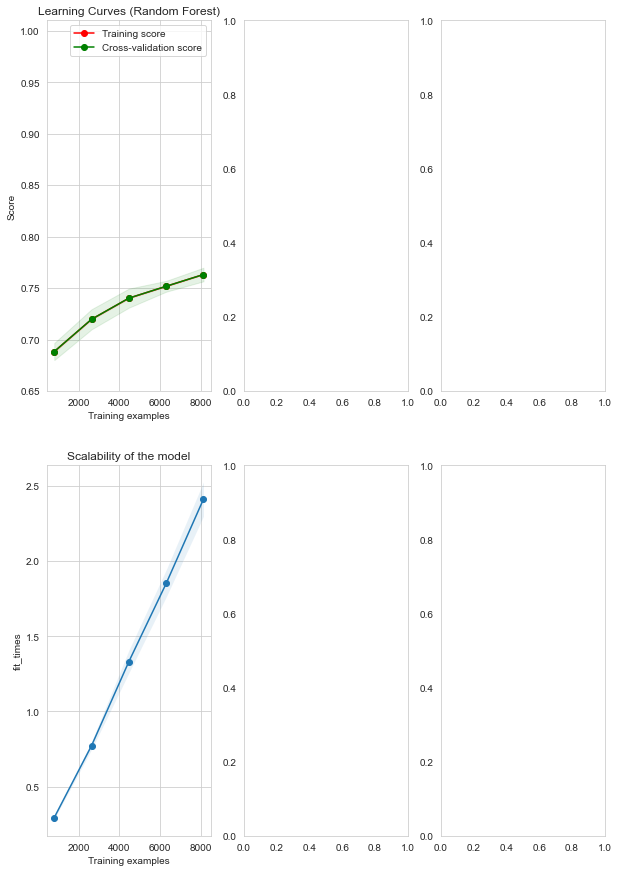

time: 864 ms (started: 2023-01-02 16:11:56 -08:00)


In [162]:
dpi=100
figure_filename = '../reports/figures/figure_train_size_score_random_forest_classifier_gradient_boosting_classifier_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(60, 15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:    
    fig, axes = plt.subplots(2, 3, figsize=(10, 15))

    title = "Learning Curves (Random Forest)"

    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    estimator = RandomForestClassifier(bootstrap=False, 
                                       max_depth=25, 
                                       min_samples_split=4, 
                                       n_estimators=200,
                                       random_state=200,
                                       min_samples_leaf=1,
                                       max_features='auto',
                                       criterion='gini',
                                       warm_start='False',)

    plt, learning_curve_random_forest_classifier = icr.plot_learning_curve(estimator, 
                                                                           title, 
                                                                           X=data_frame_collection['X_train'], 
                                                                           y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                           filename=learning_curve_results_filename_collection['random_forest_classifier'],
                                                                           axes=axes[:, 0], 
                                                                           ylim=(0.65, 1.01), 
                                                                           cv=cv, 
                                                                           n_jobs=4, 
                                                                           scoring="accuracy")


    title = r"Learning Curves (Gradient Boosting)"

    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                           max_depth = 9, 
                                           n_estimators = 250,
                                           random_state=200,
                                           max_features=None,
                                           verbose=0,
                                           max_leaf_nodes=None,
                                           warm_start=False,
                                           n_iter_no_change=None)

    plt, learning_curve_gradient_boosting_classifier = icr.plot_learning_curve(estimator, 
                                                                               title, 
                                                                               X=data_frame_collection['X_train'], 
                                                                               y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                               filename=learning_curve_results_filename_collection['gradient_boosting_classifier'],
                                                                               axes=axes[:, 1], 
                                                                               ylim=(0.65, 1.01), 
                                                                               cv=cv, 
                                                                               n_jobs=4)

    fig.subplots_adjust(wspace=.4)

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [ ]:
filename = '../reports/figures/figure_precision_recall_curve_random_forest_gradient_boosting_logistic_regression_metric_auc_v' + filename_version + '.png'
markersize=1
linewidth=1

#calculate precision-recall points
random_forest_classifier_precision_array, random_forest_classifier_recall_array, random_forest_classifier_threshold_array = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'])
#calculate precision-recall curve auc
random_forest_classifier_auc = auc(random_forest_classifier_recall_array, random_forest_classifier_precision_array)

# plot the precision-recall curve
plt.plot(random_forest_classifier_recall_array, random_forest_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Random Forest AUC=' + str(round(random_forest_classifier_auc, 3)))




#calculate precision-recall points
gradient_boosting_classifier_precision_array, gradient_boosting_classifier_recall_array, gradient_boosting_classifier_threshold_array = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'])
#calculate precision-recall curve auc
gradient_boosting_classifier_auc = auc(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array)

# plot the precision-recall curve
plt.plot(gradient_boosting_classifier_recall_array, gradient_boosting_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Gradient Boosting AUC=' + str(round(gradient_boosting_classifier_auc, 3)))




#calculate precision-recall points
logistic_regression_classifier_precision_array, logistic_regression_classifier_recall_array, _ = precision_recall_curve(y_true=data_frame_collection['Y_train'].loc[:, 'Y'], probas_pred=stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['logistic_regression_classifier'])

#calculate precision-recall curve auc
logistic_regression_classifier_auc = auc(logistic_regression_classifier_recall_array, logistic_regression_classifier_precision_array)

# plot the precision-recall curve
plt.plot(logistic_regression_classifier_recall_array, logistic_regression_classifier_precision_array, marker='.', markersize=markersize, linewidth=linewidth, label='Logistic Regression AUC=' + str(round(logistic_regression_classifier_auc, 3)))





#calculate no skill classifier curve
no_skill_classifier_auc = data_frame_collection['Y_train'].loc[data_frame_collection['Y_train'].loc[:, 'Y']==1, 'Y'].shape[0] / data_frame_collection['Y_train'].loc[:, 'Y'].shape[0]
plt.plot([0, 1], [no_skill_classifier_auc, no_skill_classifier_auc], linestyle='--', label='No Skill AUC='+str(round(no_skill_classifier_auc, 3)))

plt.xticks([.0, .1 ,.2, .3 ,.4, .5, .6 ,.7, .8, .9, 1 ])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.legend()


#save it
plt.savefig(filename, bbox_inches='tight', dpi=100)

plt.show()


#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


In [ ]:
#get random forest data frame of decision threshold, precision, and recall
random_forest_classifier_threshold_array = np.append(0, random_forest_classifier_threshold_array)

df_random_forest_decision_threshold_precision_recall = pd.DataFrame({'random_forest_decision_threshold':random_forest_classifier_threshold_array, 'random_forest_precision':random_forest_classifier_precision_array, 'random_forest_recall':random_forest_classifier_recall_array})
del random_forest_classifier_threshold_array
p(df_random_forest_decision_threshold_precision_recall)


In [ ]:
#get gradient boosting data frame of decision threshold, precision, and recall
gradient_boosting_classifier_threshold_array = np.append(0, gradient_boosting_classifier_threshold_array)

df_gradient_boosting_decision_threshold_precision_recall = pd.DataFrame({'gradient_boosting_decision_threshold':gradient_boosting_classifier_threshold_array, 'gradient_boosting_precision':gradient_boosting_classifier_precision_array, 'gradient_boosting_recall':gradient_boosting_classifier_recall_array})
del gradient_boosting_classifier_threshold_array
p(df_gradient_boosting_decision_threshold_precision_recall)


## Get Model Precision .9 and  Recall .8 Decision Threshold by Coupon Venue Type

### Get Data Frame Y Actual, Y Random Forest Prediction Probability, Y Gradient Boosting Prediction Probability Collection by Coupon Venue Type

In [ ]:
# Get Coupon Venue Type, Random Forest Prediction Probability, Gradient Boosting Prediction Probability, and Y Actual
data_frame_list = [df_stratified_fold_number_y_test.reset_index(drop=True), 
                   stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['random_forest_classifier'].to_frame().rename(columns={1:'Y_random_forest_prediction_probability'}).reset_index(drop=True),
                   stratified_5_fold_cross_validation_model_classifier_prediction_probability_series_collection['gradient_boosting_classifier'].to_frame().rename(columns={1:'Y_gradient_boosting_prediction_probability'}).reset_index(drop=True),
                   df_stratified_fold_number_X_test.loc[:, 'coupon_venue_type'].reset_index(drop=True)]

df_y_train_prediction_probability_coupon_venue_type = pd.concat(data_frame_list, axis=1)

#get data frame collection by coupon venue type
coupon_venue_type_list = df_y_train_prediction_probability_coupon_venue_type.loc[:, 'coupon_venue_type'].drop_duplicates().to_list()

df_y_train_prediction_probability_coupon_venue_type_collection = {coupon_venue_type: df_y_train_prediction_probability_coupon_venue_type.loc[df_y_train_prediction_probability_coupon_venue_type.loc[:, 'coupon_venue_type']== coupon_venue_type,:] for coupon_venue_type in coupon_venue_type_list}

p(df_y_train_prediction_probability_coupon_venue_type_collection['Coffee House'])



In [ ]:
#baseline for classification problem???

#for varying percentage of total number of coupon recommendation opportunities, ???

## Get Baseline Confusion Matrix

In [ ]:
number_of_predictions = data_frame_collection['Y_train'].shape[0]

y_true=data_frame_collection['Y_train']

np.random.seed(200)
#y_pred=np.random.randint(2, size=number_of_predictions)#no adjustment needed, just a baseline example application
class_0_probability = data_frame_collection['Y_train'].value_counts()[0] / data_frame_collection['Y_train'].shape[0]
class_1_probability = data_frame_collection['Y_train'].value_counts()[1] / data_frame_collection['Y_train'].shape[0]
y_pred=np.random.choice([0, 1], size=number_of_predictions, p=[class_0_probability, class_1_probability])

#altnerative to assigning 0 and 1 in train class ratio, which is not respecting the train test structure of not knowing the y_test outcomes per cross validation.

#so the way to fix this is to get the 0 to 1 ratio of the 4 folds that would be used to generate 0s and 1s to predict on the held out test fold?


baseline_precision = precision_score(y_true, y_pred)
baseline_recall = recall_score(y_true, y_pred)
baseline_accuracy = accuracy_score(y_true, y_pred)

print('baseline_precision: '+ str(baseline_precision))
print('baseline_recall: ' + str(baseline_recall))
print('baseline_accuracy: ' + str(baseline_accuracy))

confusion_matrix_ndarray = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix_ndarray.ravel()
print('tn: ' + str(tn))
print('fp: ' + str(fp))
print('fn: ' + str(fn))
print('tp: ' + str(tp))

print('Of ' + str(tp + fp) + ' coupon recommendations ' + str(tp) + ' accepted the coupon saying they would use it. \
This is a potential ' + str(round(baseline_precision*100, 2)) + '% conversion rate and a potential ' + str(3259) + ' total customer acquisitions.') 

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_ndarray, display_labels=[0,1])
disp.plot()
plt.grid(False)

plt.show()

In [ ]:
#get feature importants plot
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_20_feature_importances_v' + filename_version + '.png'

plt.subplots(figsize=(4, 8))

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:20].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top 20 Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)



In [ ]:
#get feature importants plot
top_number_features = 50
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_'+ str(top_number_features) +'_feature_importances_v' + filename_version + '.png'


plt.subplots(figsize=(6, 10))

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:top_number_features].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top ' + str(top_number_features)   + ' Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)



In [ ]:
#get feature importants plot
top_number_features = 100
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_train_top_'+ str(top_number_features) +'_feature_importances_v' + filename_version + '.png'

figsize=(6, 12)
plt.subplots(figsize=figsize)

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:top_number_features].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top ' + str(top_number_features)   + ' Feature Importances');

plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)



In [ ]:
column_name_list_random_forest_classifier_top_50_by_feature_importance = series_random_forest_classifier_feature_importances[0:50].index.to_list()

column_name_list_random_forest_classifier_top_25_by_feature_importance = series_random_forest_classifier_feature_importances[0:25].index.to_list()

pl(column_name_list_random_forest_classifier_top_50_by_feature_importance)

In [ ]:
column_name_list_random_forest_classifier_top_50_by_feature_importance_target = column_name_list_random_forest_classifier_top_50_by_feature_importance + ['Y']
column_name_list_random_forest_classifier_top_25_by_feature_importance_target = column_name_list_random_forest_classifier_top_25_by_feature_importance + ['Y']
pl(column_name_list_random_forest_classifier_top_25_by_feature_importance_target)


In [ ]:
df_train = pd.concat([data_frame_collection['X_train'], data_frame_collection['Y_train']], axis=1)
p(df_train)

In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_correlation_heatmap_random_forest_classifier_train_top_50_and_target_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(35, 28))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    #correlation heatmap of top 50 features and target

    df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance_target].corr()

    fig, ax = plt.subplots(figsize=(30, 24))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]

    corr = df_corr.iloc[1:,:-1].copy()

    sns.set(font_scale=1.4)
    sns.set_style("white")

    res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
    plt.title('Correlation Heatmap Random Forest of Top 50 Features and Target', fontsize=18)

    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [ ]:
#categories of top 25 features???

pl(column_name_list_random_forest_classifier_top_25_by_feature_importance)

#coupon_venue_type - coupon venue type

#temperature - outside temperature

#expiration - time til expiration

#CoffeeHouse - coffee house visits per month

<font size="5"><a id='[Modeling_Test_Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling_1](#[Modeling_1])</font> <font size="2">[Modeling_2](#[Modeling_2])</font> <font size="2">[Modeling_Train_Results](#[Modeling_Train_Results])</font> <font size="2">[Modeling_Test_Results](#[Modeling_Test_Results])</font>


<font size="6"><a id='[Modeling_Test_Results]'>**Modeling Test Results**</a> </font>

# Get Model Metrics, Survey Statistics, and Model-Survey Ratios Per Coupon Type

In [ ]:
#per high conversion rate, what features values say something interesting??

#per high conversion rate, what coupon venue types say something interesting??



Modeling Test Results Summary: 
- **1. Take each of two decision thresholds selected in Model Train Results for estimated .9 Precision and estimated .8 Recall.**
- **2. Based on demographic and scenario features, get coupon acceptance or refusal prediction probabilities.**
- **3. Combine model prediction probabilities and decision threshold to get recommendation to offer or not offer a coupon.**
- **4. Get metrics for coupon recommendations, e.g. conversion rate, number of coupons recommended, number of conversions, and recall**

- **Survey results???**
- **line**
    - **line1** line1
    - **exploratory data analysis** (pandas Foundations, Module Two)
- **line2** line2


we make decisions on who to offer a coupon to in the survey given their demographic and scenario features

### Get Data Frame Random Forest Prediction Probability, Gradient Boosting Prediction Probability, Y Actual, Coupon Venue Type

In [ ]:
## Get Prediction Probabilities for Gradient Boosting, Prediction Probabilities for Random Forest, Y_actual, and coupon venue type
Y_test_random_forest_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_random_forest_prediction_probability = pd.DataFrame(Y_test_random_forest_prediction_probability_class0_class1_ndarray).loc[:, 1]


Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_gradient_boosting_prediction_probability = pd.DataFrame(Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray).loc[:, 1]


df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type = \
pd.concat([df_Y_test_random_forest_prediction_probability.to_frame().rename(columns={1:'Y_test_random_forest_prediction_probability'}), 
           df_Y_test_gradient_boosting_prediction_probability.to_frame().rename(columns={1:'Y_test_gradient_boosting_prediction_probability'}), 
           data_frame_collection['Y_test'].reset_index(drop=True),
           df_collection['X_test'].loc[:, 'coupon_venue_type'].reset_index(drop=True)], axis=1)

p(df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type)


## Get Random Forest Test Metrics for Overall .9 Precision Estimated by Decision Threshold

In [ ]:
# Get Random Forest Predictions by Decision Threshold for .9 Precision
random_forest_decision_threshold_precision_90 = df_random_forest_decision_threshold_precision_recall.loc[df_random_forest_decision_threshold_precision_recall.loc[:, 'random_forest_precision'] >= .9, 'random_forest_decision_threshold'].iloc[0]
Y_test_random_forest_prediction_probability_list = df_Y_test_random_forest_prediction_probability.to_list()
Y_test_prediction_list = [1 if prediction_probability > random_forest_decision_threshold_precision_90 else 0 for prediction_probability in Y_test_random_forest_prediction_probability_list]
df_Y_test_prediction = pd.DataFrame(Y_test_prediction_list, columns=['Y_test_predicted'])

#p(df_Y_test_prediction)


# Get Precision, Recall, Number of Conversions Correctly Predicted, Number of Conversion Predicted, and Number of Conversions Correctly Predicted Possible
print('OVERALL: Random Forest Precision .9')

random_forest_test_precision = precision_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_prediction)
print('random_forest_test_precision: ' + str(random_forest_test_precision))

random_forest_test_recall = recall_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_prediction)
print('random_forest_test_recall: ' + str(random_forest_test_recall))

confusion_matrix_ndarray = confusion_matrix(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_prediction)
tn, fp, fn, random_forest_test_number_of_conversions_correctly_predicted = confusion_matrix_ndarray.ravel()
print('random_forest_test_number_of_conversions_correctly_predicted: ' + str(random_forest_test_number_of_conversions_correctly_predicted))

random_forest_test_number_of_conversions_predicted = random_forest_test_number_of_conversions_correctly_predicted + fp
print('random_forest_test_number_of_conversions_predicted: ' + str(random_forest_test_number_of_conversions_predicted))

random_forest_test_number_of_conversions_correctly_predicted_possible = random_forest_test_number_of_conversions_correctly_predicted + fn
print('random_forest_test_number_of_conversions: ' + str(random_forest_test_number_of_conversions_correctly_predicted_possible))



## Get Survey Test Metrics

In [ ]:
print('SURVEY TEST')
print('number of coupons recommended')
df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type.loc[:, 'coupon_venue_type'].value_counts()

In [ ]:
print('SURVEY TEST')
print('number of coupons recommended proportion')
df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type.loc[:, 'coupon_venue_type'].value_counts()/2537

In [ ]:
icr.get_survey_metrics(df=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, 
                       feature_column_name='coupon_venue_type',
                       feature_column_name_value_list=['Coffee House', 'Restaurant(20-50)', 'Bar', 'Restaurant(<20)','Carry out & Take away'],
                       target_column_name='Y')

## Get Random Forest Test Metrics Per Coupon Venue Type for Overall .9 Precision Estimated

### Get Random Forest Test Coupon Venue Type

In [ ]:
df_random_forest_coupon_venue_type_y_actual_y_test_predicted = pd.concat([df_collection['X_test'].loc[:, 'coupon_venue_type'].reset_index(drop=True), df_collection['Y_test'].reset_index(drop=True).rename('Y_test'), df_Y_test_prediction], axis=1)

p(df_random_forest_coupon_venue_type_y_actual_y_test_predicted)


### Get Random Forest Test Overall .9 Precision Estimated Metrics

In [ ]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[0], prediction_column_name='Y_test_predicted')


In [ ]:
icr.get_survey_metrics(df=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, 
                       feature_column_name='coupon_venue_type',
                       feature_column_name_value_list=['Coffee House'],
                       target_column_name='Y')

In [ ]:
print('difficulty of conversion = model number converted / survey number of coupons offered: ' + str(122/811))


In [ ]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[2], prediction_column_name='Y_test_predicted')


In [ ]:
icr.get_survey_metrics(df=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, 
                       feature_column_name='coupon_venue_type',
                       feature_column_name_value_list=['Bar'],
                       target_column_name='Y')

In [ ]:
print('difficulty of conversion = model number converted / survey number of coupons offered: ' + str(19/399))


In [ ]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[1], prediction_column_name='Y_test_predicted')


In [ ]:
icr.get_survey_metrics(df=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, 
                       feature_column_name='coupon_venue_type',
                       feature_column_name_value_list=['Carry out & Take away'],
                       target_column_name='Y')

In [ ]:
print('difficulty of conversion = model number converted / survey number of coupons offered: ' + str(166/489))


In [ ]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[4], prediction_column_name='Y_test_predicted')


In [ ]:
icr.get_survey_metrics(df=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, 
                       feature_column_name='coupon_venue_type',
                       feature_column_name_value_list=['Restaurant(<20)'],
                       target_column_name='Y')

In [ ]:
print('difficulty of conversion = model number converted / survey number of coupons offered: ' + str(181/534))

In [ ]:
icr.get_metrics_by_venue_type(df=df_random_forest_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type=coupon_venue_type_list[3], prediction_column_name='Y_test_predicted')


In [ ]:
icr.get_survey_metrics(df=df_y_test_model_name_prediction_probability_y_actual_coupon_venue_type, 
                       feature_column_name='coupon_venue_type',
                       feature_column_name_value_list=['Restaurant(20-50)'],
                       target_column_name='Y')

In [ ]:
print('difficulty of conversion = model number converted / survey number of coupons offered: ' + str(8/304))

## Get Gradient Boosting .8 Recall Metrics Overall and by Coupon Venue Type

### Get Gradient Boosting .8 Recall Decision Threshold Estimate

In [ ]:
gradient_boosting_test_recall_80_decision_threshold_estimate = df_gradient_boosting_decision_threshold_precision_recall.loc[df_gradient_boosting_decision_threshold_precision_recall.loc[:, 'gradient_boosting_recall'] >= .8, 'gradient_boosting_decision_threshold'].iloc[-1]


### Get Gradient Boosting Prediction Probabilities

In [ ]:
Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray = best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.predict_proba(data_frame_collection['X_test'])
df_Y_test_gradient_boosting_prediction_probability = pd.DataFrame(Y_test_gradient_boosting_prediction_probability_class0_class1_ndarray).loc[:, 1]


### Get Gradient Boosting Predictions from Prediction Probabilities and .8 Recall Decision Threshold Estimate

In [ ]:
Y_test_gradient_boosting_prediction_probability_list = df_Y_test_gradient_boosting_prediction_probability.to_list()

Y_test_gradient_boosting_prediction_list = [1 if prediction_probability > gradient_boosting_test_recall_80_decision_threshold_estimate else 0 for prediction_probability in Y_test_gradient_boosting_prediction_probability_list]

df_Y_test_gradient_boosting_prediction = pd.DataFrame(Y_test_gradient_boosting_prediction_list, columns=['Y_test_predicted'])
p(df_Y_test_gradient_boosting_prediction)


In [ ]:
#get precision, recall, number of conversions

print('OVERALL: Gradient Boosting Recall .8')

gradient_boosting_test_precision = precision_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_gradient_boosting_prediction)
print('gradient_boosting_test_precision: ' + str(gradient_boosting_test_precision))

gradient_boosting_test_recall = recall_score(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_gradient_boosting_prediction)
print('gradient_boosting_test_recall: ' + str(gradient_boosting_test_recall))

confusion_matrix_ndarray = confusion_matrix(y_true=data_frame_collection['Y_test'], y_pred=df_Y_test_gradient_boosting_prediction)
tn, fp, fn, gradient_boosting_test_number_of_conversions_correctly_predicted = confusion_matrix_ndarray.ravel()
print('gradient_boosting_test_number_of_conversions_correctly_predicted: ' + str(gradient_boosting_test_number_of_conversions_correctly_predicted))

gradient_boosting_test_number_of_conversions_predicted = gradient_boosting_test_number_of_conversions_correctly_predicted + fp
print('gradient_boosting_test_number_of_conversions_predicted: ' + str(gradient_boosting_test_number_of_conversions_predicted))


gradient_boosting_test_number_of_conversions_correctly_predicted_possible = gradient_boosting_test_number_of_conversions_correctly_predicted + fn
print('gradient_boosting_test_number_of_conversions: ' + str(gradient_boosting_test_number_of_conversions_correctly_predicted_possible))



### Get Gradient Boosting .8 Recall Test Prediction, Actual, and Coupon Venue Type

In [ ]:
df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted = \
pd.concat([df_collection['X_test'].loc[:, 'coupon_venue_type'].reset_index(drop=True), df_collection['Y_test'].reset_index(drop=True).rename('Y_test'), df_Y_test_gradient_boosting_prediction], axis=1)

p(df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted)


### Get Gradient Boosting .8 Recall Test Prediction Results by Coupon Venue Type: Coffee House, Bar, Takeout, Low-Cost Restaurant, Expensive Restaurant

In [ ]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Coffee House', prediction_column_name='Y_test_predicted')

In [ ]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Bar', prediction_column_name='Y_test_predicted')

In [ ]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Carry out & Take away', prediction_column_name='Y_test_predicted')

In [ ]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Restaurant(<20)', prediction_column_name='Y_test_predicted')

In [ ]:
icr.get_metrics_by_venue_type(df=df_gradient_boosting_coupon_venue_type_y_actual_y_test_predicted, coupon_venue_type='Restaurant(20-50)', prediction_column_name='Y_test_predicted')

### Random Forest Classifier: All Data, Reduced Features

In [ ]:
#drop repeated features with 99-100% correlation
drop_features_list = ['income_ordinal_integer_encoding',
                      'age_ordinal_integer_encoding',
                      'time_ordinal_integer_encoding',
                      'temperature_ordinal_integer_encoding']

#get all preprocessed data
df_X_train_test = pd.concat([data_frame_collection['X_train'], data_frame_collection['X_test']], axis=0).drop(columns=drop_features_list)
df_Y_train_test = pd.concat([data_frame_collection['Y_train'], data_frame_collection['Y_test']], axis=0)

#get data frame with all data
df_X_train_test_Y_train_test = pd.concat([df_X_train_test, df_Y_train_test], axis=1)
del df_X_train_test, df_Y_train_test

#train random forest classifer all data
random_forest_classifier_all_data = RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=5, n_estimators=200, random_state=200)
random_forest_classifier_all_data.fit(df_X_train_test_Y_train_test.drop(columns=['Y']), df_X_train_test_Y_train_test.loc[:, 'Y'])
random_forest_classifier_all_data_fit = random_forest_classifier_all_data
del random_forest_classifier_all_data



#save random forest classifier all data
model_readback = icr.return_saved_model_if_it_exists(filename=random_forest_classifier_all_data_fit_filename)
if model_readback != None:
    random_forest_classifier_all_data_fit = model_readback
else:   
    #add model environment data to model
    random_forest_classifier_all_data_fit.version = model_version
    random_forest_classifier_all_data_fit.pandas_version = pd.__version__
    random_forest_classifier_all_data_fit.numpy_version = np.__version__
    random_forest_classifier_all_data_fit.sklearn_version = sklearn_version
    random_forest_classifier_all_data_fit.X_columns = [column_name for column_name in df_X_train_test_Y_train_test.drop(columns=['Y']).columns]
    random_forest_classifier_all_data_fit.build_datetime = datetime.datetime.now()
    
    #save it
    random_forest_classifier_all_data_fit = icr.save_and_return_model(random_forest_classifier_all_data_fit, filename=random_forest_classifier_all_data_fit_filename)
    
random_forest_classifier_all_data_fit


### Get Feature Importances Plot

In [ ]:
dpi=100
figure_filename = '../reports/figures/figure_random_forest_classifier_all_data_fit_top_20_feature_importances_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(15, 12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    plt.subplots(figsize=(4, 8))

    random_forest_classifier_all_data_fit_feature_importances = random_forest_classifier_all_data_fit.feature_importances_
    series_random_forest_classifier_all_data_fit_feature_importances = pd.Series(random_forest_classifier_all_data_fit_feature_importances, 
                                                                                 index=random_forest_classifier_all_data_fit.X_columns).sort_values(ascending=False)

    series_random_forest_classifier_all_data_fit_feature_importances[0:20].sort_values(ascending=True).plot(kind='barh')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Random Forest Classifier Top 20 Feature Importances');

    plt.savefig(figure_filename, bbox_inches='tight', dpi=100)

plt.show()

### Random Forest Classifier: All Data, Reduced Features

#### Get Random Forest Features By Importance

In [ ]:
#get and order random forest features by importance
random_forest_classifier_all_data_fit_feature_importances = random_forest_classifier_all_data_fit.feature_importances_
series_random_forest_classifier_all_data_fit_feature_importances = pd.Series(random_forest_classifier_all_data_fit_feature_importances,
                                                                             index=random_forest_classifier_all_data_fit.X_columns).sort_values(ascending=False)


#get top 25 and 50 features list
column_name_list_random_forest_classifier_all_data_top_50_by_feature_importance_target = series_random_forest_classifier_all_data_fit_feature_importances[0:50].index.to_list() + ['Y']
column_name_list_random_forest_classifier_all_data_top_25_by_feature_importance_target = series_random_forest_classifier_all_data_fit_feature_importances[0:25].index.to_list() + ['Y']

pl(column_name_list_random_forest_classifier_all_data_top_50_by_feature_importance_target)


#### Identify High Correlation Features For Drop

In [ ]:
#Identify High Correlation Features For Drop
dpi=100
figure_filename = '../reports/figures/figure_correlation_heatmap_random_forest_classifier_all_data_top_25_and_target_dpi_' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)
if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(35, 28))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
else:
    #correlation heatmap of top 25 features and target

    df_corr = df_X_train_test_Y_train_test.loc[:, column_name_list_random_forest_classifier_all_data_top_25_by_feature_importance_target].corr()

    fig, ax = plt.subplots(figsize=(30, 24))

    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    mask = mask[1:, :-1]

    corr = df_corr.iloc[1:,:-1].copy()

    sns.set(font_scale=1.4)
    sns.set_style("white")

    res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)
    plt.title('Correlation Heatmap Random Forest of Top 25 Features and Target', fontsize=18)

    #save it
    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()



In [ ]:
top_25_feature_importance_duplicate_like_features_list = \
['income_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'age_category_representative_numeric_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'temperature_ordinal_integer_encoding',
 'temperature']

top_25_feature_importance_duplicate_like_features_list_drop = \
['income_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'time_ordinal_integer_encoding',
 'temperature_ordinal_integer_encoding']

pl(top_25_feature_importance_duplicate_like_features_list_drop)

In [ ]:
dir()

In [ ]:
!pip3 install watermark

%load_ext watermark

In [ ]:
%watermark -a "Paul Jacob" -d -t -v -p numpy,pandas -g

In [ ]:
#https://towardsdatascience.com/generating-a-requirements-file-jupyter-notebook-385f1c315b52

